In [1]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Reshape, \
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add, Lambda, Softmax
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
import librosa

import numpy as np
import os, sys
import audio_producer

# Params

In [2]:
params = {
        "net":'resnet34s', # ['resnet34s', 'resnet34l']
        "loss": "amsoftmax", # ['softmax', 'amsoftmax']
        "aggregation_mode": 'gvlad', #['avg', 'vlad', 'gvlad']
    
        "json_path": r"vox.json",
        "sample_rate": 16000,
        "min_duration": 1000,
        "max_duration": 3000,
        "save_path": r"saver/model.ckpt",
        "restore_path": r"ckpt/model.ckpt",
    
        "batch_size": 256,
        "epochs": 1000,
        "init_learning_rate": 0.001,
        "max_grad_norm": 50,
        "decay_steps": 5000,
        "decay_rate": 0.95,
        "momentum": 0.9,
        "staircase": False,
    

        "vlad_clusters": 8,
        "ghost_clusters": 2,
        "bottleneck_dim": 512,
        "num_class": 5994,
    
        # FOR TEST
        "resume": r'pretrained/weights.h5',
        "data_path":'4persons',
        'test_type': 'normal',
    
        'dim': (257, None, 1),
        'nfft': 512,
        'min_slice': 720,
        'win_length': 400,
        'hop_length': 160,
        'normalize': True,
    }



# Multiple GPU Configuration 

In [3]:
class ModelMGPU(Model):
    def __init__(self, ser_model, gpus):
        pmodel = keras.utils.multi_gpu_model(ser_model, gpus)
        self.__dict__.update(pmodel.__dict__)
        self._smodel = ser_model

    def __getattribute__(self, attrname):
        '''Override load and save methods to be used from the serial-model. The
        serial-model holds references to the weights in the multi-gpu model.
        '''
        # return Model.__getattribute__(self, attrname)
        if 'load' in attrname or 'save' in attrname:
            return getattr(self._smodel, attrname)

        return super(ModelMGPU, self).__getattribute__(attrname)

# Model Definition

In [129]:
weight_decay = 1e-4

### ResNet Definition

In [130]:
def identity_block_2D(input_tensor, kernel_size, filters, stage, block, trainable=True):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    bn_axis = 3

    conv_name_1 = 'conv' + str(stage) + '_' + str(block) + '_1x1_reduce'
    bn_name_1 = 'conv' + str(stage) + '_' + str(block) + '_1x1_reduce/bn'
    x = Conv2D(filters1, (1, 1),
               kernel_initializer='orthogonal',
               use_bias=False,
               trainable=trainable,
               kernel_regularizer=l2(weight_decay),
               name=conv_name_1)(input_tensor)
    x = BatchNormalization(axis=bn_axis, trainable=trainable, name=bn_name_1)(x)
    x = Activation('relu')(x)

    conv_name_2 = 'conv' + str(stage) + '_' + str(block) + '_3x3'
    bn_name_2 = 'conv' + str(stage) + '_' + str(block) + '_3x3/bn'
    x = Conv2D(filters2, kernel_size,
               padding='same',
               kernel_initializer='orthogonal',
               use_bias=False,
               trainable=trainable,
               kernel_regularizer=l2(weight_decay),
               name=conv_name_2)(x)
    x = BatchNormalization(axis=bn_axis, trainable=trainable, name=bn_name_2)(x)
    x = Activation('relu')(x)

    conv_name_3 = 'conv' + str(stage) + '_' + str(block) + '_1x1_increase'
    bn_name_3 = 'conv' + str(stage) + '_' + str(block) + '_1x1_increase/bn'
    x = Conv2D(filters3, (1, 1),
               kernel_initializer='orthogonal',
               use_bias=False,
               trainable=trainable,
               kernel_regularizer=l2(weight_decay),
               name=conv_name_3)(x)
    x = BatchNormalization(axis=bn_axis, trainable=trainable, name=bn_name_3)(x)

    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

In [131]:
def conv_block_2D(input_tensor, kernel_size, filters, stage, block, strides=(2, 2), trainable=True):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters
    bn_axis = 3

    conv_name_1 = 'conv' + str(stage) + '_' + str(block) + '_1x1_reduce'
    bn_name_1 = 'conv' + str(stage) + '_' + str(block) + '_1x1_reduce/bn'
    x = Conv2D(filters1, (1, 1),
               strides=strides,
               kernel_initializer='orthogonal',
               use_bias=False,
               trainable=trainable,
               kernel_regularizer=l2(weight_decay),
               name=conv_name_1)(input_tensor)
    x = BatchNormalization(axis=bn_axis, trainable=trainable, name=bn_name_1)(x)
    x = Activation('relu')(x)

    conv_name_2 = 'conv' + str(stage) + '_' + str(block) + '_3x3'
    bn_name_2 = 'conv' + str(stage) + '_' + str(block) + '_3x3/bn'
    x = Conv2D(filters2, kernel_size, padding='same',
               kernel_initializer='orthogonal',
               use_bias=False,
               trainable=trainable,
               kernel_regularizer=l2(weight_decay),
               name=conv_name_2)(x)
    x = BatchNormalization(axis=bn_axis, trainable=trainable, name=bn_name_2)(x)
    x = Activation('relu')(x)

    conv_name_3 = 'conv' + str(stage) + '_' + str(block) + '_1x1_increase'
    bn_name_3 = 'conv' + str(stage) + '_' + str(block) + '_1x1_increase/bn'
    x = Conv2D(filters3, (1, 1),
               kernel_initializer='orthogonal',
               use_bias=False,
               trainable=trainable,
               kernel_regularizer=l2(weight_decay),
               name=conv_name_3)(x)
    x = BatchNormalization(axis=bn_axis, trainable=trainable, name=bn_name_3)(x)

    conv_name_4 = 'conv' + str(stage) + '_' + str(block) + '_1x1_proj'
    bn_name_4 = 'conv' + str(stage) + '_' + str(block) + '_1x1_proj/bn'
    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      kernel_initializer='orthogonal',
                      use_bias=False,
                      trainable=trainable,
                      kernel_regularizer=l2(weight_decay),
                      name=conv_name_4)(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, trainable=trainable, name=bn_name_4)(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x

In [132]:
def resnet_2D_v1(input_dim, mode='train'):
    bn_axis = 3
    if mode == 'train':
        inputs = Input(shape=input_dim, name='input')
    else:
        inputs = Input(shape=(input_dim[0], None, input_dim[-1]), name='input')
    # ==============================================================================================
    #            Convolution Block 1 - output --> the output shape is the same as the input shape
    # ==============================================================================================
    x1 = Conv2D(64, (7, 7),
                kernel_initializer='orthogonal',
                use_bias=False, trainable=True,
                kernel_regularizer=l2(weight_decay),
                padding='same',
                name='conv1_1/3x3_s1')(inputs)

    x1 = BatchNormalization(axis=bn_axis, name='conv1_1/3x3_s1/bn', trainable=True)(x1)
    x1 = Activation('relu')(x1)
    x1 = MaxPooling2D((2, 2), strides=(2, 2))(x1)

    # ===============================================
    #            Convolution Section 2
    # ===============================================
    x2 = conv_block_2D(x1, 3, [48, 48, 96], stage=2, block='a', strides=(1, 1), trainable=True)
    x2 = identity_block_2D(x2, 3, [48, 48, 96], stage=2, block='b', trainable=True)

    # ===============================================
    #            Convolution Section 3
    # ===============================================
    x3 = conv_block_2D(x2, 3, [96, 96, 128], stage=3, block='a', trainable=True)
    x3 = identity_block_2D(x3, 3, [96, 96, 128], stage=3, block='b', trainable=True)
    x3 = identity_block_2D(x3, 3, [96, 96, 128], stage=3, block='c', trainable=True)
    # ===============================================
    #            Convolution Section 4
    # ===============================================
    x4 = conv_block_2D(x3, 3, [128, 128, 256], stage=4, block='a', trainable=True)
    x4 = identity_block_2D(x4, 3, [128, 128, 256], stage=4, block='b', trainable=True)
    x4 = identity_block_2D(x4, 3, [128, 128, 256], stage=4, block='c', trainable=True)
    # ===============================================
    #            Convolution Section 5
    # ===============================================
    x5 = conv_block_2D(x4, 3, [256, 256, 512], stage=5, block='a', trainable=True)
    x5 = identity_block_2D(x5, 3, [256, 256, 512], stage=5, block='b', trainable=True)
    x5 = identity_block_2D(x5, 3, [256, 256, 512], stage=5, block='c', trainable=True)
    y = MaxPooling2D((3, 1), strides=(2, 1), name='mpool2')(x5)
    
    return inputs, y

In [133]:
def resnet_2D_v2(input_dim, mode='train'):
    bn_axis = 3
    if mode == 'train':
        inputs = Input(shape=input_dim, name='input')
    else:
        inputs = Input(shape=(input_dim[0], None, input_dim[-1]), name='input')
    # ===============================================
    #            Convolution Block 1
    # ===============================================
    x1 = Conv2D(64, (7, 7), strides=(2, 2),
                kernel_initializer='orthogonal',
                use_bias=False, trainable=True,
                kernel_regularizer=l2(weight_decay),
                padding='same',
                name='conv1_1/3x3_s1')(inputs)

    x1 = BatchNormalization(axis=bn_axis, name='conv1_1/3x3_s1/bn', trainable=True)(x1)
    x1 = Activation('relu')(x1)
    x1 = MaxPooling2D((2, 2), strides=(2, 2))(x1)

    # ===============================================
    #            Convolution Section 2
    # ===============================================
    x2 = conv_block_2D(x1, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), trainable=True)
    x2 = identity_block_2D(x2, 3, [64, 64, 256], stage=2, block='b', trainable=True)
    x2 = identity_block_2D(x2, 3, [64, 64, 256], stage=2, block='c', trainable=True)
    # ===============================================
    #            Convolution Section 3
    # ===============================================
    x3 = conv_block_2D(x2, 3, [128, 128, 512], stage=3, block='a', trainable=True)
    x3 = identity_block_2D(x3, 3, [128, 128, 512], stage=3, block='b', trainable=True)
    x3 = identity_block_2D(x3, 3, [128, 128, 512], stage=3, block='c', trainable=True)
    # ===============================================
    #            Convolution Section 4
    # ===============================================
    x4 = conv_block_2D(x3, 3, [256, 256, 1024], stage=4, block='a', strides=(1, 1), trainable=True)
    x4 = identity_block_2D(x4, 3, [256, 256, 1024], stage=4, block='b', trainable=True)
    x4 = identity_block_2D(x4, 3, [256, 256, 1024], stage=4, block='c', trainable=True)
    # ===============================================
    #            Convolution Section 5
    # ===============================================
    x5 = conv_block_2D(x4, 3, [512, 512, 2048], stage=5, block='a', trainable=True)
    x5 = identity_block_2D(x5, 3, [512, 512, 2048], stage=5, block='b', trainable=True)
    x5 = identity_block_2D(x5, 3, [512, 512, 2048], stage=5, block='c', trainable=True)
    y = MaxPooling2D((3, 1), strides=(2, 1), name='mpool2')(x5)
    
    return inputs, y

### VLAD Layer Definition

In [134]:
class VladPooling(keras.layers.Layer):
    '''
    This layer follows the NetVlad, GhostVlad
    '''
    def __init__(self, mode, k_centers, g_centers=0, name="VladPooling", **kwargs):
        super(VladPooling, self).__init__(name=name, **kwargs)
        
        self.k_centers = k_centers
        self.g_centers = g_centers
        self.mode = mode
        

    def build(self, input_shape):
        self.cluster = self.add_weight(shape=[self.k_centers+self.g_centers, input_shape[0][-1]],
                                       name='centers',
                                       initializer='orthogonal')
        self.built = True

    def compute_output_shape(self, input_shape):
        assert input_shape
        return (input_shape[0][0], self.k_centers*input_shape[0][-1])

    def call(self, x):
        # feat : bz x W x H x D, cluster_score: bz X W x H x clusters.
        feat, cluster_score = x
        num_features = feat.shape[-1]

        # softmax normalization to get soft-assignment.
        # stable variant: Deep Learning, MIT Press, pg 180-181
        # softmax(z) = softmax(z - max(z))
        
        # A : bz x W x H x clusters
        max_cluster_score = K.max(cluster_score, -1, keepdims=True)
        exp_cluster_score = K.exp(cluster_score - max_cluster_score)
        A = exp_cluster_score / K.sum(exp_cluster_score, axis=-1, keepdims = True)
        
        # A = Softmax(axis=-1, name="softmax_vlad")(cluster_score - max_cluster_score)
        # A = tf.nn.softmax(cluster_score - max_cluster_score, axis=-1)
        
        # Now, need to compute the residual, self.cluster: clusters x D
        A = K.expand_dims(A, -1)    # A : bz x W x H x clusters x 1
        feat_broadcast = K.expand_dims(feat, -2)    # feat_broadcast : bz x W x H x 1 x D
        feat_res = feat_broadcast - self.cluster    # feat_res : bz x W x H x clusters x D
        weighted_res = tf.multiply(A, feat_res)     # weighted_res : bz x W x H x clusters x D
        cluster_res = K.sum(weighted_res, [1, 2])  #<-- agregation over time --> (bz x clusters x D)

        
        if self.mode == 'gvlad':
            cluster_res = cluster_res[:, :self.k_centers, :]

        cluster_l2 = K.l2_normalize(cluster_res, -1)  # normalize D dimension
        outputs = K.reshape(cluster_l2, [-1, int(self.k_centers) * int(num_features)])
        
        return outputs

### Build General Model

In [135]:
def GVladModel(input_dim=(257, 250, 1), num_class=8631, mode='train', args=None):
    
    net=args["net"]
    loss=args["loss"]
    vlad_clusters=args["vlad_clusters"]
    ghost_clusters=args["ghost_clusters"]
    bottleneck_dim=args["bottleneck_dim"]
    aggregation = args["aggregation_mode"]


    if net == 'resnet34s':
        inputs, x = resnet_2D_v1(input_dim=input_dim, mode=mode)
    else:
        inputs, x = resnet_2D_v2(input_dim=input_dim, mode=mode)
        
        
        
    # ===============================================
    #            Fully Connected Block 1
    # ===============================================
    x_fc = Conv2D(bottleneck_dim, (7, 1),
                   strides=(1, 1),
                   activation='relu',
                   kernel_initializer='orthogonal',
                   use_bias=True, trainable=True,
                   kernel_regularizer=l2(weight_decay),
                   bias_regularizer=l2(weight_decay),
                   name='x_fc')(x)

    # ===============================================
    #            Feature Aggregation
    # ===============================================
    if aggregation == 'avg':
        if mode == 'train':
            x = AveragePooling2D((1, 5), strides=(1, 1), name='avg_pool')(x)
            x = Reshape((-1, bottleneck_dim))(x)
        else:
            x = GlobalAveragePooling2D(name='avg_pool')(x)
            x = Reshape((1, bottleneck_dim))(x)

    elif aggregation == 'vlad':
        x_k_center = Conv2D(vlad_clusters, (7, 1),
                             strides=(1, 1),
                             kernel_initializer='orthogonal',
                             use_bias=True, trainable=True,
                             kernel_regularizer=l2(weight_decay),
                             bias_regularizer=l2(weight_decay),
                             name='vlad_center_assignment')(x)
        x = VladPooling(k_centers=vlad_clusters, mode='vlad', name='vlad_pool')([x_fc, x_k_center])

    elif aggregation == 'gvlad':
        x_k_center = Conv2D(vlad_clusters+ghost_clusters, (7, 1),
                             strides=(1, 1),
                             kernel_initializer='orthogonal',
                             use_bias=True, trainable=True,
                             kernel_regularizer=l2(weight_decay),
                             bias_regularizer=l2(weight_decay),
                             name='gvlad_center_assignment')(x)
        x = VladPooling(k_centers=vlad_clusters, 
                        g_centers=ghost_clusters, 
                        mode='gvlad', name='gvlad_pool')([x_fc, x_k_center])

    else:
        raise IOError('==> unknown aggregation mode')

    # ===============================================
    #            Fully Connected Block 2
    # ===============================================
    x = Dense(bottleneck_dim, activation='relu',
               kernel_initializer='orthogonal',
               use_bias=True, trainable=True,
               kernel_regularizer=l2(weight_decay),
               bias_regularizer=l2(weight_decay),
               name='fc6')(x)

    # ===============================================
    #            Softmax Vs AMSoftmax
    # ===============================================
    if loss == 'softmax':
        y = Dense(num_class, activation='softmax',
                   kernel_initializer='orthogonal',
                   use_bias=False, trainable=True,
                   kernel_regularizer=l2(weight_decay),
                   bias_regularizer=l2(weight_decay),
                   name='prediction')(x)

    elif loss == 'amsoftmax':
        x_l2 = Lambda(lambda x: K.l2_normalize(x, 1))(x)
        y = Dense(num_class,
                   kernel_initializer='orthogonal',
                   use_bias=False, trainable=True,
                   kernel_constraint=keras.constraints.unit_norm(),
                   kernel_regularizer=l2(weight_decay),
                   bias_regularizer=l2(weight_decay),
                   name='prediction')(x_l2)

    else:
        raise IOError('==> unknown loss.')

    if mode == 'eval':
        y = Lambda(lambda x: K.l2_normalize(x, 1))(x)

    model = Model(inputs, y, name='vggvox_resnet2D_{}_{}'.format(loss, aggregation))
        
    return model

### Print Model

In [137]:
model=GVladModel(input_dim=(257, 250, 1), num_class=params["num_class"], mode='train', args=params)

In [138]:
#def myprint(s):
#    with open('modelsummary.txt','w+') as f:
#        print(s, file=f)

#model.summary(print_fn=myprint)


from contextlib import redirect_stdout

with open('modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()


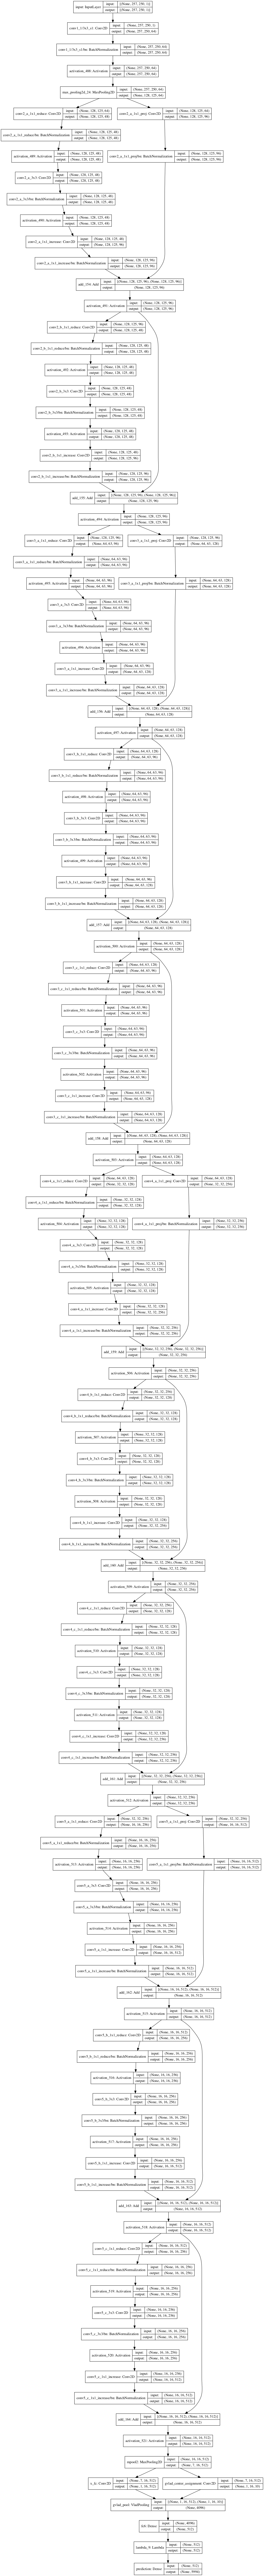

In [139]:
keras.utils.plot_model(model, "gvlad.png", show_shapes=True)


### Am-Softmax Loss Function

In [140]:
def amsoftmax_loss(y_true, y_pred, scale=30, margin=0.35):
    y_pred = y_true * (y_pred - margin) + (1 - y_true) * y_pred
    y_pred *= scale
    return K.categorical_crossentropy(y_true, y_pred, from_logits=True)

### Build Model

In [ ]:
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    params["init_learning_rate"], 
    params["decay_steps"], 
    params["decay_rate"], 
    staircase=params["staircase"])

params["lr"] = learning_rate

optimizer = tf.keras.optimizers.Adam(params["lr"])

train_acc_metric = tf.keras.metrics.Accuracy()

In [ ]:
@tf.function
def train_step(x,y):
    
    with tf.GradientTape() as tape:
                
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
                
    grads = tape.gradient(loss_value, model.trainable_weights)
            
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    train_acc_metric.update_state(y, logits)
    
    
    return loss_value
    

def train(producer):
    print("Begin training...")
    for epoch in range(params['epochs']):

        for step, (inputs, labels) in enumerate(producer.iterator()):

            loss_value = train_step(inputs, labels)


        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))

            
        train_acc = train_acc_metric.result()    
        print("Training acc over epoch: %.4f" % (float(train_acc),))
            
        # Reset training metrics at the end of each epoch
        train_acc_metric.reset_states()
        
        # Run a validation loop at the end of each epoch.
        for x_batch_val, y_batch_val in val_dataset:
            test_step(x_batch_val, y_batch_val)

        val_acc = val_acc_metric.result()
        val_acc_metric.reset_states()
        print("Validation acc: %.4f" % (float(val_acc),))
        print("Time taken: %.2fs" % (time.time() - start_time))


In [141]:
def build_train(model, args):
    
    loss=args.loss
        
    if loss == 'softmax':
        trnloss = 'categorical_crossentropy'

    elif loss == 'amsoftmax':
        trnloss = amsoftmax_loss

    else:
        raise IOError('==> unknown loss.')
        
    mgpu = len(K._get_available_gpus())
    
    if mgpu > 1:
        model = ModelMGPU(model, gpus=mgpu)
    # set up optimizer.
    if args["optimizer"] == 'adam':  opt = keras.optimizers.Adam(args["lr"])
    elif args["optimizer"] =='sgd':  opt = keras.optimizers.SGD(lr=0.1, momentum=args["momentum"], decay=0.0, nesterov=True)
    else: raise IOError('==> unknown optimizer type')

    model.compile(optimizer=opt, loss=trnloss, metrics=['acc'])
    
    return model

### Test Load Data

In [4]:
producer = audio_producer.AudioProducer(params['json_path'], params['batch_size'],
                                        sample_rate=params['sample_rate'],
                                        min_duration=params['min_duration'],
                                        max_duration=params['max_duration'])

In [6]:
for inputs, labels in producer.iterator():
    print(inputs.shape, len(labels))
    break

(256, 257, 125, 1) 256


# Embedded Generation and Evaluation

### GPU initialization

In [144]:
def initialize_GPU(args):
    # Initialize GPUs
    import tensorflow as tf
    os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

### Data Functions

In [157]:
def load_wav(vid_path, sr):
    wav, sr_ret = librosa.load(vid_path, sr=sr)
    assert sr_ret == sr

    intervals = librosa.effects.split(wav, top_db=20)
    wav_output = []
    for sliced in intervals:
        wav_output.extend(wav[sliced[0]:sliced[1]])
    wav_output = np.array(wav_output)
    return wav_output

def lin_spectogram_from_wav(wav, hop_length, win_length, n_fft=1024):
    linear = librosa.stft(wav, n_fft=n_fft, win_length=win_length, hop_length=hop_length) # linear spectrogram
    return linear.T

def load_data(path, split=False, win_length=400, sr=16000, hop_length=160, n_fft=512, min_slice=720):
    wav = load_wav(path, sr=sr)
    linear_spect = lin_spectogram_from_wav(wav, hop_length, win_length, n_fft)
    mag, _ = librosa.magphase(linear_spect)  # magnitude
    mag_T = mag.T
    freq, time = mag_T.shape
    spec_mag = mag_T

    utterances_spec = []

    if(split):
        minSpec = min_slice//(1000//(sr//hop_length)) # The minimum timestep of each slice in spectrum
        randStarts = np.random.randint(0,time, 10)   # generate 10 slices at most.
        for start in randStarts:
            if(time-start<=minSpec):
                continue
            randDuration = np.random.randint(minSpec, time-start)
            spec_mag = mag_T[:, start:start+randDuration]

            # preprocessing, subtract mean, divided by time-wise var
            mu = np.mean(spec_mag, 0, keepdims=True)
            std = np.std(spec_mag, 0, keepdims=True)
            spec_mag = (spec_mag - mu) / (std + 1e-5)
            utterances_spec.append(spec_mag)

    else:
        # preprocessing, subtract mean, divided by time-wise var
        mu = np.mean(spec_mag, 0, keepdims=True)
        std = np.std(spec_mag, 0, keepdims=True)
        spec_mag = (spec_mag - mu) / (std + 1e-5)
        utterances_spec.append(spec_mag)

    return utterances_spec

def prepare_data(SRC_PATH):
    wavDir = os.listdir(SRC_PATH)
    wavDir.sort()

    allpath_list = []
    allspk_list = []
    for i,spkDir in enumerate(wavDir):   # Each speaker's directory
        spk = spkDir    # speaker name
        wavPath = os.path.join(SRC_PATH, spkDir, 'audio')
        for wav in os.listdir(wavPath): # wavfile
            utter_path = os.path.join(wavPath, wav)
            allpath_list.append(utter_path)
            allspk_list.append(i)
        if(i>100):
            break

    path_spk_list = list(zip(allpath_list, allspk_list))
    return path_spk_list

## Load Model

In [ ]:

def loadModel(params)

    # ==================================
    #       Get Model
    # ==================================
    # construct the data generator.


    network_eval = GVladModel(input_dim=params['dim'],
                              num_class=params['n_classes'],
                              mode='eval', args=params)

    # ==> load pre-trained model ???
    if args.resume:
        # ==> get real_model from arguments input,
        # load the model if the imag_model == real_model.
        if os.path.isfile(params["resume"]):
            network_eval.load_weights(os.path.join(params["resume"]), by_name=True)
            print('==> successfully loading model {}.'.format(params["resume"]))
        else:
            raise IOError("==> no checkpoint found at '{}'".format(params["resume"]))
    else:
        raise IOError('==> please type in the model to load')
    
    return network_eval

## Embedded


In [ ]:
# gpu configuration
#toolkits.initialize_GPU(args)

# ==================================
#       Get Train/Val.
# ==================================

total_list = [os.path.join(args.data_path, file) for file in os.listdir(args.data_path)]
unique_list = np.unique(total_list)

network_eval = loadModel(params)

# The feature extraction process has to be done sample-by-sample,
# because each sample is of different lengths.

SRC_PATH = r'/data/dataset/SpkWav120'
path_spk_tuples = prepare_data(SRC_PATH)
train_sequence = []
train_cluster_id = []

for epoch in range(7000): # Random choice utterances from whole wavfiles
    # A merged utterance contains [10,20] utterances
    splits_count = np.random.randint(10, 20, 1)
    path_spks = random.sample(path_spk_tuples, splits_count[0])
    utterance_specs, utterance_speakers = load_data(path_spks, min_win_time=500, max_win_time=1600)
    feats = []
    for spec in utterance_specs:
        spec = np.expand_dims(np.expand_dims(spec, 0), -1)
        v = network_eval.predict(spec)
        feats += [v]

    feats = np.array(feats)[:,0,:]  # [splits, embedding dim]
    train_sequence.append(feats)
    train_cluster_id.append(utterance_speakers)
    print("epoch:{}, utterance length: {}, speakers: {}".format(epoch, len(utterance_speakers), len(path_spks)))

np.savez('training_data', train_sequence=train_sequence, train_cluster_id=train_cluster_id)

### Similarity Function

In [158]:
def similar(matrix):  # calc speaker-embeddings similarity in pretty format output.
    ids = matrix.shape[0]
    for i in range(ids):
        for j in range(ids):
            dist = matrix[i,:]*matrix[j,:]
            dist = np.linalg.norm(matrix[i,:] - matrix[j,:])
            print('%.2f  ' % dist, end='')
            if((j+1)%3==0 and j!=0):
                print("| ", end='')
        if((i+1)%3==0 and i!=0):
            print('\n')
            print("*"*80, end='')
        print("\n")

### Eval Process

In [159]:

# ==================================
#       Get Train/Val.
# ==================================

total_list = [os.path.join(params["data_path"], file) for file in os.listdir(params["data_path"])]
unique_list = np.unique(total_list)

# ==================================
#       Get Model
# ==================================
# construct the data generator.


network_eval = loadModel(params)

# The feature extraction process has to be done sample-by-sample,
# because each sample is of different lengths.
feats = []
for ID in unique_list:
    specs = load_data(ID, split=False, win_length=params['win_length'], sr=params['sample_rate'],
                      hop_length=params['hop_length'], n_fft=params['nfft'],
                      min_slice=params['min_slice'])
    specs = np.expand_dims(np.expand_dims(specs[0], 0), -1)

    v = network_eval.predict(specs)
    feats += [v]

feats = np.array(feats)[:,0,:]
print("Cinfusion Matrix...")
similar(feats)

==> successfully loading model pretrained/weights.h5.
==> start testing.
0.00  0.32  0.41  | 0.74  0.63  0.79  | 0.80  0.82  0.77  | 0.92  0.83  0.88  | 

0.32  0.00  0.47  | 0.72  0.59  0.78  | 0.85  0.85  0.84  | 0.92  0.83  0.85  | 

0.41  0.47  0.00  | 0.75  0.69  0.77  | 0.81  0.84  0.77  | 0.90  0.85  0.85  | 

********************************************************************************

0.74  0.72  0.75  | 0.00  0.43  0.32  | 0.77  0.83  0.80  | 0.80  0.84  0.82  | 

0.63  0.59  0.69  | 0.43  0.00  0.50  | 0.76  0.70  0.74  | 0.84  0.80  0.77  | 

0.79  0.78  0.77  | 0.32  0.50  0.00  | 0.83  0.85  0.84  | 0.84  0.86  0.81  | 

********************************************************************************

0.80  0.85  0.81  | 0.77  0.76  0.83  | 0.00  0.41  0.47  | 0.76  0.77  0.83  | 

0.82  0.85  0.84  | 0.83  0.70  0.85  | 0.41  0.00  0.44  | 0.79  0.76  0.81  | 

0.77  0.84  0.77  | 0.80  0.74  0.84  | 0.47  0.44  0.00  | 0.87  0.85  0.85  | 

*************************

In [3]:
f = "/Users/dirceusilva/Documentos/BaseDados/VoxCeleb2/dev/aac/id00012/yi_qz725MjE/00164.m4a" 
feature_dir="/Users/dirceusilva/Documentos/tests/VoxCeleb2/features_dev/aac/"

In [4]:
import audio_producer
producer = audio_producer.FeatureExtractor(params['json_path'],
                                           feature_dir=feature_dir,
                                           batch_size=64,
                                           sample_rate=params['sample_rate'],
                                           min_duration=params['min_duration'],
                                           max_duration=params['max_duration'], 
                                           parallel=True, n_workers=-1,
                                           mode = "train")

In [5]:
producer.compute_features()


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:   22.5s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   24.5s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:   26.4s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:   28.2s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:   29.8s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:   30.2s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:   30.3s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:   31.8s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   50.9s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:   54.3s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:   54.4s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:   56.9s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:  1.1min
[Parallel(

[Parallel(n_jobs=8)]: Done 135 tasks      | elapsed:  8.9min
[Parallel(n_jobs=8)]: Done 136 tasks      | elapsed:  9.0min
[Parallel(n_jobs=8)]: Done 137 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done 138 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done 139 tasks      | elapsed:  9.2min
[Parallel(n_jobs=8)]: Done 140 tasks      | elapsed:  9.2min
[Parallel(n_jobs=8)]: Done 141 tasks      | elapsed:  9.3min
[Parallel(n_jobs=8)]: Done 142 tasks      | elapsed:  9.4min
[Parallel(n_jobs=8)]: Done 143 tasks      | elapsed:  9.4min
[Parallel(n_jobs=8)]: Done 144 tasks      | elapsed:  9.5min
[Parallel(n_jobs=8)]: Done 145 tasks      | elapsed:  9.6min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  9.7min
[Parallel(n_jobs=8)]: Done 147 tasks      | elapsed:  9.7min
[Parallel(n_jobs=8)]: Done 148 tasks      | elapsed:  9.8min
[Parallel(n_jobs=8)]: Done 149 tasks      | elapsed:  9.8min
[Parallel(n_jobs=8)]: Done 150 tasks      | elapsed:  9.9min
[Parallel(n_jobs=8)]: Do

[Parallel(n_jobs=8)]: Done 270 tasks      | elapsed: 17.5min
[Parallel(n_jobs=8)]: Done 271 tasks      | elapsed: 17.6min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed: 17.7min
[Parallel(n_jobs=8)]: Done 273 tasks      | elapsed: 17.7min
[Parallel(n_jobs=8)]: Done 274 tasks      | elapsed: 17.9min
[Parallel(n_jobs=8)]: Done 275 tasks      | elapsed: 17.9min
[Parallel(n_jobs=8)]: Done 276 tasks      | elapsed: 17.9min
[Parallel(n_jobs=8)]: Done 277 tasks      | elapsed: 18.0min
[Parallel(n_jobs=8)]: Done 278 tasks      | elapsed: 18.0min
[Parallel(n_jobs=8)]: Done 279 tasks      | elapsed: 18.1min
[Parallel(n_jobs=8)]: Done 280 tasks      | elapsed: 18.2min
[Parallel(n_jobs=8)]: Done 281 tasks      | elapsed: 18.2min
[Parallel(n_jobs=8)]: Done 282 tasks      | elapsed: 18.4min
[Parallel(n_jobs=8)]: Done 283 tasks      | elapsed: 18.4min
[Parallel(n_jobs=8)]: Done 284 tasks      | elapsed: 18.5min
[Parallel(n_jobs=8)]: Done 285 tasks      | elapsed: 18.5min
[Parallel(n_jobs=8)]: Do

[Parallel(n_jobs=8)]: Done 405 tasks      | elapsed: 26.1min
[Parallel(n_jobs=8)]: Done 406 tasks      | elapsed: 26.1min
[Parallel(n_jobs=8)]: Done 407 tasks      | elapsed: 26.2min
[Parallel(n_jobs=8)]: Done 408 tasks      | elapsed: 26.2min
[Parallel(n_jobs=8)]: Done 409 tasks      | elapsed: 26.3min
[Parallel(n_jobs=8)]: Done 410 tasks      | elapsed: 26.4min
[Parallel(n_jobs=8)]: Done 411 tasks      | elapsed: 26.5min
[Parallel(n_jobs=8)]: Done 412 tasks      | elapsed: 26.5min
[Parallel(n_jobs=8)]: Done 413 tasks      | elapsed: 26.6min
[Parallel(n_jobs=8)]: Done 414 tasks      | elapsed: 26.7min
[Parallel(n_jobs=8)]: Done 415 tasks      | elapsed: 26.7min
[Parallel(n_jobs=8)]: Done 416 tasks      | elapsed: 26.7min
[Parallel(n_jobs=8)]: Done 417 tasks      | elapsed: 26.8min
[Parallel(n_jobs=8)]: Done 418 tasks      | elapsed: 26.9min
[Parallel(n_jobs=8)]: Done 419 tasks      | elapsed: 27.0min
[Parallel(n_jobs=8)]: Done 420 tasks      | elapsed: 27.0min
[Parallel(n_jobs=8)]: Do

[Parallel(n_jobs=8)]: Done 540 tasks      | elapsed: 34.6min
[Parallel(n_jobs=8)]: Done 541 tasks      | elapsed: 34.7min
[Parallel(n_jobs=8)]: Done 542 tasks      | elapsed: 34.8min
[Parallel(n_jobs=8)]: Done 543 tasks      | elapsed: 34.8min
[Parallel(n_jobs=8)]: Done 544 tasks      | elapsed: 34.8min
[Parallel(n_jobs=8)]: Done 545 tasks      | elapsed: 34.9min
[Parallel(n_jobs=8)]: Done 546 tasks      | elapsed: 35.0min
[Parallel(n_jobs=8)]: Done 547 tasks      | elapsed: 35.1min
[Parallel(n_jobs=8)]: Done 548 tasks      | elapsed: 35.1min
[Parallel(n_jobs=8)]: Done 549 tasks      | elapsed: 35.2min
[Parallel(n_jobs=8)]: Done 550 tasks      | elapsed: 35.2min
[Parallel(n_jobs=8)]: Done 551 tasks      | elapsed: 35.3min
[Parallel(n_jobs=8)]: Done 552 tasks      | elapsed: 35.4min
[Parallel(n_jobs=8)]: Done 553 tasks      | elapsed: 35.4min
[Parallel(n_jobs=8)]: Done 554 tasks      | elapsed: 35.6min
[Parallel(n_jobs=8)]: Done 555 tasks      | elapsed: 35.6min
[Parallel(n_jobs=8)]: Do

[Parallel(n_jobs=8)]: Done 675 tasks      | elapsed: 43.2min
[Parallel(n_jobs=8)]: Done 676 tasks      | elapsed: 43.2min
[Parallel(n_jobs=8)]: Done 677 tasks      | elapsed: 43.2min
[Parallel(n_jobs=8)]: Done 678 tasks      | elapsed: 43.4min
[Parallel(n_jobs=8)]: Done 679 tasks      | elapsed: 43.4min
[Parallel(n_jobs=8)]: Done 680 tasks      | elapsed: 43.5min
[Parallel(n_jobs=8)]: Done 681 tasks      | elapsed: 43.5min
[Parallel(n_jobs=8)]: Done 682 tasks      | elapsed: 43.6min
[Parallel(n_jobs=8)]: Done 683 tasks      | elapsed: 43.7min
[Parallel(n_jobs=8)]: Done 684 tasks      | elapsed: 43.7min
[Parallel(n_jobs=8)]: Done 685 tasks      | elapsed: 43.7min
[Parallel(n_jobs=8)]: Done 686 tasks      | elapsed: 43.9min
[Parallel(n_jobs=8)]: Done 687 tasks      | elapsed: 44.0min
[Parallel(n_jobs=8)]: Done 688 tasks      | elapsed: 44.0min
[Parallel(n_jobs=8)]: Done 689 tasks      | elapsed: 44.0min
[Parallel(n_jobs=8)]: Done 690 tasks      | elapsed: 44.1min
[Parallel(n_jobs=8)]: Do

[Parallel(n_jobs=8)]: Done 810 tasks      | elapsed: 51.5min
[Parallel(n_jobs=8)]: Done 811 tasks      | elapsed: 51.6min
[Parallel(n_jobs=8)]: Done 812 tasks      | elapsed: 51.7min
[Parallel(n_jobs=8)]: Done 813 tasks      | elapsed: 51.8min
[Parallel(n_jobs=8)]: Done 814 tasks      | elapsed: 51.9min
[Parallel(n_jobs=8)]: Done 815 tasks      | elapsed: 52.0min
[Parallel(n_jobs=8)]: Done 816 tasks      | elapsed: 52.0min
[Parallel(n_jobs=8)]: Done 817 tasks      | elapsed: 52.0min
[Parallel(n_jobs=8)]: Done 818 tasks      | elapsed: 52.0min
[Parallel(n_jobs=8)]: Done 819 tasks      | elapsed: 52.1min
[Parallel(n_jobs=8)]: Done 820 tasks      | elapsed: 52.1min
[Parallel(n_jobs=8)]: Done 821 tasks      | elapsed: 52.3min
[Parallel(n_jobs=8)]: Done 822 tasks      | elapsed: 52.4min
[Parallel(n_jobs=8)]: Done 823 tasks      | elapsed: 52.5min
[Parallel(n_jobs=8)]: Done 824 tasks      | elapsed: 52.5min
[Parallel(n_jobs=8)]: Done 825 tasks      | elapsed: 52.6min
[Parallel(n_jobs=8)]: Do

[Parallel(n_jobs=8)]: Done 945 tasks      | elapsed: 60.1min
[Parallel(n_jobs=8)]: Done 946 tasks      | elapsed: 60.1min
[Parallel(n_jobs=8)]: Done 947 tasks      | elapsed: 60.2min
[Parallel(n_jobs=8)]: Done 948 tasks      | elapsed: 60.3min
[Parallel(n_jobs=8)]: Done 949 tasks      | elapsed: 60.3min
[Parallel(n_jobs=8)]: Done 950 tasks      | elapsed: 60.4min
[Parallel(n_jobs=8)]: Done 951 tasks      | elapsed: 60.5min
[Parallel(n_jobs=8)]: Done 952 tasks      | elapsed: 60.6min
[Parallel(n_jobs=8)]: Done 953 tasks      | elapsed: 60.6min
[Parallel(n_jobs=8)]: Done 954 tasks      | elapsed: 60.7min
[Parallel(n_jobs=8)]: Done 955 tasks      | elapsed: 60.7min
[Parallel(n_jobs=8)]: Done 956 tasks      | elapsed: 60.8min
[Parallel(n_jobs=8)]: Done 957 tasks      | elapsed: 60.8min
[Parallel(n_jobs=8)]: Done 958 tasks      | elapsed: 60.9min
[Parallel(n_jobs=8)]: Done 959 tasks      | elapsed: 61.0min
[Parallel(n_jobs=8)]: Done 960 tasks      | elapsed: 61.1min
[Parallel(n_jobs=8)]: Do

[Parallel(n_jobs=8)]: Done 1079 tasks      | elapsed: 68.0min
[Parallel(n_jobs=8)]: Done 1080 tasks      | elapsed: 68.2min
[Parallel(n_jobs=8)]: Done 1081 tasks      | elapsed: 68.2min
[Parallel(n_jobs=8)]: Done 1082 tasks      | elapsed: 68.3min
[Parallel(n_jobs=8)]: Done 1083 tasks      | elapsed: 68.4min
[Parallel(n_jobs=8)]: Done 1084 tasks      | elapsed: 68.4min
[Parallel(n_jobs=8)]: Done 1085 tasks      | elapsed: 68.4min
[Parallel(n_jobs=8)]: Done 1086 tasks      | elapsed: 68.5min
[Parallel(n_jobs=8)]: Done 1087 tasks      | elapsed: 68.5min
[Parallel(n_jobs=8)]: Done 1088 tasks      | elapsed: 68.6min
[Parallel(n_jobs=8)]: Done 1089 tasks      | elapsed: 68.7min
[Parallel(n_jobs=8)]: Done 1090 tasks      | elapsed: 68.7min
[Parallel(n_jobs=8)]: Done 1091 tasks      | elapsed: 68.8min
[Parallel(n_jobs=8)]: Done 1092 tasks      | elapsed: 68.9min
[Parallel(n_jobs=8)]: Done 1093 tasks      | elapsed: 68.9min
[Parallel(n_jobs=8)]: Done 1094 tasks      | elapsed: 68.9min
[Paralle

[Parallel(n_jobs=8)]: Done 1212 tasks      | elapsed: 75.8min
[Parallel(n_jobs=8)]: Done 1213 tasks      | elapsed: 75.9min
[Parallel(n_jobs=8)]: Done 1214 tasks      | elapsed: 76.0min
[Parallel(n_jobs=8)]: Done 1215 tasks      | elapsed: 76.0min
[Parallel(n_jobs=8)]: Done 1216 tasks      | elapsed: 76.1min
[Parallel(n_jobs=8)]: Done 1217 tasks      | elapsed: 76.2min
[Parallel(n_jobs=8)]: Done 1218 tasks      | elapsed: 76.2min
[Parallel(n_jobs=8)]: Done 1219 tasks      | elapsed: 76.3min
[Parallel(n_jobs=8)]: Done 1220 tasks      | elapsed: 76.3min
[Parallel(n_jobs=8)]: Done 1221 tasks      | elapsed: 76.4min
[Parallel(n_jobs=8)]: Done 1222 tasks      | elapsed: 76.4min
[Parallel(n_jobs=8)]: Done 1223 tasks      | elapsed: 76.4min
[Parallel(n_jobs=8)]: Done 1224 tasks      | elapsed: 76.5min
[Parallel(n_jobs=8)]: Done 1225 tasks      | elapsed: 76.7min
[Parallel(n_jobs=8)]: Done 1226 tasks      | elapsed: 76.7min
[Parallel(n_jobs=8)]: Done 1227 tasks      | elapsed: 76.7min
[Paralle

[Parallel(n_jobs=8)]: Done 1345 tasks      | elapsed: 83.5min
[Parallel(n_jobs=8)]: Done 1346 tasks      | elapsed: 83.7min
[Parallel(n_jobs=8)]: Done 1347 tasks      | elapsed: 83.7min
[Parallel(n_jobs=8)]: Done 1348 tasks      | elapsed: 83.8min
[Parallel(n_jobs=8)]: Done 1349 tasks      | elapsed: 83.8min
[Parallel(n_jobs=8)]: Done 1350 tasks      | elapsed: 83.9min
[Parallel(n_jobs=8)]: Done 1351 tasks      | elapsed: 84.0min
[Parallel(n_jobs=8)]: Done 1352 tasks      | elapsed: 84.0min
[Parallel(n_jobs=8)]: Done 1353 tasks      | elapsed: 84.0min
[Parallel(n_jobs=8)]: Done 1354 tasks      | elapsed: 84.1min
[Parallel(n_jobs=8)]: Done 1355 tasks      | elapsed: 84.2min
[Parallel(n_jobs=8)]: Done 1356 tasks      | elapsed: 84.2min
[Parallel(n_jobs=8)]: Done 1357 tasks      | elapsed: 84.3min
[Parallel(n_jobs=8)]: Done 1358 tasks      | elapsed: 84.3min
[Parallel(n_jobs=8)]: Done 1359 tasks      | elapsed: 84.4min
[Parallel(n_jobs=8)]: Done 1360 tasks      | elapsed: 84.5min
[Paralle

[Parallel(n_jobs=8)]: Done 1478 tasks      | elapsed: 91.4min
[Parallel(n_jobs=8)]: Done 1479 tasks      | elapsed: 91.5min
[Parallel(n_jobs=8)]: Done 1480 tasks      | elapsed: 91.5min
[Parallel(n_jobs=8)]: Done 1481 tasks      | elapsed: 91.6min
[Parallel(n_jobs=8)]: Done 1482 tasks      | elapsed: 91.6min
[Parallel(n_jobs=8)]: Done 1483 tasks      | elapsed: 91.6min
[Parallel(n_jobs=8)]: Done 1484 tasks      | elapsed: 91.7min
[Parallel(n_jobs=8)]: Done 1485 tasks      | elapsed: 91.7min
[Parallel(n_jobs=8)]: Done 1486 tasks      | elapsed: 91.8min
[Parallel(n_jobs=8)]: Done 1487 tasks      | elapsed: 91.9min
[Parallel(n_jobs=8)]: Done 1488 tasks      | elapsed: 91.9min
[Parallel(n_jobs=8)]: Done 1489 tasks      | elapsed: 92.0min
[Parallel(n_jobs=8)]: Done 1490 tasks      | elapsed: 92.0min
[Parallel(n_jobs=8)]: Done 1491 tasks      | elapsed: 92.1min
[Parallel(n_jobs=8)]: Done 1492 tasks      | elapsed: 92.1min
[Parallel(n_jobs=8)]: Done 1493 tasks      | elapsed: 92.2min
[Paralle

[Parallel(n_jobs=8)]: Done 1611 tasks      | elapsed: 99.4min
[Parallel(n_jobs=8)]: Done 1612 tasks      | elapsed: 99.5min
[Parallel(n_jobs=8)]: Done 1613 tasks      | elapsed: 99.5min
[Parallel(n_jobs=8)]: Done 1614 tasks      | elapsed: 99.5min
[Parallel(n_jobs=8)]: Done 1615 tasks      | elapsed: 99.6min
[Parallel(n_jobs=8)]: Done 1616 tasks      | elapsed: 99.8min
[Parallel(n_jobs=8)]: Done 1617 tasks      | elapsed: 99.8min
[Parallel(n_jobs=8)]: Done 1618 tasks      | elapsed: 99.9min
[Parallel(n_jobs=8)]: Done 1619 tasks      | elapsed: 100.0min
[Parallel(n_jobs=8)]: Done 1620 tasks      | elapsed: 100.1min
[Parallel(n_jobs=8)]: Done 1621 tasks      | elapsed: 100.1min
[Parallel(n_jobs=8)]: Done 1622 tasks      | elapsed: 100.1min
[Parallel(n_jobs=8)]: Done 1623 tasks      | elapsed: 100.2min
[Parallel(n_jobs=8)]: Done 1624 tasks      | elapsed: 100.3min
[Parallel(n_jobs=8)]: Done 1625 tasks      | elapsed: 100.4min
[Parallel(n_jobs=8)]: Done 1626 tasks      | elapsed: 100.5min


[Parallel(n_jobs=8)]: Done 1742 tasks      | elapsed: 105.4min
[Parallel(n_jobs=8)]: Done 1743 tasks      | elapsed: 105.4min
[Parallel(n_jobs=8)]: Done 1744 tasks      | elapsed: 105.5min
[Parallel(n_jobs=8)]: Done 1745 tasks      | elapsed: 105.5min
[Parallel(n_jobs=8)]: Done 1746 tasks      | elapsed: 105.5min
[Parallel(n_jobs=8)]: Done 1747 tasks      | elapsed: 105.6min
[Parallel(n_jobs=8)]: Done 1748 tasks      | elapsed: 105.6min
[Parallel(n_jobs=8)]: Done 1749 tasks      | elapsed: 105.6min
[Parallel(n_jobs=8)]: Done 1750 tasks      | elapsed: 105.6min
[Parallel(n_jobs=8)]: Done 1751 tasks      | elapsed: 105.7min
[Parallel(n_jobs=8)]: Done 1752 tasks      | elapsed: 105.7min
[Parallel(n_jobs=8)]: Done 1753 tasks      | elapsed: 105.7min
[Parallel(n_jobs=8)]: Done 1754 tasks      | elapsed: 105.8min
[Parallel(n_jobs=8)]: Done 1755 tasks      | elapsed: 105.8min
[Parallel(n_jobs=8)]: Done 1756 tasks      | elapsed: 105.8min
[Parallel(n_jobs=8)]: Done 1757 tasks      | elapsed: 1

[Parallel(n_jobs=8)]: Done 1873 tasks      | elapsed: 109.9min
[Parallel(n_jobs=8)]: Done 1874 tasks      | elapsed: 109.9min
[Parallel(n_jobs=8)]: Done 1875 tasks      | elapsed: 109.9min
[Parallel(n_jobs=8)]: Done 1876 tasks      | elapsed: 110.0min
[Parallel(n_jobs=8)]: Done 1877 tasks      | elapsed: 110.0min
[Parallel(n_jobs=8)]: Done 1878 tasks      | elapsed: 110.0min
[Parallel(n_jobs=8)]: Done 1879 tasks      | elapsed: 110.1min
[Parallel(n_jobs=8)]: Done 1880 tasks      | elapsed: 110.1min
[Parallel(n_jobs=8)]: Done 1881 tasks      | elapsed: 110.1min
[Parallel(n_jobs=8)]: Done 1882 tasks      | elapsed: 110.2min
[Parallel(n_jobs=8)]: Done 1883 tasks      | elapsed: 110.2min
[Parallel(n_jobs=8)]: Done 1884 tasks      | elapsed: 110.2min
[Parallel(n_jobs=8)]: Done 1885 tasks      | elapsed: 110.3min
[Parallel(n_jobs=8)]: Done 1886 tasks      | elapsed: 110.3min
[Parallel(n_jobs=8)]: Done 1887 tasks      | elapsed: 110.3min
[Parallel(n_jobs=8)]: Done 1888 tasks      | elapsed: 1

[Parallel(n_jobs=8)]: Done 2004 tasks      | elapsed: 114.5min
[Parallel(n_jobs=8)]: Done 2005 tasks      | elapsed: 114.5min
[Parallel(n_jobs=8)]: Done 2006 tasks      | elapsed: 114.6min
[Parallel(n_jobs=8)]: Done 2007 tasks      | elapsed: 114.6min
[Parallel(n_jobs=8)]: Done 2008 tasks      | elapsed: 114.6min
[Parallel(n_jobs=8)]: Done 2009 tasks      | elapsed: 114.7min
[Parallel(n_jobs=8)]: Done 2010 tasks      | elapsed: 114.7min
[Parallel(n_jobs=8)]: Done 2011 tasks      | elapsed: 114.8min
[Parallel(n_jobs=8)]: Done 2012 tasks      | elapsed: 114.8min
[Parallel(n_jobs=8)]: Done 2013 tasks      | elapsed: 114.8min
[Parallel(n_jobs=8)]: Done 2014 tasks      | elapsed: 114.8min
[Parallel(n_jobs=8)]: Done 2015 tasks      | elapsed: 114.9min
[Parallel(n_jobs=8)]: Done 2016 tasks      | elapsed: 114.9min
[Parallel(n_jobs=8)]: Done 2017 tasks      | elapsed: 115.0min
[Parallel(n_jobs=8)]: Done 2018 tasks      | elapsed: 115.0min
[Parallel(n_jobs=8)]: Done 2019 tasks      | elapsed: 1

[Parallel(n_jobs=8)]: Done 2135 tasks      | elapsed: 119.1min
[Parallel(n_jobs=8)]: Done 2136 tasks      | elapsed: 119.1min
[Parallel(n_jobs=8)]: Done 2137 tasks      | elapsed: 119.1min
[Parallel(n_jobs=8)]: Done 2138 tasks      | elapsed: 119.2min
[Parallel(n_jobs=8)]: Done 2139 tasks      | elapsed: 119.2min
[Parallel(n_jobs=8)]: Done 2140 tasks      | elapsed: 119.2min
[Parallel(n_jobs=8)]: Done 2141 tasks      | elapsed: 119.3min
[Parallel(n_jobs=8)]: Done 2142 tasks      | elapsed: 119.3min
[Parallel(n_jobs=8)]: Done 2143 tasks      | elapsed: 119.3min
[Parallel(n_jobs=8)]: Done 2144 tasks      | elapsed: 119.4min
[Parallel(n_jobs=8)]: Done 2145 tasks      | elapsed: 119.4min
[Parallel(n_jobs=8)]: Done 2146 tasks      | elapsed: 119.4min
[Parallel(n_jobs=8)]: Done 2147 tasks      | elapsed: 119.5min
[Parallel(n_jobs=8)]: Done 2148 tasks      | elapsed: 119.5min
[Parallel(n_jobs=8)]: Done 2149 tasks      | elapsed: 119.5min
[Parallel(n_jobs=8)]: Done 2150 tasks      | elapsed: 1

[Parallel(n_jobs=8)]: Done 2266 tasks      | elapsed: 123.7min
[Parallel(n_jobs=8)]: Done 2267 tasks      | elapsed: 123.8min
[Parallel(n_jobs=8)]: Done 2268 tasks      | elapsed: 123.8min
[Parallel(n_jobs=8)]: Done 2269 tasks      | elapsed: 123.8min
[Parallel(n_jobs=8)]: Done 2270 tasks      | elapsed: 123.9min
[Parallel(n_jobs=8)]: Done 2271 tasks      | elapsed: 123.9min
[Parallel(n_jobs=8)]: Done 2272 tasks      | elapsed: 123.9min
[Parallel(n_jobs=8)]: Done 2273 tasks      | elapsed: 123.9min
[Parallel(n_jobs=8)]: Done 2274 tasks      | elapsed: 124.0min
[Parallel(n_jobs=8)]: Done 2275 tasks      | elapsed: 124.0min
[Parallel(n_jobs=8)]: Done 2276 tasks      | elapsed: 124.0min
[Parallel(n_jobs=8)]: Done 2277 tasks      | elapsed: 124.0min
[Parallel(n_jobs=8)]: Done 2278 tasks      | elapsed: 124.1min
[Parallel(n_jobs=8)]: Done 2279 tasks      | elapsed: 124.1min
[Parallel(n_jobs=8)]: Done 2280 tasks      | elapsed: 124.1min
[Parallel(n_jobs=8)]: Done 2281 tasks      | elapsed: 1

[Parallel(n_jobs=8)]: Done 2397 tasks      | elapsed: 127.5min
[Parallel(n_jobs=8)]: Done 2398 tasks      | elapsed: 127.6min
[Parallel(n_jobs=8)]: Done 2399 tasks      | elapsed: 127.6min
[Parallel(n_jobs=8)]: Done 2400 tasks      | elapsed: 127.6min
[Parallel(n_jobs=8)]: Done 2401 tasks      | elapsed: 127.7min
[Parallel(n_jobs=8)]: Done 2402 tasks      | elapsed: 127.7min
[Parallel(n_jobs=8)]: Done 2403 tasks      | elapsed: 127.7min
[Parallel(n_jobs=8)]: Done 2404 tasks      | elapsed: 127.7min
[Parallel(n_jobs=8)]: Done 2405 tasks      | elapsed: 127.8min
[Parallel(n_jobs=8)]: Done 2406 tasks      | elapsed: 127.8min
[Parallel(n_jobs=8)]: Done 2407 tasks      | elapsed: 127.8min
[Parallel(n_jobs=8)]: Done 2408 tasks      | elapsed: 127.9min
[Parallel(n_jobs=8)]: Done 2409 tasks      | elapsed: 127.9min
[Parallel(n_jobs=8)]: Done 2410 tasks      | elapsed: 127.9min
[Parallel(n_jobs=8)]: Done 2411 tasks      | elapsed: 127.9min
[Parallel(n_jobs=8)]: Done 2412 tasks      | elapsed: 1

[Parallel(n_jobs=8)]: Done 2528 tasks      | elapsed: 131.3min
[Parallel(n_jobs=8)]: Done 2529 tasks      | elapsed: 131.3min
[Parallel(n_jobs=8)]: Done 2530 tasks      | elapsed: 131.4min
[Parallel(n_jobs=8)]: Done 2531 tasks      | elapsed: 131.4min
[Parallel(n_jobs=8)]: Done 2532 tasks      | elapsed: 131.4min
[Parallel(n_jobs=8)]: Done 2533 tasks      | elapsed: 131.4min
[Parallel(n_jobs=8)]: Done 2534 tasks      | elapsed: 131.5min
[Parallel(n_jobs=8)]: Done 2535 tasks      | elapsed: 131.5min
[Parallel(n_jobs=8)]: Done 2536 tasks      | elapsed: 131.5min
[Parallel(n_jobs=8)]: Done 2537 tasks      | elapsed: 131.6min
[Parallel(n_jobs=8)]: Done 2538 tasks      | elapsed: 131.6min
[Parallel(n_jobs=8)]: Done 2539 tasks      | elapsed: 131.6min
[Parallel(n_jobs=8)]: Done 2540 tasks      | elapsed: 131.6min
[Parallel(n_jobs=8)]: Done 2541 tasks      | elapsed: 131.7min
[Parallel(n_jobs=8)]: Done 2542 tasks      | elapsed: 131.7min
[Parallel(n_jobs=8)]: Done 2543 tasks      | elapsed: 1

[Parallel(n_jobs=8)]: Done 2659 tasks      | elapsed: 137.5min
[Parallel(n_jobs=8)]: Done 2660 tasks      | elapsed: 137.5min
[Parallel(n_jobs=8)]: Done 2661 tasks      | elapsed: 137.6min
[Parallel(n_jobs=8)]: Done 2662 tasks      | elapsed: 137.8min
[Parallel(n_jobs=8)]: Done 2663 tasks      | elapsed: 137.8min
[Parallel(n_jobs=8)]: Done 2664 tasks      | elapsed: 137.8min
[Parallel(n_jobs=8)]: Done 2665 tasks      | elapsed: 137.9min
[Parallel(n_jobs=8)]: Done 2666 tasks      | elapsed: 138.0min
[Parallel(n_jobs=8)]: Done 2667 tasks      | elapsed: 138.0min
[Parallel(n_jobs=8)]: Done 2668 tasks      | elapsed: 138.0min
[Parallel(n_jobs=8)]: Done 2669 tasks      | elapsed: 138.0min
[Parallel(n_jobs=8)]: Done 2670 tasks      | elapsed: 138.2min
[Parallel(n_jobs=8)]: Done 2671 tasks      | elapsed: 138.3min
[Parallel(n_jobs=8)]: Done 2672 tasks      | elapsed: 138.3min
[Parallel(n_jobs=8)]: Done 2673 tasks      | elapsed: 138.4min
[Parallel(n_jobs=8)]: Done 2674 tasks      | elapsed: 1

[Parallel(n_jobs=8)]: Done 2790 tasks      | elapsed: 145.1min
[Parallel(n_jobs=8)]: Done 2791 tasks      | elapsed: 145.1min
[Parallel(n_jobs=8)]: Done 2792 tasks      | elapsed: 145.2min
[Parallel(n_jobs=8)]: Done 2793 tasks      | elapsed: 145.2min
[Parallel(n_jobs=8)]: Done 2794 tasks      | elapsed: 145.2min
[Parallel(n_jobs=8)]: Done 2795 tasks      | elapsed: 145.3min
[Parallel(n_jobs=8)]: Done 2796 tasks      | elapsed: 145.3min
[Parallel(n_jobs=8)]: Done 2797 tasks      | elapsed: 145.4min
[Parallel(n_jobs=8)]: Done 2798 tasks      | elapsed: 145.6min
[Parallel(n_jobs=8)]: Done 2799 tasks      | elapsed: 145.6min
[Parallel(n_jobs=8)]: Done 2800 tasks      | elapsed: 145.7min
[Parallel(n_jobs=8)]: Done 2801 tasks      | elapsed: 145.7min
[Parallel(n_jobs=8)]: Done 2802 tasks      | elapsed: 145.7min
[Parallel(n_jobs=8)]: Done 2803 tasks      | elapsed: 145.8min
[Parallel(n_jobs=8)]: Done 2804 tasks      | elapsed: 145.8min
[Parallel(n_jobs=8)]: Done 2805 tasks      | elapsed: 1

[Parallel(n_jobs=8)]: Done 2921 tasks      | elapsed: 152.7min
[Parallel(n_jobs=8)]: Done 2922 tasks      | elapsed: 152.7min
[Parallel(n_jobs=8)]: Done 2923 tasks      | elapsed: 152.8min
[Parallel(n_jobs=8)]: Done 2924 tasks      | elapsed: 152.9min
[Parallel(n_jobs=8)]: Done 2925 tasks      | elapsed: 152.9min
[Parallel(n_jobs=8)]: Done 2926 tasks      | elapsed: 152.9min
[Parallel(n_jobs=8)]: Done 2927 tasks      | elapsed: 153.1min
[Parallel(n_jobs=8)]: Done 2928 tasks      | elapsed: 153.1min
[Parallel(n_jobs=8)]: Done 2929 tasks      | elapsed: 153.1min
[Parallel(n_jobs=8)]: Done 2930 tasks      | elapsed: 153.2min
[Parallel(n_jobs=8)]: Done 2931 tasks      | elapsed: 153.3min
[Parallel(n_jobs=8)]: Done 2932 tasks      | elapsed: 153.3min
[Parallel(n_jobs=8)]: Done 2933 tasks      | elapsed: 153.3min
[Parallel(n_jobs=8)]: Done 2934 tasks      | elapsed: 153.4min
[Parallel(n_jobs=8)]: Done 2935 tasks      | elapsed: 153.5min
[Parallel(n_jobs=8)]: Done 2936 tasks      | elapsed: 1

[Parallel(n_jobs=8)]: Done 3053 tasks      | elapsed: 159.3min
[Parallel(n_jobs=8)]: Done 3054 tasks      | elapsed: 159.3min
[Parallel(n_jobs=8)]: Done 3055 tasks      | elapsed: 159.4min
[Parallel(n_jobs=8)]: Done 3056 tasks      | elapsed: 159.4min
[Parallel(n_jobs=8)]: Done 3057 tasks      | elapsed: 159.5min
[Parallel(n_jobs=8)]: Done 3058 tasks      | elapsed: 159.5min
[Parallel(n_jobs=8)]: Done 3059 tasks      | elapsed: 159.5min
[Parallel(n_jobs=8)]: Done 3060 tasks      | elapsed: 159.6min
[Parallel(n_jobs=8)]: Done 3061 tasks      | elapsed: 159.6min
[Parallel(n_jobs=8)]: Done 3062 tasks      | elapsed: 159.6min
[Parallel(n_jobs=8)]: Done 3063 tasks      | elapsed: 159.6min
[Parallel(n_jobs=8)]: Done 3064 tasks      | elapsed: 159.7min
[Parallel(n_jobs=8)]: Done 3065 tasks      | elapsed: 159.7min
[Parallel(n_jobs=8)]: Done 3066 tasks      | elapsed: 159.8min
[Parallel(n_jobs=8)]: Done 3067 tasks      | elapsed: 159.8min
[Parallel(n_jobs=8)]: Done 3068 tasks      | elapsed: 1

[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed: 163.6min
[Parallel(n_jobs=8)]: Done 3185 tasks      | elapsed: 163.6min
[Parallel(n_jobs=8)]: Done 3186 tasks      | elapsed: 163.7min
[Parallel(n_jobs=8)]: Done 3187 tasks      | elapsed: 163.7min
[Parallel(n_jobs=8)]: Done 3188 tasks      | elapsed: 163.7min
[Parallel(n_jobs=8)]: Done 3189 tasks      | elapsed: 163.8min
[Parallel(n_jobs=8)]: Done 3190 tasks      | elapsed: 163.8min
[Parallel(n_jobs=8)]: Done 3191 tasks      | elapsed: 163.8min
[Parallel(n_jobs=8)]: Done 3192 tasks      | elapsed: 163.9min
[Parallel(n_jobs=8)]: Done 3193 tasks      | elapsed: 163.9min
[Parallel(n_jobs=8)]: Done 3194 tasks      | elapsed: 163.9min
[Parallel(n_jobs=8)]: Done 3195 tasks      | elapsed: 164.0min
[Parallel(n_jobs=8)]: Done 3196 tasks      | elapsed: 164.0min
[Parallel(n_jobs=8)]: Done 3197 tasks      | elapsed: 164.0min
[Parallel(n_jobs=8)]: Done 3198 tasks      | elapsed: 164.1min
[Parallel(n_jobs=8)]: Done 3199 tasks      | elapsed: 1

[Parallel(n_jobs=8)]: Done 3315 tasks      | elapsed: 167.6min
[Parallel(n_jobs=8)]: Done 3316 tasks      | elapsed: 167.6min
[Parallel(n_jobs=8)]: Done 3317 tasks      | elapsed: 167.6min
[Parallel(n_jobs=8)]: Done 3318 tasks      | elapsed: 167.7min
[Parallel(n_jobs=8)]: Done 3319 tasks      | elapsed: 167.7min
[Parallel(n_jobs=8)]: Done 3320 tasks      | elapsed: 167.7min
[Parallel(n_jobs=8)]: Done 3321 tasks      | elapsed: 167.8min
[Parallel(n_jobs=8)]: Done 3322 tasks      | elapsed: 167.8min
[Parallel(n_jobs=8)]: Done 3323 tasks      | elapsed: 167.8min
[Parallel(n_jobs=8)]: Done 3324 tasks      | elapsed: 167.9min
[Parallel(n_jobs=8)]: Done 3325 tasks      | elapsed: 167.9min
[Parallel(n_jobs=8)]: Done 3326 tasks      | elapsed: 167.9min
[Parallel(n_jobs=8)]: Done 3327 tasks      | elapsed: 167.9min
[Parallel(n_jobs=8)]: Done 3328 tasks      | elapsed: 168.0min
[Parallel(n_jobs=8)]: Done 3329 tasks      | elapsed: 168.0min
[Parallel(n_jobs=8)]: Done 3330 tasks      | elapsed: 1

[Parallel(n_jobs=8)]: Done 3446 tasks      | elapsed: 171.6min
[Parallel(n_jobs=8)]: Done 3447 tasks      | elapsed: 171.6min
[Parallel(n_jobs=8)]: Done 3448 tasks      | elapsed: 171.6min
[Parallel(n_jobs=8)]: Done 3449 tasks      | elapsed: 171.7min
[Parallel(n_jobs=8)]: Done 3450 tasks      | elapsed: 171.7min
[Parallel(n_jobs=8)]: Done 3451 tasks      | elapsed: 171.7min
[Parallel(n_jobs=8)]: Done 3452 tasks      | elapsed: 171.8min
[Parallel(n_jobs=8)]: Done 3453 tasks      | elapsed: 171.8min
[Parallel(n_jobs=8)]: Done 3454 tasks      | elapsed: 171.8min
[Parallel(n_jobs=8)]: Done 3455 tasks      | elapsed: 171.9min
[Parallel(n_jobs=8)]: Done 3456 tasks      | elapsed: 171.9min
[Parallel(n_jobs=8)]: Done 3457 tasks      | elapsed: 171.9min
[Parallel(n_jobs=8)]: Done 3458 tasks      | elapsed: 172.0min
[Parallel(n_jobs=8)]: Done 3459 tasks      | elapsed: 172.0min
[Parallel(n_jobs=8)]: Done 3460 tasks      | elapsed: 172.0min
[Parallel(n_jobs=8)]: Done 3461 tasks      | elapsed: 1

[Parallel(n_jobs=8)]: Done 3577 tasks      | elapsed: 175.5min
[Parallel(n_jobs=8)]: Done 3578 tasks      | elapsed: 175.5min
[Parallel(n_jobs=8)]: Done 3579 tasks      | elapsed: 175.5min
[Parallel(n_jobs=8)]: Done 3580 tasks      | elapsed: 175.5min
[Parallel(n_jobs=8)]: Done 3581 tasks      | elapsed: 175.6min
[Parallel(n_jobs=8)]: Done 3582 tasks      | elapsed: 175.6min
[Parallel(n_jobs=8)]: Done 3583 tasks      | elapsed: 175.6min
[Parallel(n_jobs=8)]: Done 3584 tasks      | elapsed: 175.7min
[Parallel(n_jobs=8)]: Done 3585 tasks      | elapsed: 175.7min
[Parallel(n_jobs=8)]: Done 3586 tasks      | elapsed: 175.7min
[Parallel(n_jobs=8)]: Done 3587 tasks      | elapsed: 175.7min
[Parallel(n_jobs=8)]: Done 3588 tasks      | elapsed: 175.8min
[Parallel(n_jobs=8)]: Done 3589 tasks      | elapsed: 175.8min
[Parallel(n_jobs=8)]: Done 3590 tasks      | elapsed: 175.8min
[Parallel(n_jobs=8)]: Done 3591 tasks      | elapsed: 175.9min
[Parallel(n_jobs=8)]: Done 3592 tasks      | elapsed: 1

[Parallel(n_jobs=8)]: Done 3708 tasks      | elapsed: 179.1min
[Parallel(n_jobs=8)]: Done 3709 tasks      | elapsed: 179.2min
[Parallel(n_jobs=8)]: Done 3710 tasks      | elapsed: 179.2min
[Parallel(n_jobs=8)]: Done 3711 tasks      | elapsed: 179.2min
[Parallel(n_jobs=8)]: Done 3712 tasks      | elapsed: 179.2min
[Parallel(n_jobs=8)]: Done 3713 tasks      | elapsed: 179.3min
[Parallel(n_jobs=8)]: Done 3714 tasks      | elapsed: 179.3min
[Parallel(n_jobs=8)]: Done 3715 tasks      | elapsed: 179.3min
[Parallel(n_jobs=8)]: Done 3716 tasks      | elapsed: 179.3min
[Parallel(n_jobs=8)]: Done 3717 tasks      | elapsed: 179.4min
[Parallel(n_jobs=8)]: Done 3718 tasks      | elapsed: 179.4min
[Parallel(n_jobs=8)]: Done 3719 tasks      | elapsed: 179.4min
[Parallel(n_jobs=8)]: Done 3720 tasks      | elapsed: 179.4min
[Parallel(n_jobs=8)]: Done 3721 tasks      | elapsed: 179.5min
[Parallel(n_jobs=8)]: Done 3722 tasks      | elapsed: 179.5min
[Parallel(n_jobs=8)]: Done 3723 tasks      | elapsed: 1

[Parallel(n_jobs=8)]: Done 3839 tasks      | elapsed: 182.6min
[Parallel(n_jobs=8)]: Done 3840 tasks      | elapsed: 182.7min
[Parallel(n_jobs=8)]: Done 3841 tasks      | elapsed: 182.7min
[Parallel(n_jobs=8)]: Done 3842 tasks      | elapsed: 182.7min
[Parallel(n_jobs=8)]: Done 3843 tasks      | elapsed: 182.7min
[Parallel(n_jobs=8)]: Done 3844 tasks      | elapsed: 182.8min
[Parallel(n_jobs=8)]: Done 3845 tasks      | elapsed: 182.8min
[Parallel(n_jobs=8)]: Done 3846 tasks      | elapsed: 182.8min
[Parallel(n_jobs=8)]: Done 3847 tasks      | elapsed: 182.9min
[Parallel(n_jobs=8)]: Done 3848 tasks      | elapsed: 182.9min
[Parallel(n_jobs=8)]: Done 3849 tasks      | elapsed: 182.9min
[Parallel(n_jobs=8)]: Done 3850 tasks      | elapsed: 182.9min
[Parallel(n_jobs=8)]: Done 3851 tasks      | elapsed: 182.9min
[Parallel(n_jobs=8)]: Done 3852 tasks      | elapsed: 183.0min
[Parallel(n_jobs=8)]: Done 3853 tasks      | elapsed: 183.0min
[Parallel(n_jobs=8)]: Done 3854 tasks      | elapsed: 1

[Parallel(n_jobs=8)]: Done 3970 tasks      | elapsed: 186.1min
[Parallel(n_jobs=8)]: Done 3971 tasks      | elapsed: 186.1min
[Parallel(n_jobs=8)]: Done 3972 tasks      | elapsed: 186.1min
[Parallel(n_jobs=8)]: Done 3973 tasks      | elapsed: 186.2min
[Parallel(n_jobs=8)]: Done 3974 tasks      | elapsed: 186.2min
[Parallel(n_jobs=8)]: Done 3975 tasks      | elapsed: 186.2min
[Parallel(n_jobs=8)]: Done 3976 tasks      | elapsed: 186.2min
[Parallel(n_jobs=8)]: Done 3977 tasks      | elapsed: 186.3min
[Parallel(n_jobs=8)]: Done 3978 tasks      | elapsed: 186.3min
[Parallel(n_jobs=8)]: Done 3979 tasks      | elapsed: 186.3min
[Parallel(n_jobs=8)]: Done 3980 tasks      | elapsed: 186.3min
[Parallel(n_jobs=8)]: Done 3981 tasks      | elapsed: 186.4min
[Parallel(n_jobs=8)]: Done 3982 tasks      | elapsed: 186.4min
[Parallel(n_jobs=8)]: Done 3983 tasks      | elapsed: 186.4min
[Parallel(n_jobs=8)]: Done 3984 tasks      | elapsed: 186.5min
[Parallel(n_jobs=8)]: Done 3985 tasks      | elapsed: 1

[Parallel(n_jobs=8)]: Done 4101 tasks      | elapsed: 189.6min
[Parallel(n_jobs=8)]: Done 4102 tasks      | elapsed: 189.6min
[Parallel(n_jobs=8)]: Done 4103 tasks      | elapsed: 189.6min
[Parallel(n_jobs=8)]: Done 4104 tasks      | elapsed: 189.7min
[Parallel(n_jobs=8)]: Done 4105 tasks      | elapsed: 189.7min
[Parallel(n_jobs=8)]: Done 4106 tasks      | elapsed: 189.7min
[Parallel(n_jobs=8)]: Done 4107 tasks      | elapsed: 189.8min
[Parallel(n_jobs=8)]: Done 4108 tasks      | elapsed: 189.8min
[Parallel(n_jobs=8)]: Done 4109 tasks      | elapsed: 189.8min
[Parallel(n_jobs=8)]: Done 4110 tasks      | elapsed: 189.8min
[Parallel(n_jobs=8)]: Done 4111 tasks      | elapsed: 189.9min
[Parallel(n_jobs=8)]: Done 4112 tasks      | elapsed: 189.9min
[Parallel(n_jobs=8)]: Done 4113 tasks      | elapsed: 189.9min
[Parallel(n_jobs=8)]: Done 4114 tasks      | elapsed: 189.9min
[Parallel(n_jobs=8)]: Done 4115 tasks      | elapsed: 190.0min
[Parallel(n_jobs=8)]: Done 4116 tasks      | elapsed: 1

[Parallel(n_jobs=8)]: Done 4232 tasks      | elapsed: 193.1min
[Parallel(n_jobs=8)]: Done 4233 tasks      | elapsed: 193.2min
[Parallel(n_jobs=8)]: Done 4234 tasks      | elapsed: 193.2min
[Parallel(n_jobs=8)]: Done 4235 tasks      | elapsed: 193.2min
[Parallel(n_jobs=8)]: Done 4236 tasks      | elapsed: 193.2min
[Parallel(n_jobs=8)]: Done 4237 tasks      | elapsed: 193.3min
[Parallel(n_jobs=8)]: Done 4238 tasks      | elapsed: 193.3min
[Parallel(n_jobs=8)]: Done 4239 tasks      | elapsed: 193.3min
[Parallel(n_jobs=8)]: Done 4240 tasks      | elapsed: 193.3min
[Parallel(n_jobs=8)]: Done 4241 tasks      | elapsed: 193.4min
[Parallel(n_jobs=8)]: Done 4242 tasks      | elapsed: 193.4min
[Parallel(n_jobs=8)]: Done 4243 tasks      | elapsed: 193.4min
[Parallel(n_jobs=8)]: Done 4244 tasks      | elapsed: 193.4min
[Parallel(n_jobs=8)]: Done 4245 tasks      | elapsed: 193.5min
[Parallel(n_jobs=8)]: Done 4246 tasks      | elapsed: 193.5min
[Parallel(n_jobs=8)]: Done 4247 tasks      | elapsed: 1

[Parallel(n_jobs=8)]: Done 4363 tasks      | elapsed: 196.5min
[Parallel(n_jobs=8)]: Done 4364 tasks      | elapsed: 196.6min
[Parallel(n_jobs=8)]: Done 4365 tasks      | elapsed: 196.6min
[Parallel(n_jobs=8)]: Done 4366 tasks      | elapsed: 196.6min
[Parallel(n_jobs=8)]: Done 4367 tasks      | elapsed: 196.6min
[Parallel(n_jobs=8)]: Done 4368 tasks      | elapsed: 196.7min
[Parallel(n_jobs=8)]: Done 4369 tasks      | elapsed: 196.7min
[Parallel(n_jobs=8)]: Done 4370 tasks      | elapsed: 196.7min
[Parallel(n_jobs=8)]: Done 4371 tasks      | elapsed: 196.7min
[Parallel(n_jobs=8)]: Done 4372 tasks      | elapsed: 196.8min
[Parallel(n_jobs=8)]: Done 4373 tasks      | elapsed: 196.8min
[Parallel(n_jobs=8)]: Done 4374 tasks      | elapsed: 196.8min
[Parallel(n_jobs=8)]: Done 4375 tasks      | elapsed: 196.9min
[Parallel(n_jobs=8)]: Done 4376 tasks      | elapsed: 196.9min
[Parallel(n_jobs=8)]: Done 4377 tasks      | elapsed: 196.9min
[Parallel(n_jobs=8)]: Done 4378 tasks      | elapsed: 1

[Parallel(n_jobs=8)]: Done 4494 tasks      | elapsed: 200.0min
[Parallel(n_jobs=8)]: Done 4495 tasks      | elapsed: 200.0min
[Parallel(n_jobs=8)]: Done 4496 tasks      | elapsed: 200.0min
[Parallel(n_jobs=8)]: Done 4497 tasks      | elapsed: 200.0min
[Parallel(n_jobs=8)]: Done 4498 tasks      | elapsed: 200.1min
[Parallel(n_jobs=8)]: Done 4499 tasks      | elapsed: 200.1min
[Parallel(n_jobs=8)]: Done 4500 tasks      | elapsed: 200.1min
[Parallel(n_jobs=8)]: Done 4501 tasks      | elapsed: 200.1min
[Parallel(n_jobs=8)]: Done 4502 tasks      | elapsed: 200.2min
[Parallel(n_jobs=8)]: Done 4503 tasks      | elapsed: 200.2min
[Parallel(n_jobs=8)]: Done 4504 tasks      | elapsed: 200.2min
[Parallel(n_jobs=8)]: Done 4505 tasks      | elapsed: 200.2min
[Parallel(n_jobs=8)]: Done 4506 tasks      | elapsed: 200.3min
[Parallel(n_jobs=8)]: Done 4507 tasks      | elapsed: 200.3min
[Parallel(n_jobs=8)]: Done 4508 tasks      | elapsed: 200.3min
[Parallel(n_jobs=8)]: Done 4509 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 4625 tasks      | elapsed: 203.5min
[Parallel(n_jobs=8)]: Done 4626 tasks      | elapsed: 203.5min
[Parallel(n_jobs=8)]: Done 4627 tasks      | elapsed: 203.5min
[Parallel(n_jobs=8)]: Done 4628 tasks      | elapsed: 203.6min
[Parallel(n_jobs=8)]: Done 4629 tasks      | elapsed: 203.6min
[Parallel(n_jobs=8)]: Done 4630 tasks      | elapsed: 203.6min
[Parallel(n_jobs=8)]: Done 4631 tasks      | elapsed: 203.6min
[Parallel(n_jobs=8)]: Done 4632 tasks      | elapsed: 203.7min
[Parallel(n_jobs=8)]: Done 4633 tasks      | elapsed: 203.7min
[Parallel(n_jobs=8)]: Done 4634 tasks      | elapsed: 203.7min
[Parallel(n_jobs=8)]: Done 4635 tasks      | elapsed: 203.8min
[Parallel(n_jobs=8)]: Done 4636 tasks      | elapsed: 203.8min
[Parallel(n_jobs=8)]: Done 4637 tasks      | elapsed: 203.8min
[Parallel(n_jobs=8)]: Done 4638 tasks      | elapsed: 203.8min
[Parallel(n_jobs=8)]: Done 4639 tasks      | elapsed: 203.9min
[Parallel(n_jobs=8)]: Done 4640 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 4756 tasks      | elapsed: 206.9min
[Parallel(n_jobs=8)]: Done 4757 tasks      | elapsed: 206.9min
[Parallel(n_jobs=8)]: Done 4758 tasks      | elapsed: 206.9min
[Parallel(n_jobs=8)]: Done 4759 tasks      | elapsed: 207.0min
[Parallel(n_jobs=8)]: Done 4760 tasks      | elapsed: 207.0min
[Parallel(n_jobs=8)]: Done 4761 tasks      | elapsed: 207.0min
[Parallel(n_jobs=8)]: Done 4762 tasks      | elapsed: 207.0min
[Parallel(n_jobs=8)]: Done 4763 tasks      | elapsed: 207.1min
[Parallel(n_jobs=8)]: Done 4764 tasks      | elapsed: 207.1min
[Parallel(n_jobs=8)]: Done 4765 tasks      | elapsed: 207.1min
[Parallel(n_jobs=8)]: Done 4766 tasks      | elapsed: 207.1min
[Parallel(n_jobs=8)]: Done 4767 tasks      | elapsed: 207.2min
[Parallel(n_jobs=8)]: Done 4768 tasks      | elapsed: 207.2min
[Parallel(n_jobs=8)]: Done 4769 tasks      | elapsed: 207.2min
[Parallel(n_jobs=8)]: Done 4770 tasks      | elapsed: 207.2min
[Parallel(n_jobs=8)]: Done 4771 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 4887 tasks      | elapsed: 210.3min
[Parallel(n_jobs=8)]: Done 4888 tasks      | elapsed: 210.3min
[Parallel(n_jobs=8)]: Done 4889 tasks      | elapsed: 210.4min
[Parallel(n_jobs=8)]: Done 4890 tasks      | elapsed: 210.4min
[Parallel(n_jobs=8)]: Done 4891 tasks      | elapsed: 210.4min
[Parallel(n_jobs=8)]: Done 4892 tasks      | elapsed: 210.5min
[Parallel(n_jobs=8)]: Done 4893 tasks      | elapsed: 210.5min
[Parallel(n_jobs=8)]: Done 4894 tasks      | elapsed: 210.5min
[Parallel(n_jobs=8)]: Done 4895 tasks      | elapsed: 210.5min
[Parallel(n_jobs=8)]: Done 4896 tasks      | elapsed: 210.6min
[Parallel(n_jobs=8)]: Done 4897 tasks      | elapsed: 210.6min
[Parallel(n_jobs=8)]: Done 4898 tasks      | elapsed: 210.6min
[Parallel(n_jobs=8)]: Done 4899 tasks      | elapsed: 210.7min
[Parallel(n_jobs=8)]: Done 4900 tasks      | elapsed: 210.7min
[Parallel(n_jobs=8)]: Done 4901 tasks      | elapsed: 210.7min
[Parallel(n_jobs=8)]: Done 4902 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 5018 tasks      | elapsed: 213.8min
[Parallel(n_jobs=8)]: Done 5019 tasks      | elapsed: 213.8min
[Parallel(n_jobs=8)]: Done 5020 tasks      | elapsed: 213.9min
[Parallel(n_jobs=8)]: Done 5021 tasks      | elapsed: 213.9min
[Parallel(n_jobs=8)]: Done 5022 tasks      | elapsed: 213.9min
[Parallel(n_jobs=8)]: Done 5023 tasks      | elapsed: 213.9min
[Parallel(n_jobs=8)]: Done 5024 tasks      | elapsed: 214.0min
[Parallel(n_jobs=8)]: Done 5025 tasks      | elapsed: 214.0min
[Parallel(n_jobs=8)]: Done 5026 tasks      | elapsed: 214.0min
[Parallel(n_jobs=8)]: Done 5027 tasks      | elapsed: 214.0min
[Parallel(n_jobs=8)]: Done 5028 tasks      | elapsed: 214.1min
[Parallel(n_jobs=8)]: Done 5029 tasks      | elapsed: 214.1min
[Parallel(n_jobs=8)]: Done 5030 tasks      | elapsed: 214.1min
[Parallel(n_jobs=8)]: Done 5031 tasks      | elapsed: 214.1min
[Parallel(n_jobs=8)]: Done 5032 tasks      | elapsed: 214.2min
[Parallel(n_jobs=8)]: Done 5033 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 5149 tasks      | elapsed: 217.2min
[Parallel(n_jobs=8)]: Done 5150 tasks      | elapsed: 217.2min
[Parallel(n_jobs=8)]: Done 5151 tasks      | elapsed: 217.2min
[Parallel(n_jobs=8)]: Done 5152 tasks      | elapsed: 217.3min
[Parallel(n_jobs=8)]: Done 5153 tasks      | elapsed: 217.3min
[Parallel(n_jobs=8)]: Done 5154 tasks      | elapsed: 217.3min
[Parallel(n_jobs=8)]: Done 5155 tasks      | elapsed: 217.4min
[Parallel(n_jobs=8)]: Done 5156 tasks      | elapsed: 217.4min
[Parallel(n_jobs=8)]: Done 5157 tasks      | elapsed: 217.4min
[Parallel(n_jobs=8)]: Done 5158 tasks      | elapsed: 217.4min
[Parallel(n_jobs=8)]: Done 5159 tasks      | elapsed: 217.5min
[Parallel(n_jobs=8)]: Done 5160 tasks      | elapsed: 217.5min
[Parallel(n_jobs=8)]: Done 5161 tasks      | elapsed: 217.5min
[Parallel(n_jobs=8)]: Done 5162 tasks      | elapsed: 217.5min
[Parallel(n_jobs=8)]: Done 5163 tasks      | elapsed: 217.6min
[Parallel(n_jobs=8)]: Done 5164 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 5280 tasks      | elapsed: 220.7min
[Parallel(n_jobs=8)]: Done 5281 tasks      | elapsed: 220.7min
[Parallel(n_jobs=8)]: Done 5282 tasks      | elapsed: 220.7min
[Parallel(n_jobs=8)]: Done 5283 tasks      | elapsed: 220.8min
[Parallel(n_jobs=8)]: Done 5284 tasks      | elapsed: 220.8min
[Parallel(n_jobs=8)]: Done 5285 tasks      | elapsed: 220.8min
[Parallel(n_jobs=8)]: Done 5286 tasks      | elapsed: 220.8min
[Parallel(n_jobs=8)]: Done 5287 tasks      | elapsed: 220.9min
[Parallel(n_jobs=8)]: Done 5288 tasks      | elapsed: 220.9min
[Parallel(n_jobs=8)]: Done 5289 tasks      | elapsed: 220.9min
[Parallel(n_jobs=8)]: Done 5290 tasks      | elapsed: 221.0min
[Parallel(n_jobs=8)]: Done 5291 tasks      | elapsed: 221.0min
[Parallel(n_jobs=8)]: Done 5292 tasks      | elapsed: 221.0min
[Parallel(n_jobs=8)]: Done 5293 tasks      | elapsed: 221.0min
[Parallel(n_jobs=8)]: Done 5294 tasks      | elapsed: 221.1min
[Parallel(n_jobs=8)]: Done 5295 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 5411 tasks      | elapsed: 224.1min
[Parallel(n_jobs=8)]: Done 5412 tasks      | elapsed: 224.1min
[Parallel(n_jobs=8)]: Done 5413 tasks      | elapsed: 224.2min
[Parallel(n_jobs=8)]: Done 5414 tasks      | elapsed: 224.2min
[Parallel(n_jobs=8)]: Done 5415 tasks      | elapsed: 224.2min
[Parallel(n_jobs=8)]: Done 5416 tasks      | elapsed: 224.2min
[Parallel(n_jobs=8)]: Done 5417 tasks      | elapsed: 224.3min
[Parallel(n_jobs=8)]: Done 5418 tasks      | elapsed: 224.3min
[Parallel(n_jobs=8)]: Done 5419 tasks      | elapsed: 224.3min
[Parallel(n_jobs=8)]: Done 5420 tasks      | elapsed: 224.4min
[Parallel(n_jobs=8)]: Done 5421 tasks      | elapsed: 224.4min
[Parallel(n_jobs=8)]: Done 5422 tasks      | elapsed: 224.4min
[Parallel(n_jobs=8)]: Done 5423 tasks      | elapsed: 224.4min
[Parallel(n_jobs=8)]: Done 5424 tasks      | elapsed: 224.4min
[Parallel(n_jobs=8)]: Done 5425 tasks      | elapsed: 224.5min
[Parallel(n_jobs=8)]: Done 5426 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 5542 tasks      | elapsed: 227.5min
[Parallel(n_jobs=8)]: Done 5543 tasks      | elapsed: 227.5min
[Parallel(n_jobs=8)]: Done 5544 tasks      | elapsed: 227.6min
[Parallel(n_jobs=8)]: Done 5545 tasks      | elapsed: 227.6min
[Parallel(n_jobs=8)]: Done 5546 tasks      | elapsed: 227.6min
[Parallel(n_jobs=8)]: Done 5547 tasks      | elapsed: 227.6min
[Parallel(n_jobs=8)]: Done 5548 tasks      | elapsed: 227.7min
[Parallel(n_jobs=8)]: Done 5549 tasks      | elapsed: 227.7min
[Parallel(n_jobs=8)]: Done 5550 tasks      | elapsed: 227.7min
[Parallel(n_jobs=8)]: Done 5551 tasks      | elapsed: 227.7min
[Parallel(n_jobs=8)]: Done 5552 tasks      | elapsed: 227.8min
[Parallel(n_jobs=8)]: Done 5553 tasks      | elapsed: 227.8min
[Parallel(n_jobs=8)]: Done 5554 tasks      | elapsed: 227.8min
[Parallel(n_jobs=8)]: Done 5555 tasks      | elapsed: 227.9min
[Parallel(n_jobs=8)]: Done 5556 tasks      | elapsed: 227.9min
[Parallel(n_jobs=8)]: Done 5557 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 5673 tasks      | elapsed: 231.0min
[Parallel(n_jobs=8)]: Done 5674 tasks      | elapsed: 231.1min
[Parallel(n_jobs=8)]: Done 5675 tasks      | elapsed: 231.1min
[Parallel(n_jobs=8)]: Done 5676 tasks      | elapsed: 231.1min
[Parallel(n_jobs=8)]: Done 5677 tasks      | elapsed: 231.2min
[Parallel(n_jobs=8)]: Done 5678 tasks      | elapsed: 231.2min
[Parallel(n_jobs=8)]: Done 5679 tasks      | elapsed: 231.2min
[Parallel(n_jobs=8)]: Done 5680 tasks      | elapsed: 231.2min
[Parallel(n_jobs=8)]: Done 5681 tasks      | elapsed: 231.3min
[Parallel(n_jobs=8)]: Done 5682 tasks      | elapsed: 231.3min
[Parallel(n_jobs=8)]: Done 5683 tasks      | elapsed: 231.3min
[Parallel(n_jobs=8)]: Done 5684 tasks      | elapsed: 231.3min
[Parallel(n_jobs=8)]: Done 5685 tasks      | elapsed: 231.4min
[Parallel(n_jobs=8)]: Done 5686 tasks      | elapsed: 231.4min
[Parallel(n_jobs=8)]: Done 5687 tasks      | elapsed: 231.4min
[Parallel(n_jobs=8)]: Done 5688 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 5804 tasks      | elapsed: 234.5min
[Parallel(n_jobs=8)]: Done 5805 tasks      | elapsed: 234.6min
[Parallel(n_jobs=8)]: Done 5806 tasks      | elapsed: 234.6min
[Parallel(n_jobs=8)]: Done 5807 tasks      | elapsed: 234.6min
[Parallel(n_jobs=8)]: Done 5808 tasks      | elapsed: 234.6min
[Parallel(n_jobs=8)]: Done 5809 tasks      | elapsed: 234.7min
[Parallel(n_jobs=8)]: Done 5810 tasks      | elapsed: 234.7min
[Parallel(n_jobs=8)]: Done 5811 tasks      | elapsed: 234.7min
[Parallel(n_jobs=8)]: Done 5812 tasks      | elapsed: 234.8min
[Parallel(n_jobs=8)]: Done 5813 tasks      | elapsed: 234.8min
[Parallel(n_jobs=8)]: Done 5814 tasks      | elapsed: 234.8min
[Parallel(n_jobs=8)]: Done 5815 tasks      | elapsed: 234.8min
[Parallel(n_jobs=8)]: Done 5816 tasks      | elapsed: 234.9min
[Parallel(n_jobs=8)]: Done 5817 tasks      | elapsed: 234.9min
[Parallel(n_jobs=8)]: Done 5818 tasks      | elapsed: 234.9min
[Parallel(n_jobs=8)]: Done 5819 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 5935 tasks      | elapsed: 237.9min
[Parallel(n_jobs=8)]: Done 5936 tasks      | elapsed: 238.0min
[Parallel(n_jobs=8)]: Done 5937 tasks      | elapsed: 238.0min
[Parallel(n_jobs=8)]: Done 5938 tasks      | elapsed: 238.0min
[Parallel(n_jobs=8)]: Done 5939 tasks      | elapsed: 238.0min
[Parallel(n_jobs=8)]: Done 5940 tasks      | elapsed: 238.1min
[Parallel(n_jobs=8)]: Done 5941 tasks      | elapsed: 238.1min
[Parallel(n_jobs=8)]: Done 5942 tasks      | elapsed: 238.1min
[Parallel(n_jobs=8)]: Done 5943 tasks      | elapsed: 238.1min
[Parallel(n_jobs=8)]: Done 5944 tasks      | elapsed: 238.2min
[Parallel(n_jobs=8)]: Done 5945 tasks      | elapsed: 238.2min
[Parallel(n_jobs=8)]: Done 5946 tasks      | elapsed: 238.2min
[Parallel(n_jobs=8)]: Done 5947 tasks      | elapsed: 238.3min
[Parallel(n_jobs=8)]: Done 5948 tasks      | elapsed: 238.3min
[Parallel(n_jobs=8)]: Done 5949 tasks      | elapsed: 238.3min
[Parallel(n_jobs=8)]: Done 5950 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 6066 tasks      | elapsed: 241.4min
[Parallel(n_jobs=8)]: Done 6067 tasks      | elapsed: 241.4min
[Parallel(n_jobs=8)]: Done 6068 tasks      | elapsed: 241.5min
[Parallel(n_jobs=8)]: Done 6069 tasks      | elapsed: 241.5min
[Parallel(n_jobs=8)]: Done 6070 tasks      | elapsed: 241.5min
[Parallel(n_jobs=8)]: Done 6071 tasks      | elapsed: 241.5min
[Parallel(n_jobs=8)]: Done 6072 tasks      | elapsed: 241.6min
[Parallel(n_jobs=8)]: Done 6073 tasks      | elapsed: 241.6min
[Parallel(n_jobs=8)]: Done 6074 tasks      | elapsed: 241.6min
[Parallel(n_jobs=8)]: Done 6075 tasks      | elapsed: 241.6min
[Parallel(n_jobs=8)]: Done 6076 tasks      | elapsed: 241.7min
[Parallel(n_jobs=8)]: Done 6077 tasks      | elapsed: 241.7min
[Parallel(n_jobs=8)]: Done 6078 tasks      | elapsed: 241.7min
[Parallel(n_jobs=8)]: Done 6079 tasks      | elapsed: 241.8min
[Parallel(n_jobs=8)]: Done 6080 tasks      | elapsed: 241.8min
[Parallel(n_jobs=8)]: Done 6081 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 6197 tasks      | elapsed: 244.9min
[Parallel(n_jobs=8)]: Done 6198 tasks      | elapsed: 244.9min
[Parallel(n_jobs=8)]: Done 6199 tasks      | elapsed: 244.9min
[Parallel(n_jobs=8)]: Done 6200 tasks      | elapsed: 244.9min
[Parallel(n_jobs=8)]: Done 6201 tasks      | elapsed: 245.0min
[Parallel(n_jobs=8)]: Done 6202 tasks      | elapsed: 245.0min
[Parallel(n_jobs=8)]: Done 6203 tasks      | elapsed: 245.0min
[Parallel(n_jobs=8)]: Done 6204 tasks      | elapsed: 245.1min
[Parallel(n_jobs=8)]: Done 6205 tasks      | elapsed: 245.1min
[Parallel(n_jobs=8)]: Done 6206 tasks      | elapsed: 245.1min
[Parallel(n_jobs=8)]: Done 6207 tasks      | elapsed: 245.1min
[Parallel(n_jobs=8)]: Done 6208 tasks      | elapsed: 245.2min
[Parallel(n_jobs=8)]: Done 6209 tasks      | elapsed: 245.2min
[Parallel(n_jobs=8)]: Done 6210 tasks      | elapsed: 245.2min
[Parallel(n_jobs=8)]: Done 6211 tasks      | elapsed: 245.2min
[Parallel(n_jobs=8)]: Done 6212 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 6328 tasks      | elapsed: 248.3min
[Parallel(n_jobs=8)]: Done 6329 tasks      | elapsed: 248.3min
[Parallel(n_jobs=8)]: Done 6330 tasks      | elapsed: 248.3min
[Parallel(n_jobs=8)]: Done 6331 tasks      | elapsed: 248.4min
[Parallel(n_jobs=8)]: Done 6332 tasks      | elapsed: 248.4min
[Parallel(n_jobs=8)]: Done 6333 tasks      | elapsed: 248.4min
[Parallel(n_jobs=8)]: Done 6334 tasks      | elapsed: 248.5min
[Parallel(n_jobs=8)]: Done 6335 tasks      | elapsed: 248.5min
[Parallel(n_jobs=8)]: Done 6336 tasks      | elapsed: 248.5min
[Parallel(n_jobs=8)]: Done 6337 tasks      | elapsed: 248.5min
[Parallel(n_jobs=8)]: Done 6338 tasks      | elapsed: 248.6min
[Parallel(n_jobs=8)]: Done 6339 tasks      | elapsed: 248.6min
[Parallel(n_jobs=8)]: Done 6340 tasks      | elapsed: 248.6min
[Parallel(n_jobs=8)]: Done 6341 tasks      | elapsed: 248.6min
[Parallel(n_jobs=8)]: Done 6342 tasks      | elapsed: 248.7min
[Parallel(n_jobs=8)]: Done 6343 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 6459 tasks      | elapsed: 251.8min
[Parallel(n_jobs=8)]: Done 6460 tasks      | elapsed: 251.8min
[Parallel(n_jobs=8)]: Done 6461 tasks      | elapsed: 251.9min
[Parallel(n_jobs=8)]: Done 6462 tasks      | elapsed: 251.9min
[Parallel(n_jobs=8)]: Done 6463 tasks      | elapsed: 251.9min
[Parallel(n_jobs=8)]: Done 6464 tasks      | elapsed: 251.9min
[Parallel(n_jobs=8)]: Done 6465 tasks      | elapsed: 252.0min
[Parallel(n_jobs=8)]: Done 6466 tasks      | elapsed: 252.0min
[Parallel(n_jobs=8)]: Done 6467 tasks      | elapsed: 252.0min
[Parallel(n_jobs=8)]: Done 6468 tasks      | elapsed: 252.0min
[Parallel(n_jobs=8)]: Done 6469 tasks      | elapsed: 252.1min
[Parallel(n_jobs=8)]: Done 6470 tasks      | elapsed: 252.1min
[Parallel(n_jobs=8)]: Done 6471 tasks      | elapsed: 252.1min
[Parallel(n_jobs=8)]: Done 6472 tasks      | elapsed: 252.2min
[Parallel(n_jobs=8)]: Done 6473 tasks      | elapsed: 252.2min
[Parallel(n_jobs=8)]: Done 6474 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 6590 tasks      | elapsed: 255.2min
[Parallel(n_jobs=8)]: Done 6591 tasks      | elapsed: 255.3min
[Parallel(n_jobs=8)]: Done 6592 tasks      | elapsed: 255.3min
[Parallel(n_jobs=8)]: Done 6593 tasks      | elapsed: 255.3min
[Parallel(n_jobs=8)]: Done 6594 tasks      | elapsed: 255.3min
[Parallel(n_jobs=8)]: Done 6595 tasks      | elapsed: 255.4min
[Parallel(n_jobs=8)]: Done 6596 tasks      | elapsed: 255.4min
[Parallel(n_jobs=8)]: Done 6597 tasks      | elapsed: 255.4min
[Parallel(n_jobs=8)]: Done 6598 tasks      | elapsed: 255.5min
[Parallel(n_jobs=8)]: Done 6599 tasks      | elapsed: 255.5min
[Parallel(n_jobs=8)]: Done 6600 tasks      | elapsed: 255.5min
[Parallel(n_jobs=8)]: Done 6601 tasks      | elapsed: 255.5min
[Parallel(n_jobs=8)]: Done 6602 tasks      | elapsed: 255.6min
[Parallel(n_jobs=8)]: Done 6603 tasks      | elapsed: 255.6min
[Parallel(n_jobs=8)]: Done 6604 tasks      | elapsed: 255.6min
[Parallel(n_jobs=8)]: Done 6605 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 6721 tasks      | elapsed: 258.7min
[Parallel(n_jobs=8)]: Done 6722 tasks      | elapsed: 258.7min
[Parallel(n_jobs=8)]: Done 6723 tasks      | elapsed: 258.7min
[Parallel(n_jobs=8)]: Done 6724 tasks      | elapsed: 258.8min
[Parallel(n_jobs=8)]: Done 6725 tasks      | elapsed: 258.8min
[Parallel(n_jobs=8)]: Done 6726 tasks      | elapsed: 258.8min
[Parallel(n_jobs=8)]: Done 6727 tasks      | elapsed: 258.8min
[Parallel(n_jobs=8)]: Done 6728 tasks      | elapsed: 258.8min
[Parallel(n_jobs=8)]: Done 6729 tasks      | elapsed: 258.9min
[Parallel(n_jobs=8)]: Done 6730 tasks      | elapsed: 258.9min
[Parallel(n_jobs=8)]: Done 6731 tasks      | elapsed: 258.9min
[Parallel(n_jobs=8)]: Done 6732 tasks      | elapsed: 259.0min
[Parallel(n_jobs=8)]: Done 6733 tasks      | elapsed: 259.0min
[Parallel(n_jobs=8)]: Done 6734 tasks      | elapsed: 259.0min
[Parallel(n_jobs=8)]: Done 6735 tasks      | elapsed: 259.0min
[Parallel(n_jobs=8)]: Done 6736 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 6852 tasks      | elapsed: 262.1min
[Parallel(n_jobs=8)]: Done 6853 tasks      | elapsed: 262.1min
[Parallel(n_jobs=8)]: Done 6854 tasks      | elapsed: 262.1min
[Parallel(n_jobs=8)]: Done 6855 tasks      | elapsed: 262.1min
[Parallel(n_jobs=8)]: Done 6856 tasks      | elapsed: 262.2min
[Parallel(n_jobs=8)]: Done 6857 tasks      | elapsed: 262.2min
[Parallel(n_jobs=8)]: Done 6858 tasks      | elapsed: 262.2min
[Parallel(n_jobs=8)]: Done 6859 tasks      | elapsed: 262.2min
[Parallel(n_jobs=8)]: Done 6860 tasks      | elapsed: 262.3min
[Parallel(n_jobs=8)]: Done 6861 tasks      | elapsed: 262.3min
[Parallel(n_jobs=8)]: Done 6862 tasks      | elapsed: 262.3min
[Parallel(n_jobs=8)]: Done 6863 tasks      | elapsed: 262.3min
[Parallel(n_jobs=8)]: Done 6864 tasks      | elapsed: 262.4min
[Parallel(n_jobs=8)]: Done 6865 tasks      | elapsed: 262.4min
[Parallel(n_jobs=8)]: Done 6866 tasks      | elapsed: 262.4min
[Parallel(n_jobs=8)]: Done 6867 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 6983 tasks      | elapsed: 265.6min
[Parallel(n_jobs=8)]: Done 6984 tasks      | elapsed: 265.6min
[Parallel(n_jobs=8)]: Done 6985 tasks      | elapsed: 265.6min
[Parallel(n_jobs=8)]: Done 6986 tasks      | elapsed: 265.6min
[Parallel(n_jobs=8)]: Done 6987 tasks      | elapsed: 265.7min
[Parallel(n_jobs=8)]: Done 6988 tasks      | elapsed: 265.7min
[Parallel(n_jobs=8)]: Done 6989 tasks      | elapsed: 265.7min
[Parallel(n_jobs=8)]: Done 6990 tasks      | elapsed: 265.8min
[Parallel(n_jobs=8)]: Done 6991 tasks      | elapsed: 265.8min
[Parallel(n_jobs=8)]: Done 6992 tasks      | elapsed: 265.8min
[Parallel(n_jobs=8)]: Done 6993 tasks      | elapsed: 265.8min
[Parallel(n_jobs=8)]: Done 6994 tasks      | elapsed: 265.9min
[Parallel(n_jobs=8)]: Done 6995 tasks      | elapsed: 265.9min
[Parallel(n_jobs=8)]: Done 6996 tasks      | elapsed: 265.9min
[Parallel(n_jobs=8)]: Done 6997 tasks      | elapsed: 266.0min
[Parallel(n_jobs=8)]: Done 6998 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 7114 tasks      | elapsed: 269.0min
[Parallel(n_jobs=8)]: Done 7115 tasks      | elapsed: 269.1min
[Parallel(n_jobs=8)]: Done 7116 tasks      | elapsed: 269.1min
[Parallel(n_jobs=8)]: Done 7117 tasks      | elapsed: 269.1min
[Parallel(n_jobs=8)]: Done 7118 tasks      | elapsed: 269.2min
[Parallel(n_jobs=8)]: Done 7119 tasks      | elapsed: 269.2min
[Parallel(n_jobs=8)]: Done 7120 tasks      | elapsed: 269.2min
[Parallel(n_jobs=8)]: Done 7121 tasks      | elapsed: 269.2min
[Parallel(n_jobs=8)]: Done 7122 tasks      | elapsed: 269.3min
[Parallel(n_jobs=8)]: Done 7123 tasks      | elapsed: 269.3min
[Parallel(n_jobs=8)]: Done 7124 tasks      | elapsed: 269.3min
[Parallel(n_jobs=8)]: Done 7125 tasks      | elapsed: 269.3min
[Parallel(n_jobs=8)]: Done 7126 tasks      | elapsed: 269.4min
[Parallel(n_jobs=8)]: Done 7127 tasks      | elapsed: 269.4min
[Parallel(n_jobs=8)]: Done 7128 tasks      | elapsed: 269.4min
[Parallel(n_jobs=8)]: Done 7129 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 7245 tasks      | elapsed: 272.6min
[Parallel(n_jobs=8)]: Done 7246 tasks      | elapsed: 272.6min
[Parallel(n_jobs=8)]: Done 7247 tasks      | elapsed: 272.6min
[Parallel(n_jobs=8)]: Done 7248 tasks      | elapsed: 272.6min
[Parallel(n_jobs=8)]: Done 7249 tasks      | elapsed: 272.7min
[Parallel(n_jobs=8)]: Done 7250 tasks      | elapsed: 272.7min
[Parallel(n_jobs=8)]: Done 7251 tasks      | elapsed: 272.7min
[Parallel(n_jobs=8)]: Done 7252 tasks      | elapsed: 272.7min
[Parallel(n_jobs=8)]: Done 7253 tasks      | elapsed: 272.8min
[Parallel(n_jobs=8)]: Done 7254 tasks      | elapsed: 272.8min
[Parallel(n_jobs=8)]: Done 7255 tasks      | elapsed: 272.8min
[Parallel(n_jobs=8)]: Done 7256 tasks      | elapsed: 272.8min
[Parallel(n_jobs=8)]: Done 7257 tasks      | elapsed: 272.9min
[Parallel(n_jobs=8)]: Done 7258 tasks      | elapsed: 272.9min
[Parallel(n_jobs=8)]: Done 7259 tasks      | elapsed: 272.9min
[Parallel(n_jobs=8)]: Done 7260 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 7376 tasks      | elapsed: 276.0min
[Parallel(n_jobs=8)]: Done 7377 tasks      | elapsed: 276.0min
[Parallel(n_jobs=8)]: Done 7378 tasks      | elapsed: 276.1min
[Parallel(n_jobs=8)]: Done 7379 tasks      | elapsed: 276.1min
[Parallel(n_jobs=8)]: Done 7380 tasks      | elapsed: 276.1min
[Parallel(n_jobs=8)]: Done 7381 tasks      | elapsed: 276.1min
[Parallel(n_jobs=8)]: Done 7382 tasks      | elapsed: 276.2min
[Parallel(n_jobs=8)]: Done 7383 tasks      | elapsed: 276.2min
[Parallel(n_jobs=8)]: Done 7384 tasks      | elapsed: 276.2min
[Parallel(n_jobs=8)]: Done 7385 tasks      | elapsed: 276.2min
[Parallel(n_jobs=8)]: Done 7386 tasks      | elapsed: 276.3min
[Parallel(n_jobs=8)]: Done 7387 tasks      | elapsed: 276.3min
[Parallel(n_jobs=8)]: Done 7388 tasks      | elapsed: 276.3min
[Parallel(n_jobs=8)]: Done 7389 tasks      | elapsed: 276.4min
[Parallel(n_jobs=8)]: Done 7390 tasks      | elapsed: 276.4min
[Parallel(n_jobs=8)]: Done 7391 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 7507 tasks      | elapsed: 279.5min
[Parallel(n_jobs=8)]: Done 7508 tasks      | elapsed: 279.6min
[Parallel(n_jobs=8)]: Done 7509 tasks      | elapsed: 279.6min
[Parallel(n_jobs=8)]: Done 7510 tasks      | elapsed: 279.6min
[Parallel(n_jobs=8)]: Done 7511 tasks      | elapsed: 279.6min
[Parallel(n_jobs=8)]: Done 7512 tasks      | elapsed: 279.7min
[Parallel(n_jobs=8)]: Done 7513 tasks      | elapsed: 279.7min
[Parallel(n_jobs=8)]: Done 7514 tasks      | elapsed: 279.7min
[Parallel(n_jobs=8)]: Done 7515 tasks      | elapsed: 279.7min
[Parallel(n_jobs=8)]: Done 7516 tasks      | elapsed: 279.8min
[Parallel(n_jobs=8)]: Done 7517 tasks      | elapsed: 279.8min
[Parallel(n_jobs=8)]: Done 7518 tasks      | elapsed: 279.8min
[Parallel(n_jobs=8)]: Done 7519 tasks      | elapsed: 279.8min
[Parallel(n_jobs=8)]: Done 7520 tasks      | elapsed: 279.9min
[Parallel(n_jobs=8)]: Done 7521 tasks      | elapsed: 279.9min
[Parallel(n_jobs=8)]: Done 7522 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 7638 tasks      | elapsed: 283.0min
[Parallel(n_jobs=8)]: Done 7639 tasks      | elapsed: 283.0min
[Parallel(n_jobs=8)]: Done 7640 tasks      | elapsed: 283.1min
[Parallel(n_jobs=8)]: Done 7641 tasks      | elapsed: 283.1min
[Parallel(n_jobs=8)]: Done 7642 tasks      | elapsed: 283.1min
[Parallel(n_jobs=8)]: Done 7643 tasks      | elapsed: 283.2min
[Parallel(n_jobs=8)]: Done 7644 tasks      | elapsed: 283.2min
[Parallel(n_jobs=8)]: Done 7645 tasks      | elapsed: 283.2min
[Parallel(n_jobs=8)]: Done 7646 tasks      | elapsed: 283.2min
[Parallel(n_jobs=8)]: Done 7647 tasks      | elapsed: 283.3min
[Parallel(n_jobs=8)]: Done 7648 tasks      | elapsed: 283.3min
[Parallel(n_jobs=8)]: Done 7649 tasks      | elapsed: 283.3min
[Parallel(n_jobs=8)]: Done 7650 tasks      | elapsed: 283.3min
[Parallel(n_jobs=8)]: Done 7651 tasks      | elapsed: 283.4min
[Parallel(n_jobs=8)]: Done 7652 tasks      | elapsed: 283.4min
[Parallel(n_jobs=8)]: Done 7653 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 7769 tasks      | elapsed: 286.5min
[Parallel(n_jobs=8)]: Done 7770 tasks      | elapsed: 286.5min
[Parallel(n_jobs=8)]: Done 7771 tasks      | elapsed: 286.6min
[Parallel(n_jobs=8)]: Done 7772 tasks      | elapsed: 286.6min
[Parallel(n_jobs=8)]: Done 7773 tasks      | elapsed: 286.6min
[Parallel(n_jobs=8)]: Done 7774 tasks      | elapsed: 286.6min
[Parallel(n_jobs=8)]: Done 7775 tasks      | elapsed: 286.7min
[Parallel(n_jobs=8)]: Done 7776 tasks      | elapsed: 286.7min
[Parallel(n_jobs=8)]: Done 7777 tasks      | elapsed: 286.7min
[Parallel(n_jobs=8)]: Done 7778 tasks      | elapsed: 286.7min
[Parallel(n_jobs=8)]: Done 7779 tasks      | elapsed: 286.8min
[Parallel(n_jobs=8)]: Done 7780 tasks      | elapsed: 286.8min
[Parallel(n_jobs=8)]: Done 7781 tasks      | elapsed: 286.8min
[Parallel(n_jobs=8)]: Done 7782 tasks      | elapsed: 286.8min
[Parallel(n_jobs=8)]: Done 7783 tasks      | elapsed: 286.9min
[Parallel(n_jobs=8)]: Done 7784 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 7900 tasks      | elapsed: 290.0min
[Parallel(n_jobs=8)]: Done 7901 tasks      | elapsed: 290.0min
[Parallel(n_jobs=8)]: Done 7902 tasks      | elapsed: 290.0min
[Parallel(n_jobs=8)]: Done 7903 tasks      | elapsed: 290.0min
[Parallel(n_jobs=8)]: Done 7904 tasks      | elapsed: 290.1min
[Parallel(n_jobs=8)]: Done 7905 tasks      | elapsed: 290.1min
[Parallel(n_jobs=8)]: Done 7906 tasks      | elapsed: 290.1min
[Parallel(n_jobs=8)]: Done 7907 tasks      | elapsed: 290.1min
[Parallel(n_jobs=8)]: Done 7908 tasks      | elapsed: 290.2min
[Parallel(n_jobs=8)]: Done 7909 tasks      | elapsed: 290.2min
[Parallel(n_jobs=8)]: Done 7910 tasks      | elapsed: 290.2min
[Parallel(n_jobs=8)]: Done 7911 tasks      | elapsed: 290.3min
[Parallel(n_jobs=8)]: Done 7912 tasks      | elapsed: 290.3min
[Parallel(n_jobs=8)]: Done 7913 tasks      | elapsed: 290.3min
[Parallel(n_jobs=8)]: Done 7914 tasks      | elapsed: 290.3min
[Parallel(n_jobs=8)]: Done 7915 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 8031 tasks      | elapsed: 293.5min
[Parallel(n_jobs=8)]: Done 8032 tasks      | elapsed: 293.5min
[Parallel(n_jobs=8)]: Done 8033 tasks      | elapsed: 293.5min
[Parallel(n_jobs=8)]: Done 8034 tasks      | elapsed: 293.6min
[Parallel(n_jobs=8)]: Done 8035 tasks      | elapsed: 293.6min
[Parallel(n_jobs=8)]: Done 8036 tasks      | elapsed: 293.6min
[Parallel(n_jobs=8)]: Done 8037 tasks      | elapsed: 293.7min
[Parallel(n_jobs=8)]: Done 8038 tasks      | elapsed: 293.7min
[Parallel(n_jobs=8)]: Done 8039 tasks      | elapsed: 293.7min
[Parallel(n_jobs=8)]: Done 8040 tasks      | elapsed: 293.7min
[Parallel(n_jobs=8)]: Done 8041 tasks      | elapsed: 293.7min
[Parallel(n_jobs=8)]: Done 8042 tasks      | elapsed: 293.8min
[Parallel(n_jobs=8)]: Done 8043 tasks      | elapsed: 293.8min
[Parallel(n_jobs=8)]: Done 8044 tasks      | elapsed: 293.8min
[Parallel(n_jobs=8)]: Done 8045 tasks      | elapsed: 293.9min
[Parallel(n_jobs=8)]: Done 8046 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 8162 tasks      | elapsed: 296.9min
[Parallel(n_jobs=8)]: Done 8163 tasks      | elapsed: 297.0min
[Parallel(n_jobs=8)]: Done 8164 tasks      | elapsed: 297.0min
[Parallel(n_jobs=8)]: Done 8165 tasks      | elapsed: 297.0min
[Parallel(n_jobs=8)]: Done 8166 tasks      | elapsed: 297.1min
[Parallel(n_jobs=8)]: Done 8167 tasks      | elapsed: 297.1min
[Parallel(n_jobs=8)]: Done 8168 tasks      | elapsed: 297.1min
[Parallel(n_jobs=8)]: Done 8169 tasks      | elapsed: 297.1min
[Parallel(n_jobs=8)]: Done 8170 tasks      | elapsed: 297.2min
[Parallel(n_jobs=8)]: Done 8171 tasks      | elapsed: 297.2min
[Parallel(n_jobs=8)]: Done 8172 tasks      | elapsed: 297.2min
[Parallel(n_jobs=8)]: Done 8173 tasks      | elapsed: 297.2min
[Parallel(n_jobs=8)]: Done 8174 tasks      | elapsed: 297.3min
[Parallel(n_jobs=8)]: Done 8175 tasks      | elapsed: 297.3min
[Parallel(n_jobs=8)]: Done 8176 tasks      | elapsed: 297.3min
[Parallel(n_jobs=8)]: Done 8177 tasks      | elapsed: 2

[Parallel(n_jobs=8)]: Done 8293 tasks      | elapsed: 300.4min
[Parallel(n_jobs=8)]: Done 8294 tasks      | elapsed: 300.5min
[Parallel(n_jobs=8)]: Done 8295 tasks      | elapsed: 300.5min
[Parallel(n_jobs=8)]: Done 8296 tasks      | elapsed: 300.5min
[Parallel(n_jobs=8)]: Done 8297 tasks      | elapsed: 300.6min
[Parallel(n_jobs=8)]: Done 8298 tasks      | elapsed: 300.6min
[Parallel(n_jobs=8)]: Done 8299 tasks      | elapsed: 300.6min
[Parallel(n_jobs=8)]: Done 8300 tasks      | elapsed: 300.6min
[Parallel(n_jobs=8)]: Done 8301 tasks      | elapsed: 300.7min
[Parallel(n_jobs=8)]: Done 8302 tasks      | elapsed: 300.7min
[Parallel(n_jobs=8)]: Done 8303 tasks      | elapsed: 300.7min
[Parallel(n_jobs=8)]: Done 8304 tasks      | elapsed: 300.7min
[Parallel(n_jobs=8)]: Done 8305 tasks      | elapsed: 300.8min
[Parallel(n_jobs=8)]: Done 8306 tasks      | elapsed: 300.8min
[Parallel(n_jobs=8)]: Done 8307 tasks      | elapsed: 300.8min
[Parallel(n_jobs=8)]: Done 8308 tasks      | elapsed: 3

[Parallel(n_jobs=8)]: Done 8424 tasks      | elapsed: 303.9min
[Parallel(n_jobs=8)]: Done 8425 tasks      | elapsed: 303.9min
[Parallel(n_jobs=8)]: Done 8426 tasks      | elapsed: 304.0min
[Parallel(n_jobs=8)]: Done 8427 tasks      | elapsed: 304.0min
[Parallel(n_jobs=8)]: Done 8428 tasks      | elapsed: 304.0min
[Parallel(n_jobs=8)]: Done 8429 tasks      | elapsed: 304.0min
[Parallel(n_jobs=8)]: Done 8430 tasks      | elapsed: 304.1min
[Parallel(n_jobs=8)]: Done 8431 tasks      | elapsed: 304.1min
[Parallel(n_jobs=8)]: Done 8432 tasks      | elapsed: 304.1min
[Parallel(n_jobs=8)]: Done 8433 tasks      | elapsed: 304.1min
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed: 304.2min
[Parallel(n_jobs=8)]: Done 8435 tasks      | elapsed: 304.2min
[Parallel(n_jobs=8)]: Done 8436 tasks      | elapsed: 304.2min
[Parallel(n_jobs=8)]: Done 8437 tasks      | elapsed: 304.2min
[Parallel(n_jobs=8)]: Done 8438 tasks      | elapsed: 304.3min
[Parallel(n_jobs=8)]: Done 8439 tasks      | elapsed: 3

[Parallel(n_jobs=8)]: Done 8555 tasks      | elapsed: 307.3min
[Parallel(n_jobs=8)]: Done 8556 tasks      | elapsed: 307.4min
[Parallel(n_jobs=8)]: Done 8557 tasks      | elapsed: 307.4min
[Parallel(n_jobs=8)]: Done 8558 tasks      | elapsed: 307.4min
[Parallel(n_jobs=8)]: Done 8559 tasks      | elapsed: 307.4min
[Parallel(n_jobs=8)]: Done 8560 tasks      | elapsed: 307.5min
[Parallel(n_jobs=8)]: Done 8561 tasks      | elapsed: 307.5min
[Parallel(n_jobs=8)]: Done 8562 tasks      | elapsed: 307.5min
[Parallel(n_jobs=8)]: Done 8563 tasks      | elapsed: 307.5min
[Parallel(n_jobs=8)]: Done 8564 tasks      | elapsed: 307.6min
[Parallel(n_jobs=8)]: Done 8565 tasks      | elapsed: 307.6min
[Parallel(n_jobs=8)]: Done 8566 tasks      | elapsed: 307.6min
[Parallel(n_jobs=8)]: Done 8567 tasks      | elapsed: 307.6min
[Parallel(n_jobs=8)]: Done 8568 tasks      | elapsed: 307.7min
[Parallel(n_jobs=8)]: Done 8569 tasks      | elapsed: 307.7min
[Parallel(n_jobs=8)]: Done 8570 tasks      | elapsed: 3

[Parallel(n_jobs=8)]: Done 8686 tasks      | elapsed: 310.8min
[Parallel(n_jobs=8)]: Done 8687 tasks      | elapsed: 310.8min
[Parallel(n_jobs=8)]: Done 8688 tasks      | elapsed: 310.8min
[Parallel(n_jobs=8)]: Done 8689 tasks      | elapsed: 310.8min
[Parallel(n_jobs=8)]: Done 8690 tasks      | elapsed: 310.9min
[Parallel(n_jobs=8)]: Done 8691 tasks      | elapsed: 310.9min
[Parallel(n_jobs=8)]: Done 8692 tasks      | elapsed: 310.9min
[Parallel(n_jobs=8)]: Done 8693 tasks      | elapsed: 310.9min
[Parallel(n_jobs=8)]: Done 8694 tasks      | elapsed: 311.0min
[Parallel(n_jobs=8)]: Done 8695 tasks      | elapsed: 311.0min
[Parallel(n_jobs=8)]: Done 8696 tasks      | elapsed: 311.0min
[Parallel(n_jobs=8)]: Done 8697 tasks      | elapsed: 311.0min
[Parallel(n_jobs=8)]: Done 8698 tasks      | elapsed: 311.1min
[Parallel(n_jobs=8)]: Done 8699 tasks      | elapsed: 311.1min
[Parallel(n_jobs=8)]: Done 8700 tasks      | elapsed: 311.1min
[Parallel(n_jobs=8)]: Done 8701 tasks      | elapsed: 3

[Parallel(n_jobs=8)]: Done 8817 tasks      | elapsed: 314.2min
[Parallel(n_jobs=8)]: Done 8818 tasks      | elapsed: 314.2min
[Parallel(n_jobs=8)]: Done 8819 tasks      | elapsed: 314.3min
[Parallel(n_jobs=8)]: Done 8820 tasks      | elapsed: 314.3min
[Parallel(n_jobs=8)]: Done 8821 tasks      | elapsed: 314.3min
[Parallel(n_jobs=8)]: Done 8822 tasks      | elapsed: 314.3min
[Parallel(n_jobs=8)]: Done 8823 tasks      | elapsed: 314.4min
[Parallel(n_jobs=8)]: Done 8824 tasks      | elapsed: 314.4min
[Parallel(n_jobs=8)]: Done 8825 tasks      | elapsed: 314.4min
[Parallel(n_jobs=8)]: Done 8826 tasks      | elapsed: 314.4min
[Parallel(n_jobs=8)]: Done 8827 tasks      | elapsed: 314.5min
[Parallel(n_jobs=8)]: Done 8828 tasks      | elapsed: 314.5min
[Parallel(n_jobs=8)]: Done 8829 tasks      | elapsed: 314.5min
[Parallel(n_jobs=8)]: Done 8830 tasks      | elapsed: 314.6min
[Parallel(n_jobs=8)]: Done 8831 tasks      | elapsed: 314.6min
[Parallel(n_jobs=8)]: Done 8832 tasks      | elapsed: 3

[Parallel(n_jobs=8)]: Done 8948 tasks      | elapsed: 317.6min
[Parallel(n_jobs=8)]: Done 8949 tasks      | elapsed: 317.7min
[Parallel(n_jobs=8)]: Done 8950 tasks      | elapsed: 317.7min
[Parallel(n_jobs=8)]: Done 8951 tasks      | elapsed: 317.7min
[Parallel(n_jobs=8)]: Done 8952 tasks      | elapsed: 317.7min
[Parallel(n_jobs=8)]: Done 8953 tasks      | elapsed: 317.8min
[Parallel(n_jobs=8)]: Done 8954 tasks      | elapsed: 317.8min
[Parallel(n_jobs=8)]: Done 8955 tasks      | elapsed: 317.8min
[Parallel(n_jobs=8)]: Done 8956 tasks      | elapsed: 317.8min
[Parallel(n_jobs=8)]: Done 8957 tasks      | elapsed: 317.9min
[Parallel(n_jobs=8)]: Done 8958 tasks      | elapsed: 317.9min
[Parallel(n_jobs=8)]: Done 8959 tasks      | elapsed: 317.9min
[Parallel(n_jobs=8)]: Done 8960 tasks      | elapsed: 317.9min
[Parallel(n_jobs=8)]: Done 8961 tasks      | elapsed: 318.0min
[Parallel(n_jobs=8)]: Done 8962 tasks      | elapsed: 318.0min
[Parallel(n_jobs=8)]: Done 8963 tasks      | elapsed: 3

[Parallel(n_jobs=8)]: Done 9079 tasks      | elapsed: 321.0min
[Parallel(n_jobs=8)]: Done 9080 tasks      | elapsed: 321.1min
[Parallel(n_jobs=8)]: Done 9081 tasks      | elapsed: 321.1min
[Parallel(n_jobs=8)]: Done 9082 tasks      | elapsed: 321.1min
[Parallel(n_jobs=8)]: Done 9083 tasks      | elapsed: 321.1min
[Parallel(n_jobs=8)]: Done 9084 tasks      | elapsed: 321.2min
[Parallel(n_jobs=8)]: Done 9085 tasks      | elapsed: 321.2min
[Parallel(n_jobs=8)]: Done 9086 tasks      | elapsed: 321.2min
[Parallel(n_jobs=8)]: Done 9087 tasks      | elapsed: 321.2min
[Parallel(n_jobs=8)]: Done 9088 tasks      | elapsed: 321.3min
[Parallel(n_jobs=8)]: Done 9089 tasks      | elapsed: 321.3min
[Parallel(n_jobs=8)]: Done 9090 tasks      | elapsed: 321.3min
[Parallel(n_jobs=8)]: Done 9091 tasks      | elapsed: 321.3min
[Parallel(n_jobs=8)]: Done 9092 tasks      | elapsed: 321.4min
[Parallel(n_jobs=8)]: Done 9093 tasks      | elapsed: 321.4min
[Parallel(n_jobs=8)]: Done 9094 tasks      | elapsed: 3

[Parallel(n_jobs=8)]: Done 9210 tasks      | elapsed: 324.5min
[Parallel(n_jobs=8)]: Done 9211 tasks      | elapsed: 324.5min
[Parallel(n_jobs=8)]: Done 9212 tasks      | elapsed: 324.5min
[Parallel(n_jobs=8)]: Done 9213 tasks      | elapsed: 324.5min
[Parallel(n_jobs=8)]: Done 9214 tasks      | elapsed: 324.6min
[Parallel(n_jobs=8)]: Done 9215 tasks      | elapsed: 324.6min
[Parallel(n_jobs=8)]: Done 9216 tasks      | elapsed: 324.6min
[Parallel(n_jobs=8)]: Done 9217 tasks      | elapsed: 324.7min
[Parallel(n_jobs=8)]: Done 9218 tasks      | elapsed: 324.7min
[Parallel(n_jobs=8)]: Done 9219 tasks      | elapsed: 324.7min
[Parallel(n_jobs=8)]: Done 9220 tasks      | elapsed: 324.7min
[Parallel(n_jobs=8)]: Done 9221 tasks      | elapsed: 324.8min
[Parallel(n_jobs=8)]: Done 9222 tasks      | elapsed: 324.8min
[Parallel(n_jobs=8)]: Done 9223 tasks      | elapsed: 324.8min
[Parallel(n_jobs=8)]: Done 9224 tasks      | elapsed: 324.8min
[Parallel(n_jobs=8)]: Done 9225 tasks      | elapsed: 3

[Parallel(n_jobs=8)]: Done 9341 tasks      | elapsed: 327.9min
[Parallel(n_jobs=8)]: Done 9342 tasks      | elapsed: 327.9min
[Parallel(n_jobs=8)]: Done 9343 tasks      | elapsed: 328.0min
[Parallel(n_jobs=8)]: Done 9344 tasks      | elapsed: 328.0min
[Parallel(n_jobs=8)]: Done 9345 tasks      | elapsed: 328.0min
[Parallel(n_jobs=8)]: Done 9346 tasks      | elapsed: 328.0min
[Parallel(n_jobs=8)]: Done 9347 tasks      | elapsed: 328.1min
[Parallel(n_jobs=8)]: Done 9348 tasks      | elapsed: 328.1min
[Parallel(n_jobs=8)]: Done 9349 tasks      | elapsed: 328.1min
[Parallel(n_jobs=8)]: Done 9350 tasks      | elapsed: 328.2min
[Parallel(n_jobs=8)]: Done 9351 tasks      | elapsed: 328.2min
[Parallel(n_jobs=8)]: Done 9352 tasks      | elapsed: 328.2min
[Parallel(n_jobs=8)]: Done 9353 tasks      | elapsed: 328.2min
[Parallel(n_jobs=8)]: Done 9354 tasks      | elapsed: 328.2min
[Parallel(n_jobs=8)]: Done 9355 tasks      | elapsed: 328.3min
[Parallel(n_jobs=8)]: Done 9356 tasks      | elapsed: 3

[Parallel(n_jobs=8)]: Done 9472 tasks      | elapsed: 331.4min
[Parallel(n_jobs=8)]: Done 9473 tasks      | elapsed: 331.4min
[Parallel(n_jobs=8)]: Done 9474 tasks      | elapsed: 331.4min
[Parallel(n_jobs=8)]: Done 9475 tasks      | elapsed: 331.4min
[Parallel(n_jobs=8)]: Done 9476 tasks      | elapsed: 331.5min
[Parallel(n_jobs=8)]: Done 9477 tasks      | elapsed: 331.5min
[Parallel(n_jobs=8)]: Done 9478 tasks      | elapsed: 331.5min
[Parallel(n_jobs=8)]: Done 9479 tasks      | elapsed: 331.6min
[Parallel(n_jobs=8)]: Done 9480 tasks      | elapsed: 331.6min
[Parallel(n_jobs=8)]: Done 9481 tasks      | elapsed: 331.6min
[Parallel(n_jobs=8)]: Done 9482 tasks      | elapsed: 331.6min
[Parallel(n_jobs=8)]: Done 9483 tasks      | elapsed: 331.7min
[Parallel(n_jobs=8)]: Done 9484 tasks      | elapsed: 331.7min
[Parallel(n_jobs=8)]: Done 9485 tasks      | elapsed: 331.7min
[Parallel(n_jobs=8)]: Done 9486 tasks      | elapsed: 331.7min
[Parallel(n_jobs=8)]: Done 9487 tasks      | elapsed: 3

[Parallel(n_jobs=8)]: Done 9603 tasks      | elapsed: 334.8min
[Parallel(n_jobs=8)]: Done 9604 tasks      | elapsed: 334.8min
[Parallel(n_jobs=8)]: Done 9605 tasks      | elapsed: 334.9min
[Parallel(n_jobs=8)]: Done 9606 tasks      | elapsed: 334.9min
[Parallel(n_jobs=8)]: Done 9607 tasks      | elapsed: 334.9min
[Parallel(n_jobs=8)]: Done 9608 tasks      | elapsed: 335.0min
[Parallel(n_jobs=8)]: Done 9609 tasks      | elapsed: 335.0min
[Parallel(n_jobs=8)]: Done 9610 tasks      | elapsed: 335.0min
[Parallel(n_jobs=8)]: Done 9611 tasks      | elapsed: 335.0min
[Parallel(n_jobs=8)]: Done 9612 tasks      | elapsed: 335.1min
[Parallel(n_jobs=8)]: Done 9613 tasks      | elapsed: 335.1min
[Parallel(n_jobs=8)]: Done 9614 tasks      | elapsed: 335.1min
[Parallel(n_jobs=8)]: Done 9615 tasks      | elapsed: 335.1min
[Parallel(n_jobs=8)]: Done 9616 tasks      | elapsed: 335.2min
[Parallel(n_jobs=8)]: Done 9617 tasks      | elapsed: 335.2min
[Parallel(n_jobs=8)]: Done 9618 tasks      | elapsed: 3

[Parallel(n_jobs=8)]: Done 9734 tasks      | elapsed: 338.2min
[Parallel(n_jobs=8)]: Done 9735 tasks      | elapsed: 338.3min
[Parallel(n_jobs=8)]: Done 9736 tasks      | elapsed: 338.3min
[Parallel(n_jobs=8)]: Done 9737 tasks      | elapsed: 338.3min
[Parallel(n_jobs=8)]: Done 9738 tasks      | elapsed: 338.3min
[Parallel(n_jobs=8)]: Done 9739 tasks      | elapsed: 338.4min
[Parallel(n_jobs=8)]: Done 9740 tasks      | elapsed: 338.4min
[Parallel(n_jobs=8)]: Done 9741 tasks      | elapsed: 338.4min
[Parallel(n_jobs=8)]: Done 9742 tasks      | elapsed: 338.4min
[Parallel(n_jobs=8)]: Done 9743 tasks      | elapsed: 338.5min
[Parallel(n_jobs=8)]: Done 9744 tasks      | elapsed: 338.5min
[Parallel(n_jobs=8)]: Done 9745 tasks      | elapsed: 338.5min
[Parallel(n_jobs=8)]: Done 9746 tasks      | elapsed: 338.5min
[Parallel(n_jobs=8)]: Done 9747 tasks      | elapsed: 338.6min
[Parallel(n_jobs=8)]: Done 9748 tasks      | elapsed: 338.6min
[Parallel(n_jobs=8)]: Done 9749 tasks      | elapsed: 3

[Parallel(n_jobs=8)]: Done 9865 tasks      | elapsed: 341.6min
[Parallel(n_jobs=8)]: Done 9866 tasks      | elapsed: 341.7min
[Parallel(n_jobs=8)]: Done 9867 tasks      | elapsed: 341.7min
[Parallel(n_jobs=8)]: Done 9868 tasks      | elapsed: 341.7min
[Parallel(n_jobs=8)]: Done 9869 tasks      | elapsed: 341.7min
[Parallel(n_jobs=8)]: Done 9870 tasks      | elapsed: 341.8min
[Parallel(n_jobs=8)]: Done 9871 tasks      | elapsed: 341.8min
[Parallel(n_jobs=8)]: Done 9872 tasks      | elapsed: 341.8min
[Parallel(n_jobs=8)]: Done 9873 tasks      | elapsed: 341.8min
[Parallel(n_jobs=8)]: Done 9874 tasks      | elapsed: 341.9min
[Parallel(n_jobs=8)]: Done 9875 tasks      | elapsed: 341.9min
[Parallel(n_jobs=8)]: Done 9876 tasks      | elapsed: 341.9min
[Parallel(n_jobs=8)]: Done 9877 tasks      | elapsed: 341.9min
[Parallel(n_jobs=8)]: Done 9878 tasks      | elapsed: 342.0min
[Parallel(n_jobs=8)]: Done 9879 tasks      | elapsed: 342.0min
[Parallel(n_jobs=8)]: Done 9880 tasks      | elapsed: 3

[Parallel(n_jobs=8)]: Done 9996 tasks      | elapsed: 345.1min
[Parallel(n_jobs=8)]: Done 9997 tasks      | elapsed: 345.1min
[Parallel(n_jobs=8)]: Done 9998 tasks      | elapsed: 345.1min
[Parallel(n_jobs=8)]: Done 9999 tasks      | elapsed: 345.2min
[Parallel(n_jobs=8)]: Done 10000 tasks      | elapsed: 345.2min
[Parallel(n_jobs=8)]: Done 10001 tasks      | elapsed: 345.2min
[Parallel(n_jobs=8)]: Done 10002 tasks      | elapsed: 345.3min
[Parallel(n_jobs=8)]: Done 10003 tasks      | elapsed: 345.3min
[Parallel(n_jobs=8)]: Done 10004 tasks      | elapsed: 345.3min
[Parallel(n_jobs=8)]: Done 10005 tasks      | elapsed: 345.3min
[Parallel(n_jobs=8)]: Done 10006 tasks      | elapsed: 345.3min
[Parallel(n_jobs=8)]: Done 10007 tasks      | elapsed: 345.4min
[Parallel(n_jobs=8)]: Done 10008 tasks      | elapsed: 345.4min
[Parallel(n_jobs=8)]: Done 10009 tasks      | elapsed: 345.4min
[Parallel(n_jobs=8)]: Done 10010 tasks      | elapsed: 345.5min
[Parallel(n_jobs=8)]: Done 10011 tasks      

[Parallel(n_jobs=8)]: Done 10125 tasks      | elapsed: 348.5min
[Parallel(n_jobs=8)]: Done 10126 tasks      | elapsed: 348.5min
[Parallel(n_jobs=8)]: Done 10127 tasks      | elapsed: 348.5min
[Parallel(n_jobs=8)]: Done 10128 tasks      | elapsed: 348.6min
[Parallel(n_jobs=8)]: Done 10129 tasks      | elapsed: 348.6min
[Parallel(n_jobs=8)]: Done 10130 tasks      | elapsed: 348.6min
[Parallel(n_jobs=8)]: Done 10131 tasks      | elapsed: 348.6min
[Parallel(n_jobs=8)]: Done 10132 tasks      | elapsed: 348.7min
[Parallel(n_jobs=8)]: Done 10133 tasks      | elapsed: 348.7min
[Parallel(n_jobs=8)]: Done 10134 tasks      | elapsed: 348.7min
[Parallel(n_jobs=8)]: Done 10135 tasks      | elapsed: 348.7min
[Parallel(n_jobs=8)]: Done 10136 tasks      | elapsed: 348.8min
[Parallel(n_jobs=8)]: Done 10137 tasks      | elapsed: 348.8min
[Parallel(n_jobs=8)]: Done 10138 tasks      | elapsed: 348.8min
[Parallel(n_jobs=8)]: Done 10139 tasks      | elapsed: 348.9min
[Parallel(n_jobs=8)]: Done 10140 tasks  

[Parallel(n_jobs=8)]: Done 10254 tasks      | elapsed: 351.9min
[Parallel(n_jobs=8)]: Done 10255 tasks      | elapsed: 352.0min
[Parallel(n_jobs=8)]: Done 10256 tasks      | elapsed: 352.0min
[Parallel(n_jobs=8)]: Done 10257 tasks      | elapsed: 352.0min
[Parallel(n_jobs=8)]: Done 10258 tasks      | elapsed: 352.1min
[Parallel(n_jobs=8)]: Done 10259 tasks      | elapsed: 352.1min
[Parallel(n_jobs=8)]: Done 10260 tasks      | elapsed: 352.1min
[Parallel(n_jobs=8)]: Done 10261 tasks      | elapsed: 352.2min
[Parallel(n_jobs=8)]: Done 10262 tasks      | elapsed: 352.2min
[Parallel(n_jobs=8)]: Done 10263 tasks      | elapsed: 352.2min
[Parallel(n_jobs=8)]: Done 10264 tasks      | elapsed: 352.2min
[Parallel(n_jobs=8)]: Done 10265 tasks      | elapsed: 352.3min
[Parallel(n_jobs=8)]: Done 10266 tasks      | elapsed: 352.3min
[Parallel(n_jobs=8)]: Done 10267 tasks      | elapsed: 352.3min
[Parallel(n_jobs=8)]: Done 10268 tasks      | elapsed: 352.4min
[Parallel(n_jobs=8)]: Done 10269 tasks  

[Parallel(n_jobs=8)]: Done 10383 tasks      | elapsed: 355.4min
[Parallel(n_jobs=8)]: Done 10384 tasks      | elapsed: 355.4min
[Parallel(n_jobs=8)]: Done 10385 tasks      | elapsed: 355.5min
[Parallel(n_jobs=8)]: Done 10386 tasks      | elapsed: 355.5min
[Parallel(n_jobs=8)]: Done 10387 tasks      | elapsed: 355.5min
[Parallel(n_jobs=8)]: Done 10388 tasks      | elapsed: 355.5min
[Parallel(n_jobs=8)]: Done 10389 tasks      | elapsed: 355.6min
[Parallel(n_jobs=8)]: Done 10390 tasks      | elapsed: 355.6min
[Parallel(n_jobs=8)]: Done 10391 tasks      | elapsed: 355.6min
[Parallel(n_jobs=8)]: Done 10392 tasks      | elapsed: 355.6min
[Parallel(n_jobs=8)]: Done 10393 tasks      | elapsed: 355.7min
[Parallel(n_jobs=8)]: Done 10394 tasks      | elapsed: 355.7min
[Parallel(n_jobs=8)]: Done 10395 tasks      | elapsed: 355.7min
[Parallel(n_jobs=8)]: Done 10396 tasks      | elapsed: 355.7min
[Parallel(n_jobs=8)]: Done 10397 tasks      | elapsed: 355.8min
[Parallel(n_jobs=8)]: Done 10398 tasks  

[Parallel(n_jobs=8)]: Done 10512 tasks      | elapsed: 358.8min
[Parallel(n_jobs=8)]: Done 10513 tasks      | elapsed: 358.8min
[Parallel(n_jobs=8)]: Done 10514 tasks      | elapsed: 358.8min
[Parallel(n_jobs=8)]: Done 10515 tasks      | elapsed: 358.9min
[Parallel(n_jobs=8)]: Done 10516 tasks      | elapsed: 358.9min
[Parallel(n_jobs=8)]: Done 10517 tasks      | elapsed: 358.9min
[Parallel(n_jobs=8)]: Done 10518 tasks      | elapsed: 358.9min
[Parallel(n_jobs=8)]: Done 10519 tasks      | elapsed: 359.0min
[Parallel(n_jobs=8)]: Done 10520 tasks      | elapsed: 359.0min
[Parallel(n_jobs=8)]: Done 10521 tasks      | elapsed: 359.0min
[Parallel(n_jobs=8)]: Done 10522 tasks      | elapsed: 359.0min
[Parallel(n_jobs=8)]: Done 10523 tasks      | elapsed: 359.1min
[Parallel(n_jobs=8)]: Done 10524 tasks      | elapsed: 359.1min
[Parallel(n_jobs=8)]: Done 10525 tasks      | elapsed: 359.1min
[Parallel(n_jobs=8)]: Done 10526 tasks      | elapsed: 359.1min
[Parallel(n_jobs=8)]: Done 10527 tasks  

[Parallel(n_jobs=8)]: Done 10641 tasks      | elapsed: 362.2min
[Parallel(n_jobs=8)]: Done 10642 tasks      | elapsed: 362.2min
[Parallel(n_jobs=8)]: Done 10643 tasks      | elapsed: 362.2min
[Parallel(n_jobs=8)]: Done 10644 tasks      | elapsed: 362.3min
[Parallel(n_jobs=8)]: Done 10645 tasks      | elapsed: 362.3min
[Parallel(n_jobs=8)]: Done 10646 tasks      | elapsed: 362.3min
[Parallel(n_jobs=8)]: Done 10647 tasks      | elapsed: 362.4min
[Parallel(n_jobs=8)]: Done 10648 tasks      | elapsed: 362.4min
[Parallel(n_jobs=8)]: Done 10649 tasks      | elapsed: 362.4min
[Parallel(n_jobs=8)]: Done 10650 tasks      | elapsed: 362.4min
[Parallel(n_jobs=8)]: Done 10651 tasks      | elapsed: 362.5min
[Parallel(n_jobs=8)]: Done 10652 tasks      | elapsed: 362.5min
[Parallel(n_jobs=8)]: Done 10653 tasks      | elapsed: 362.5min
[Parallel(n_jobs=8)]: Done 10654 tasks      | elapsed: 362.5min
[Parallel(n_jobs=8)]: Done 10655 tasks      | elapsed: 362.6min
[Parallel(n_jobs=8)]: Done 10656 tasks  

[Parallel(n_jobs=8)]: Done 10770 tasks      | elapsed: 365.6min
[Parallel(n_jobs=8)]: Done 10771 tasks      | elapsed: 365.6min
[Parallel(n_jobs=8)]: Done 10772 tasks      | elapsed: 365.6min
[Parallel(n_jobs=8)]: Done 10773 tasks      | elapsed: 365.6min
[Parallel(n_jobs=8)]: Done 10774 tasks      | elapsed: 365.7min
[Parallel(n_jobs=8)]: Done 10775 tasks      | elapsed: 365.7min
[Parallel(n_jobs=8)]: Done 10776 tasks      | elapsed: 365.7min
[Parallel(n_jobs=8)]: Done 10777 tasks      | elapsed: 365.7min
[Parallel(n_jobs=8)]: Done 10778 tasks      | elapsed: 365.8min
[Parallel(n_jobs=8)]: Done 10779 tasks      | elapsed: 365.8min
[Parallel(n_jobs=8)]: Done 10780 tasks      | elapsed: 365.8min
[Parallel(n_jobs=8)]: Done 10781 tasks      | elapsed: 365.8min
[Parallel(n_jobs=8)]: Done 10782 tasks      | elapsed: 365.9min
[Parallel(n_jobs=8)]: Done 10783 tasks      | elapsed: 365.9min
[Parallel(n_jobs=8)]: Done 10784 tasks      | elapsed: 365.9min
[Parallel(n_jobs=8)]: Done 10785 tasks  

[Parallel(n_jobs=8)]: Done 10899 tasks      | elapsed: 368.8min
[Parallel(n_jobs=8)]: Done 10900 tasks      | elapsed: 368.8min
[Parallel(n_jobs=8)]: Done 10901 tasks      | elapsed: 368.9min
[Parallel(n_jobs=8)]: Done 10902 tasks      | elapsed: 368.9min
[Parallel(n_jobs=8)]: Done 10903 tasks      | elapsed: 368.9min
[Parallel(n_jobs=8)]: Done 10904 tasks      | elapsed: 368.9min
[Parallel(n_jobs=8)]: Done 10905 tasks      | elapsed: 369.0min
[Parallel(n_jobs=8)]: Done 10906 tasks      | elapsed: 369.0min
[Parallel(n_jobs=8)]: Done 10907 tasks      | elapsed: 369.0min
[Parallel(n_jobs=8)]: Done 10908 tasks      | elapsed: 369.0min
[Parallel(n_jobs=8)]: Done 10909 tasks      | elapsed: 369.1min
[Parallel(n_jobs=8)]: Done 10910 tasks      | elapsed: 369.1min
[Parallel(n_jobs=8)]: Done 10911 tasks      | elapsed: 369.1min
[Parallel(n_jobs=8)]: Done 10912 tasks      | elapsed: 369.1min
[Parallel(n_jobs=8)]: Done 10913 tasks      | elapsed: 369.2min
[Parallel(n_jobs=8)]: Done 10914 tasks  

[Parallel(n_jobs=8)]: Done 11028 tasks      | elapsed: 372.2min
[Parallel(n_jobs=8)]: Done 11029 tasks      | elapsed: 372.2min
[Parallel(n_jobs=8)]: Done 11030 tasks      | elapsed: 372.2min
[Parallel(n_jobs=8)]: Done 11031 tasks      | elapsed: 372.3min
[Parallel(n_jobs=8)]: Done 11032 tasks      | elapsed: 372.3min
[Parallel(n_jobs=8)]: Done 11033 tasks      | elapsed: 372.3min
[Parallel(n_jobs=8)]: Done 11034 tasks      | elapsed: 372.3min
[Parallel(n_jobs=8)]: Done 11035 tasks      | elapsed: 372.4min
[Parallel(n_jobs=8)]: Done 11036 tasks      | elapsed: 372.4min
[Parallel(n_jobs=8)]: Done 11037 tasks      | elapsed: 372.4min
[Parallel(n_jobs=8)]: Done 11038 tasks      | elapsed: 372.4min
[Parallel(n_jobs=8)]: Done 11039 tasks      | elapsed: 372.5min
[Parallel(n_jobs=8)]: Done 11040 tasks      | elapsed: 372.5min
[Parallel(n_jobs=8)]: Done 11041 tasks      | elapsed: 372.5min
[Parallel(n_jobs=8)]: Done 11042 tasks      | elapsed: 372.6min
[Parallel(n_jobs=8)]: Done 11043 tasks  

[Parallel(n_jobs=8)]: Done 11157 tasks      | elapsed: 375.6min
[Parallel(n_jobs=8)]: Done 11158 tasks      | elapsed: 375.6min
[Parallel(n_jobs=8)]: Done 11159 tasks      | elapsed: 375.6min
[Parallel(n_jobs=8)]: Done 11160 tasks      | elapsed: 375.6min
[Parallel(n_jobs=8)]: Done 11161 tasks      | elapsed: 375.7min
[Parallel(n_jobs=8)]: Done 11162 tasks      | elapsed: 375.7min
[Parallel(n_jobs=8)]: Done 11163 tasks      | elapsed: 375.7min
[Parallel(n_jobs=8)]: Done 11164 tasks      | elapsed: 375.7min
[Parallel(n_jobs=8)]: Done 11165 tasks      | elapsed: 375.8min
[Parallel(n_jobs=8)]: Done 11166 tasks      | elapsed: 375.8min
[Parallel(n_jobs=8)]: Done 11167 tasks      | elapsed: 375.8min
[Parallel(n_jobs=8)]: Done 11168 tasks      | elapsed: 375.8min
[Parallel(n_jobs=8)]: Done 11169 tasks      | elapsed: 375.9min
[Parallel(n_jobs=8)]: Done 11170 tasks      | elapsed: 375.9min
[Parallel(n_jobs=8)]: Done 11171 tasks      | elapsed: 375.9min
[Parallel(n_jobs=8)]: Done 11172 tasks  

[Parallel(n_jobs=8)]: Done 11286 tasks      | elapsed: 378.9min
[Parallel(n_jobs=8)]: Done 11287 tasks      | elapsed: 378.9min
[Parallel(n_jobs=8)]: Done 11288 tasks      | elapsed: 378.9min
[Parallel(n_jobs=8)]: Done 11289 tasks      | elapsed: 379.0min
[Parallel(n_jobs=8)]: Done 11290 tasks      | elapsed: 379.0min
[Parallel(n_jobs=8)]: Done 11291 tasks      | elapsed: 379.0min
[Parallel(n_jobs=8)]: Done 11292 tasks      | elapsed: 379.1min
[Parallel(n_jobs=8)]: Done 11293 tasks      | elapsed: 379.1min
[Parallel(n_jobs=8)]: Done 11294 tasks      | elapsed: 379.1min
[Parallel(n_jobs=8)]: Done 11295 tasks      | elapsed: 379.1min
[Parallel(n_jobs=8)]: Done 11296 tasks      | elapsed: 379.2min
[Parallel(n_jobs=8)]: Done 11297 tasks      | elapsed: 379.2min
[Parallel(n_jobs=8)]: Done 11298 tasks      | elapsed: 379.2min
[Parallel(n_jobs=8)]: Done 11299 tasks      | elapsed: 379.2min
[Parallel(n_jobs=8)]: Done 11300 tasks      | elapsed: 379.3min
[Parallel(n_jobs=8)]: Done 11301 tasks  

[Parallel(n_jobs=8)]: Done 11415 tasks      | elapsed: 382.2min
[Parallel(n_jobs=8)]: Done 11416 tasks      | elapsed: 382.3min
[Parallel(n_jobs=8)]: Done 11417 tasks      | elapsed: 382.3min
[Parallel(n_jobs=8)]: Done 11418 tasks      | elapsed: 382.3min
[Parallel(n_jobs=8)]: Done 11419 tasks      | elapsed: 382.3min
[Parallel(n_jobs=8)]: Done 11420 tasks      | elapsed: 382.4min
[Parallel(n_jobs=8)]: Done 11421 tasks      | elapsed: 382.4min
[Parallel(n_jobs=8)]: Done 11422 tasks      | elapsed: 382.4min
[Parallel(n_jobs=8)]: Done 11423 tasks      | elapsed: 382.4min
[Parallel(n_jobs=8)]: Done 11424 tasks      | elapsed: 382.5min
[Parallel(n_jobs=8)]: Done 11425 tasks      | elapsed: 382.5min
[Parallel(n_jobs=8)]: Done 11426 tasks      | elapsed: 382.5min
[Parallel(n_jobs=8)]: Done 11427 tasks      | elapsed: 382.6min
[Parallel(n_jobs=8)]: Done 11428 tasks      | elapsed: 382.6min
[Parallel(n_jobs=8)]: Done 11429 tasks      | elapsed: 382.6min
[Parallel(n_jobs=8)]: Done 11430 tasks  

[Parallel(n_jobs=8)]: Done 11544 tasks      | elapsed: 385.6min
[Parallel(n_jobs=8)]: Done 11545 tasks      | elapsed: 385.6min
[Parallel(n_jobs=8)]: Done 11546 tasks      | elapsed: 385.6min
[Parallel(n_jobs=8)]: Done 11547 tasks      | elapsed: 385.6min
[Parallel(n_jobs=8)]: Done 11548 tasks      | elapsed: 385.7min
[Parallel(n_jobs=8)]: Done 11549 tasks      | elapsed: 385.7min
[Parallel(n_jobs=8)]: Done 11550 tasks      | elapsed: 385.7min
[Parallel(n_jobs=8)]: Done 11551 tasks      | elapsed: 385.7min
[Parallel(n_jobs=8)]: Done 11552 tasks      | elapsed: 385.8min
[Parallel(n_jobs=8)]: Done 11553 tasks      | elapsed: 385.8min
[Parallel(n_jobs=8)]: Done 11554 tasks      | elapsed: 385.8min
[Parallel(n_jobs=8)]: Done 11555 tasks      | elapsed: 385.9min
[Parallel(n_jobs=8)]: Done 11556 tasks      | elapsed: 385.9min
[Parallel(n_jobs=8)]: Done 11557 tasks      | elapsed: 385.9min
[Parallel(n_jobs=8)]: Done 11558 tasks      | elapsed: 385.9min
[Parallel(n_jobs=8)]: Done 11559 tasks  

[Parallel(n_jobs=8)]: Done 11673 tasks      | elapsed: 388.9min
[Parallel(n_jobs=8)]: Done 11674 tasks      | elapsed: 388.9min
[Parallel(n_jobs=8)]: Done 11675 tasks      | elapsed: 388.9min
[Parallel(n_jobs=8)]: Done 11676 tasks      | elapsed: 388.9min
[Parallel(n_jobs=8)]: Done 11677 tasks      | elapsed: 389.0min
[Parallel(n_jobs=8)]: Done 11678 tasks      | elapsed: 389.0min
[Parallel(n_jobs=8)]: Done 11679 tasks      | elapsed: 389.0min
[Parallel(n_jobs=8)]: Done 11680 tasks      | elapsed: 389.0min
[Parallel(n_jobs=8)]: Done 11681 tasks      | elapsed: 389.1min
[Parallel(n_jobs=8)]: Done 11682 tasks      | elapsed: 389.1min
[Parallel(n_jobs=8)]: Done 11683 tasks      | elapsed: 389.1min
[Parallel(n_jobs=8)]: Done 11684 tasks      | elapsed: 389.2min
[Parallel(n_jobs=8)]: Done 11685 tasks      | elapsed: 389.2min
[Parallel(n_jobs=8)]: Done 11686 tasks      | elapsed: 389.2min
[Parallel(n_jobs=8)]: Done 11687 tasks      | elapsed: 389.2min
[Parallel(n_jobs=8)]: Done 11688 tasks  

[Parallel(n_jobs=8)]: Done 11802 tasks      | elapsed: 392.3min
[Parallel(n_jobs=8)]: Done 11803 tasks      | elapsed: 392.3min
[Parallel(n_jobs=8)]: Done 11804 tasks      | elapsed: 392.3min
[Parallel(n_jobs=8)]: Done 11805 tasks      | elapsed: 392.3min
[Parallel(n_jobs=8)]: Done 11806 tasks      | elapsed: 392.4min
[Parallel(n_jobs=8)]: Done 11807 tasks      | elapsed: 392.4min
[Parallel(n_jobs=8)]: Done 11808 tasks      | elapsed: 392.4min
[Parallel(n_jobs=8)]: Done 11809 tasks      | elapsed: 392.4min
[Parallel(n_jobs=8)]: Done 11810 tasks      | elapsed: 392.5min
[Parallel(n_jobs=8)]: Done 11811 tasks      | elapsed: 392.5min
[Parallel(n_jobs=8)]: Done 11812 tasks      | elapsed: 392.5min
[Parallel(n_jobs=8)]: Done 11813 tasks      | elapsed: 392.5min
[Parallel(n_jobs=8)]: Done 11814 tasks      | elapsed: 392.6min
[Parallel(n_jobs=8)]: Done 11815 tasks      | elapsed: 392.6min
[Parallel(n_jobs=8)]: Done 11816 tasks      | elapsed: 392.6min
[Parallel(n_jobs=8)]: Done 11817 tasks  

[Parallel(n_jobs=8)]: Done 11931 tasks      | elapsed: 395.6min
[Parallel(n_jobs=8)]: Done 11932 tasks      | elapsed: 395.6min
[Parallel(n_jobs=8)]: Done 11933 tasks      | elapsed: 395.6min
[Parallel(n_jobs=8)]: Done 11934 tasks      | elapsed: 395.7min
[Parallel(n_jobs=8)]: Done 11935 tasks      | elapsed: 395.7min
[Parallel(n_jobs=8)]: Done 11936 tasks      | elapsed: 395.7min
[Parallel(n_jobs=8)]: Done 11937 tasks      | elapsed: 395.7min
[Parallel(n_jobs=8)]: Done 11938 tasks      | elapsed: 395.8min
[Parallel(n_jobs=8)]: Done 11939 tasks      | elapsed: 395.8min
[Parallel(n_jobs=8)]: Done 11940 tasks      | elapsed: 395.8min
[Parallel(n_jobs=8)]: Done 11941 tasks      | elapsed: 395.8min
[Parallel(n_jobs=8)]: Done 11942 tasks      | elapsed: 395.9min
[Parallel(n_jobs=8)]: Done 11943 tasks      | elapsed: 395.9min
[Parallel(n_jobs=8)]: Done 11944 tasks      | elapsed: 395.9min
[Parallel(n_jobs=8)]: Done 11945 tasks      | elapsed: 395.9min
[Parallel(n_jobs=8)]: Done 11946 tasks  

[Parallel(n_jobs=8)]: Done 12060 tasks      | elapsed: 398.9min
[Parallel(n_jobs=8)]: Done 12061 tasks      | elapsed: 398.9min
[Parallel(n_jobs=8)]: Done 12062 tasks      | elapsed: 398.9min
[Parallel(n_jobs=8)]: Done 12063 tasks      | elapsed: 399.0min
[Parallel(n_jobs=8)]: Done 12064 tasks      | elapsed: 399.0min
[Parallel(n_jobs=8)]: Done 12065 tasks      | elapsed: 399.0min
[Parallel(n_jobs=8)]: Done 12066 tasks      | elapsed: 399.0min
[Parallel(n_jobs=8)]: Done 12067 tasks      | elapsed: 399.1min
[Parallel(n_jobs=8)]: Done 12068 tasks      | elapsed: 399.1min
[Parallel(n_jobs=8)]: Done 12069 tasks      | elapsed: 399.1min
[Parallel(n_jobs=8)]: Done 12070 tasks      | elapsed: 399.1min
[Parallel(n_jobs=8)]: Done 12071 tasks      | elapsed: 399.1min
[Parallel(n_jobs=8)]: Done 12072 tasks      | elapsed: 399.2min
[Parallel(n_jobs=8)]: Done 12073 tasks      | elapsed: 399.2min
[Parallel(n_jobs=8)]: Done 12074 tasks      | elapsed: 399.2min
[Parallel(n_jobs=8)]: Done 12075 tasks  

[Parallel(n_jobs=8)]: Done 12189 tasks      | elapsed: 402.2min
[Parallel(n_jobs=8)]: Done 12190 tasks      | elapsed: 402.2min
[Parallel(n_jobs=8)]: Done 12191 tasks      | elapsed: 402.2min
[Parallel(n_jobs=8)]: Done 12192 tasks      | elapsed: 402.2min
[Parallel(n_jobs=8)]: Done 12193 tasks      | elapsed: 402.3min
[Parallel(n_jobs=8)]: Done 12194 tasks      | elapsed: 402.3min
[Parallel(n_jobs=8)]: Done 12195 tasks      | elapsed: 402.3min
[Parallel(n_jobs=8)]: Done 12196 tasks      | elapsed: 402.4min
[Parallel(n_jobs=8)]: Done 12197 tasks      | elapsed: 402.4min
[Parallel(n_jobs=8)]: Done 12198 tasks      | elapsed: 402.4min
[Parallel(n_jobs=8)]: Done 12199 tasks      | elapsed: 402.4min
[Parallel(n_jobs=8)]: Done 12200 tasks      | elapsed: 402.5min
[Parallel(n_jobs=8)]: Done 12201 tasks      | elapsed: 402.5min
[Parallel(n_jobs=8)]: Done 12202 tasks      | elapsed: 402.5min
[Parallel(n_jobs=8)]: Done 12203 tasks      | elapsed: 402.5min
[Parallel(n_jobs=8)]: Done 12204 tasks  

[Parallel(n_jobs=8)]: Done 12318 tasks      | elapsed: 405.5min
[Parallel(n_jobs=8)]: Done 12319 tasks      | elapsed: 405.6min
[Parallel(n_jobs=8)]: Done 12320 tasks      | elapsed: 405.6min
[Parallel(n_jobs=8)]: Done 12321 tasks      | elapsed: 405.6min
[Parallel(n_jobs=8)]: Done 12322 tasks      | elapsed: 405.6min
[Parallel(n_jobs=8)]: Done 12323 tasks      | elapsed: 405.7min
[Parallel(n_jobs=8)]: Done 12324 tasks      | elapsed: 405.7min
[Parallel(n_jobs=8)]: Done 12325 tasks      | elapsed: 405.7min
[Parallel(n_jobs=8)]: Done 12326 tasks      | elapsed: 405.7min
[Parallel(n_jobs=8)]: Done 12327 tasks      | elapsed: 405.8min
[Parallel(n_jobs=8)]: Done 12328 tasks      | elapsed: 405.8min
[Parallel(n_jobs=8)]: Done 12329 tasks      | elapsed: 405.8min
[Parallel(n_jobs=8)]: Done 12330 tasks      | elapsed: 405.9min
[Parallel(n_jobs=8)]: Done 12331 tasks      | elapsed: 405.9min
[Parallel(n_jobs=8)]: Done 12332 tasks      | elapsed: 405.9min
[Parallel(n_jobs=8)]: Done 12333 tasks  

[Parallel(n_jobs=8)]: Done 12447 tasks      | elapsed: 408.9min
[Parallel(n_jobs=8)]: Done 12448 tasks      | elapsed: 408.9min
[Parallel(n_jobs=8)]: Done 12449 tasks      | elapsed: 409.0min
[Parallel(n_jobs=8)]: Done 12450 tasks      | elapsed: 409.0min
[Parallel(n_jobs=8)]: Done 12451 tasks      | elapsed: 409.0min
[Parallel(n_jobs=8)]: Done 12452 tasks      | elapsed: 409.0min
[Parallel(n_jobs=8)]: Done 12453 tasks      | elapsed: 409.1min
[Parallel(n_jobs=8)]: Done 12454 tasks      | elapsed: 409.1min
[Parallel(n_jobs=8)]: Done 12455 tasks      | elapsed: 409.1min
[Parallel(n_jobs=8)]: Done 12456 tasks      | elapsed: 409.2min
[Parallel(n_jobs=8)]: Done 12457 tasks      | elapsed: 409.2min
[Parallel(n_jobs=8)]: Done 12458 tasks      | elapsed: 409.2min
[Parallel(n_jobs=8)]: Done 12459 tasks      | elapsed: 409.2min
[Parallel(n_jobs=8)]: Done 12460 tasks      | elapsed: 409.3min
[Parallel(n_jobs=8)]: Done 12461 tasks      | elapsed: 409.3min
[Parallel(n_jobs=8)]: Done 12462 tasks  

[Parallel(n_jobs=8)]: Done 12576 tasks      | elapsed: 412.3min
[Parallel(n_jobs=8)]: Done 12577 tasks      | elapsed: 412.3min
[Parallel(n_jobs=8)]: Done 12578 tasks      | elapsed: 412.3min
[Parallel(n_jobs=8)]: Done 12579 tasks      | elapsed: 412.3min
[Parallel(n_jobs=8)]: Done 12580 tasks      | elapsed: 412.3min
[Parallel(n_jobs=8)]: Done 12581 tasks      | elapsed: 412.4min
[Parallel(n_jobs=8)]: Done 12582 tasks      | elapsed: 412.4min
[Parallel(n_jobs=8)]: Done 12583 tasks      | elapsed: 412.4min
[Parallel(n_jobs=8)]: Done 12584 tasks      | elapsed: 412.5min
[Parallel(n_jobs=8)]: Done 12585 tasks      | elapsed: 412.5min
[Parallel(n_jobs=8)]: Done 12586 tasks      | elapsed: 412.5min
[Parallel(n_jobs=8)]: Done 12587 tasks      | elapsed: 412.5min
[Parallel(n_jobs=8)]: Done 12588 tasks      | elapsed: 412.6min
[Parallel(n_jobs=8)]: Done 12589 tasks      | elapsed: 412.6min
[Parallel(n_jobs=8)]: Done 12590 tasks      | elapsed: 412.6min
[Parallel(n_jobs=8)]: Done 12591 tasks  

[Parallel(n_jobs=8)]: Done 12705 tasks      | elapsed: 415.6min
[Parallel(n_jobs=8)]: Done 12706 tasks      | elapsed: 415.6min
[Parallel(n_jobs=8)]: Done 12707 tasks      | elapsed: 415.7min
[Parallel(n_jobs=8)]: Done 12708 tasks      | elapsed: 415.7min
[Parallel(n_jobs=8)]: Done 12709 tasks      | elapsed: 415.7min
[Parallel(n_jobs=8)]: Done 12710 tasks      | elapsed: 415.7min
[Parallel(n_jobs=8)]: Done 12711 tasks      | elapsed: 415.8min
[Parallel(n_jobs=8)]: Done 12712 tasks      | elapsed: 415.8min
[Parallel(n_jobs=8)]: Done 12713 tasks      | elapsed: 415.8min
[Parallel(n_jobs=8)]: Done 12714 tasks      | elapsed: 415.8min
[Parallel(n_jobs=8)]: Done 12715 tasks      | elapsed: 415.9min
[Parallel(n_jobs=8)]: Done 12716 tasks      | elapsed: 415.9min
[Parallel(n_jobs=8)]: Done 12717 tasks      | elapsed: 415.9min
[Parallel(n_jobs=8)]: Done 12718 tasks      | elapsed: 415.9min
[Parallel(n_jobs=8)]: Done 12719 tasks      | elapsed: 416.0min
[Parallel(n_jobs=8)]: Done 12720 tasks  

[Parallel(n_jobs=8)]: Done 12834 tasks      | elapsed: 418.9min
[Parallel(n_jobs=8)]: Done 12835 tasks      | elapsed: 418.9min
[Parallel(n_jobs=8)]: Done 12836 tasks      | elapsed: 418.9min
[Parallel(n_jobs=8)]: Done 12837 tasks      | elapsed: 419.0min
[Parallel(n_jobs=8)]: Done 12838 tasks      | elapsed: 419.0min
[Parallel(n_jobs=8)]: Done 12839 tasks      | elapsed: 419.0min
[Parallel(n_jobs=8)]: Done 12840 tasks      | elapsed: 419.0min
[Parallel(n_jobs=8)]: Done 12841 tasks      | elapsed: 419.1min
[Parallel(n_jobs=8)]: Done 12842 tasks      | elapsed: 419.1min
[Parallel(n_jobs=8)]: Done 12843 tasks      | elapsed: 419.1min
[Parallel(n_jobs=8)]: Done 12844 tasks      | elapsed: 419.1min
[Parallel(n_jobs=8)]: Done 12845 tasks      | elapsed: 419.2min
[Parallel(n_jobs=8)]: Done 12846 tasks      | elapsed: 419.2min
[Parallel(n_jobs=8)]: Done 12847 tasks      | elapsed: 419.2min
[Parallel(n_jobs=8)]: Done 12848 tasks      | elapsed: 419.2min
[Parallel(n_jobs=8)]: Done 12849 tasks  

[Parallel(n_jobs=8)]: Done 12963 tasks      | elapsed: 422.2min
[Parallel(n_jobs=8)]: Done 12964 tasks      | elapsed: 422.2min
[Parallel(n_jobs=8)]: Done 12965 tasks      | elapsed: 422.2min
[Parallel(n_jobs=8)]: Done 12966 tasks      | elapsed: 422.3min
[Parallel(n_jobs=8)]: Done 12967 tasks      | elapsed: 422.3min
[Parallel(n_jobs=8)]: Done 12968 tasks      | elapsed: 422.3min
[Parallel(n_jobs=8)]: Done 12969 tasks      | elapsed: 422.4min
[Parallel(n_jobs=8)]: Done 12970 tasks      | elapsed: 422.4min
[Parallel(n_jobs=8)]: Done 12971 tasks      | elapsed: 422.4min
[Parallel(n_jobs=8)]: Done 12972 tasks      | elapsed: 422.4min
[Parallel(n_jobs=8)]: Done 12973 tasks      | elapsed: 422.5min
[Parallel(n_jobs=8)]: Done 12974 tasks      | elapsed: 422.5min
[Parallel(n_jobs=8)]: Done 12975 tasks      | elapsed: 422.5min
[Parallel(n_jobs=8)]: Done 12976 tasks      | elapsed: 422.5min
[Parallel(n_jobs=8)]: Done 12977 tasks      | elapsed: 422.6min
[Parallel(n_jobs=8)]: Done 12978 tasks  

[Parallel(n_jobs=8)]: Done 13092 tasks      | elapsed: 425.5min
[Parallel(n_jobs=8)]: Done 13093 tasks      | elapsed: 425.5min
[Parallel(n_jobs=8)]: Done 13094 tasks      | elapsed: 425.5min
[Parallel(n_jobs=8)]: Done 13095 tasks      | elapsed: 425.6min
[Parallel(n_jobs=8)]: Done 13096 tasks      | elapsed: 425.6min
[Parallel(n_jobs=8)]: Done 13097 tasks      | elapsed: 425.6min
[Parallel(n_jobs=8)]: Done 13098 tasks      | elapsed: 425.6min
[Parallel(n_jobs=8)]: Done 13099 tasks      | elapsed: 425.7min
[Parallel(n_jobs=8)]: Done 13100 tasks      | elapsed: 425.7min
[Parallel(n_jobs=8)]: Done 13101 tasks      | elapsed: 425.7min
[Parallel(n_jobs=8)]: Done 13102 tasks      | elapsed: 425.7min
[Parallel(n_jobs=8)]: Done 13103 tasks      | elapsed: 425.8min
[Parallel(n_jobs=8)]: Done 13104 tasks      | elapsed: 425.8min
[Parallel(n_jobs=8)]: Done 13105 tasks      | elapsed: 425.8min
[Parallel(n_jobs=8)]: Done 13106 tasks      | elapsed: 425.8min
[Parallel(n_jobs=8)]: Done 13107 tasks  

[Parallel(n_jobs=8)]: Done 13221 tasks      | elapsed: 428.8min
[Parallel(n_jobs=8)]: Done 13222 tasks      | elapsed: 428.8min
[Parallel(n_jobs=8)]: Done 13223 tasks      | elapsed: 428.8min
[Parallel(n_jobs=8)]: Done 13224 tasks      | elapsed: 428.9min
[Parallel(n_jobs=8)]: Done 13225 tasks      | elapsed: 428.9min
[Parallel(n_jobs=8)]: Done 13226 tasks      | elapsed: 428.9min
[Parallel(n_jobs=8)]: Done 13227 tasks      | elapsed: 428.9min
[Parallel(n_jobs=8)]: Done 13228 tasks      | elapsed: 429.0min
[Parallel(n_jobs=8)]: Done 13229 tasks      | elapsed: 429.0min
[Parallel(n_jobs=8)]: Done 13230 tasks      | elapsed: 429.0min
[Parallel(n_jobs=8)]: Done 13231 tasks      | elapsed: 429.0min
[Parallel(n_jobs=8)]: Done 13232 tasks      | elapsed: 429.1min
[Parallel(n_jobs=8)]: Done 13233 tasks      | elapsed: 429.1min
[Parallel(n_jobs=8)]: Done 13234 tasks      | elapsed: 429.1min
[Parallel(n_jobs=8)]: Done 13235 tasks      | elapsed: 429.1min
[Parallel(n_jobs=8)]: Done 13236 tasks  

[Parallel(n_jobs=8)]: Done 13350 tasks      | elapsed: 432.1min
[Parallel(n_jobs=8)]: Done 13351 tasks      | elapsed: 432.1min
[Parallel(n_jobs=8)]: Done 13352 tasks      | elapsed: 432.2min
[Parallel(n_jobs=8)]: Done 13353 tasks      | elapsed: 432.2min
[Parallel(n_jobs=8)]: Done 13354 tasks      | elapsed: 432.2min
[Parallel(n_jobs=8)]: Done 13355 tasks      | elapsed: 432.2min
[Parallel(n_jobs=8)]: Done 13356 tasks      | elapsed: 432.3min
[Parallel(n_jobs=8)]: Done 13357 tasks      | elapsed: 432.3min
[Parallel(n_jobs=8)]: Done 13358 tasks      | elapsed: 432.3min
[Parallel(n_jobs=8)]: Done 13359 tasks      | elapsed: 432.3min
[Parallel(n_jobs=8)]: Done 13360 tasks      | elapsed: 432.4min
[Parallel(n_jobs=8)]: Done 13361 tasks      | elapsed: 432.4min
[Parallel(n_jobs=8)]: Done 13362 tasks      | elapsed: 432.4min
[Parallel(n_jobs=8)]: Done 13363 tasks      | elapsed: 432.5min
[Parallel(n_jobs=8)]: Done 13364 tasks      | elapsed: 432.5min
[Parallel(n_jobs=8)]: Done 13365 tasks  

[Parallel(n_jobs=8)]: Done 13479 tasks      | elapsed: 435.4min
[Parallel(n_jobs=8)]: Done 13480 tasks      | elapsed: 435.5min
[Parallel(n_jobs=8)]: Done 13481 tasks      | elapsed: 435.5min
[Parallel(n_jobs=8)]: Done 13482 tasks      | elapsed: 435.5min
[Parallel(n_jobs=8)]: Done 13483 tasks      | elapsed: 435.5min
[Parallel(n_jobs=8)]: Done 13484 tasks      | elapsed: 435.6min
[Parallel(n_jobs=8)]: Done 13485 tasks      | elapsed: 435.6min
[Parallel(n_jobs=8)]: Done 13486 tasks      | elapsed: 435.6min
[Parallel(n_jobs=8)]: Done 13487 tasks      | elapsed: 435.6min
[Parallel(n_jobs=8)]: Done 13488 tasks      | elapsed: 435.7min
[Parallel(n_jobs=8)]: Done 13489 tasks      | elapsed: 435.7min
[Parallel(n_jobs=8)]: Done 13490 tasks      | elapsed: 435.7min
[Parallel(n_jobs=8)]: Done 13491 tasks      | elapsed: 435.7min
[Parallel(n_jobs=8)]: Done 13492 tasks      | elapsed: 435.8min
[Parallel(n_jobs=8)]: Done 13493 tasks      | elapsed: 435.8min
[Parallel(n_jobs=8)]: Done 13494 tasks  

[Parallel(n_jobs=8)]: Done 13608 tasks      | elapsed: 438.7min
[Parallel(n_jobs=8)]: Done 13609 tasks      | elapsed: 438.7min
[Parallel(n_jobs=8)]: Done 13610 tasks      | elapsed: 438.7min
[Parallel(n_jobs=8)]: Done 13611 tasks      | elapsed: 438.8min
[Parallel(n_jobs=8)]: Done 13612 tasks      | elapsed: 438.8min
[Parallel(n_jobs=8)]: Done 13613 tasks      | elapsed: 438.8min
[Parallel(n_jobs=8)]: Done 13614 tasks      | elapsed: 438.9min
[Parallel(n_jobs=8)]: Done 13615 tasks      | elapsed: 438.9min
[Parallel(n_jobs=8)]: Done 13616 tasks      | elapsed: 438.9min
[Parallel(n_jobs=8)]: Done 13617 tasks      | elapsed: 438.9min
[Parallel(n_jobs=8)]: Done 13618 tasks      | elapsed: 439.0min
[Parallel(n_jobs=8)]: Done 13619 tasks      | elapsed: 439.0min
[Parallel(n_jobs=8)]: Done 13620 tasks      | elapsed: 439.0min
[Parallel(n_jobs=8)]: Done 13621 tasks      | elapsed: 439.0min
[Parallel(n_jobs=8)]: Done 13622 tasks      | elapsed: 439.1min
[Parallel(n_jobs=8)]: Done 13623 tasks  

[Parallel(n_jobs=8)]: Done 13737 tasks      | elapsed: 442.0min
[Parallel(n_jobs=8)]: Done 13738 tasks      | elapsed: 442.1min
[Parallel(n_jobs=8)]: Done 13739 tasks      | elapsed: 442.1min
[Parallel(n_jobs=8)]: Done 13740 tasks      | elapsed: 442.1min
[Parallel(n_jobs=8)]: Done 13741 tasks      | elapsed: 442.1min
[Parallel(n_jobs=8)]: Done 13742 tasks      | elapsed: 442.2min
[Parallel(n_jobs=8)]: Done 13743 tasks      | elapsed: 442.2min
[Parallel(n_jobs=8)]: Done 13744 tasks      | elapsed: 442.2min
[Parallel(n_jobs=8)]: Done 13745 tasks      | elapsed: 442.2min
[Parallel(n_jobs=8)]: Done 13746 tasks      | elapsed: 442.3min
[Parallel(n_jobs=8)]: Done 13747 tasks      | elapsed: 442.3min
[Parallel(n_jobs=8)]: Done 13748 tasks      | elapsed: 442.3min
[Parallel(n_jobs=8)]: Done 13749 tasks      | elapsed: 442.3min
[Parallel(n_jobs=8)]: Done 13750 tasks      | elapsed: 442.4min
[Parallel(n_jobs=8)]: Done 13751 tasks      | elapsed: 442.4min
[Parallel(n_jobs=8)]: Done 13752 tasks  

[Parallel(n_jobs=8)]: Done 13866 tasks      | elapsed: 445.3min
[Parallel(n_jobs=8)]: Done 13867 tasks      | elapsed: 445.4min
[Parallel(n_jobs=8)]: Done 13868 tasks      | elapsed: 445.4min
[Parallel(n_jobs=8)]: Done 13869 tasks      | elapsed: 445.4min
[Parallel(n_jobs=8)]: Done 13870 tasks      | elapsed: 445.4min
[Parallel(n_jobs=8)]: Done 13871 tasks      | elapsed: 445.5min
[Parallel(n_jobs=8)]: Done 13872 tasks      | elapsed: 445.5min
[Parallel(n_jobs=8)]: Done 13873 tasks      | elapsed: 445.5min
[Parallel(n_jobs=8)]: Done 13874 tasks      | elapsed: 445.5min
[Parallel(n_jobs=8)]: Done 13875 tasks      | elapsed: 445.6min
[Parallel(n_jobs=8)]: Done 13876 tasks      | elapsed: 445.6min
[Parallel(n_jobs=8)]: Done 13877 tasks      | elapsed: 445.6min
[Parallel(n_jobs=8)]: Done 13878 tasks      | elapsed: 445.7min
[Parallel(n_jobs=8)]: Done 13879 tasks      | elapsed: 445.7min
[Parallel(n_jobs=8)]: Done 13880 tasks      | elapsed: 445.7min
[Parallel(n_jobs=8)]: Done 13881 tasks  

[Parallel(n_jobs=8)]: Done 13995 tasks      | elapsed: 448.6min
[Parallel(n_jobs=8)]: Done 13996 tasks      | elapsed: 448.7min
[Parallel(n_jobs=8)]: Done 13997 tasks      | elapsed: 448.7min
[Parallel(n_jobs=8)]: Done 13998 tasks      | elapsed: 448.7min
[Parallel(n_jobs=8)]: Done 13999 tasks      | elapsed: 448.7min
[Parallel(n_jobs=8)]: Done 14000 tasks      | elapsed: 448.8min
[Parallel(n_jobs=8)]: Done 14001 tasks      | elapsed: 448.8min
[Parallel(n_jobs=8)]: Done 14002 tasks      | elapsed: 448.8min
[Parallel(n_jobs=8)]: Done 14003 tasks      | elapsed: 448.8min
[Parallel(n_jobs=8)]: Done 14004 tasks      | elapsed: 448.9min
[Parallel(n_jobs=8)]: Done 14005 tasks      | elapsed: 448.9min
[Parallel(n_jobs=8)]: Done 14006 tasks      | elapsed: 448.9min
[Parallel(n_jobs=8)]: Done 14007 tasks      | elapsed: 448.9min
[Parallel(n_jobs=8)]: Done 14008 tasks      | elapsed: 449.0min
[Parallel(n_jobs=8)]: Done 14009 tasks      | elapsed: 449.0min
[Parallel(n_jobs=8)]: Done 14010 tasks  

[Parallel(n_jobs=8)]: Done 14124 tasks      | elapsed: 452.0min
[Parallel(n_jobs=8)]: Done 14125 tasks      | elapsed: 452.0min
[Parallel(n_jobs=8)]: Done 14126 tasks      | elapsed: 452.0min
[Parallel(n_jobs=8)]: Done 14127 tasks      | elapsed: 452.0min
[Parallel(n_jobs=8)]: Done 14128 tasks      | elapsed: 452.1min
[Parallel(n_jobs=8)]: Done 14129 tasks      | elapsed: 452.1min
[Parallel(n_jobs=8)]: Done 14130 tasks      | elapsed: 452.1min
[Parallel(n_jobs=8)]: Done 14131 tasks      | elapsed: 452.1min
[Parallel(n_jobs=8)]: Done 14132 tasks      | elapsed: 452.2min
[Parallel(n_jobs=8)]: Done 14133 tasks      | elapsed: 452.2min
[Parallel(n_jobs=8)]: Done 14134 tasks      | elapsed: 452.2min
[Parallel(n_jobs=8)]: Done 14135 tasks      | elapsed: 452.3min
[Parallel(n_jobs=8)]: Done 14136 tasks      | elapsed: 452.3min
[Parallel(n_jobs=8)]: Done 14137 tasks      | elapsed: 452.3min
[Parallel(n_jobs=8)]: Done 14138 tasks      | elapsed: 452.3min
[Parallel(n_jobs=8)]: Done 14139 tasks  

[Parallel(n_jobs=8)]: Done 14253 tasks      | elapsed: 455.3min
[Parallel(n_jobs=8)]: Done 14254 tasks      | elapsed: 455.3min
[Parallel(n_jobs=8)]: Done 14255 tasks      | elapsed: 455.3min
[Parallel(n_jobs=8)]: Done 14256 tasks      | elapsed: 455.4min
[Parallel(n_jobs=8)]: Done 14257 tasks      | elapsed: 455.4min
[Parallel(n_jobs=8)]: Done 14258 tasks      | elapsed: 455.4min
[Parallel(n_jobs=8)]: Done 14259 tasks      | elapsed: 455.4min
[Parallel(n_jobs=8)]: Done 14260 tasks      | elapsed: 455.5min
[Parallel(n_jobs=8)]: Done 14261 tasks      | elapsed: 455.5min
[Parallel(n_jobs=8)]: Done 14262 tasks      | elapsed: 455.5min
[Parallel(n_jobs=8)]: Done 14263 tasks      | elapsed: 455.5min
[Parallel(n_jobs=8)]: Done 14264 tasks      | elapsed: 455.6min
[Parallel(n_jobs=8)]: Done 14265 tasks      | elapsed: 455.6min
[Parallel(n_jobs=8)]: Done 14266 tasks      | elapsed: 455.6min
[Parallel(n_jobs=8)]: Done 14267 tasks      | elapsed: 455.6min
[Parallel(n_jobs=8)]: Done 14268 tasks  

[Parallel(n_jobs=8)]: Done 14382 tasks      | elapsed: 458.6min
[Parallel(n_jobs=8)]: Done 14383 tasks      | elapsed: 458.6min
[Parallel(n_jobs=8)]: Done 14384 tasks      | elapsed: 458.6min
[Parallel(n_jobs=8)]: Done 14385 tasks      | elapsed: 458.6min
[Parallel(n_jobs=8)]: Done 14386 tasks      | elapsed: 458.7min
[Parallel(n_jobs=8)]: Done 14387 tasks      | elapsed: 458.7min
[Parallel(n_jobs=8)]: Done 14388 tasks      | elapsed: 458.7min
[Parallel(n_jobs=8)]: Done 14389 tasks      | elapsed: 458.7min
[Parallel(n_jobs=8)]: Done 14390 tasks      | elapsed: 458.8min
[Parallel(n_jobs=8)]: Done 14391 tasks      | elapsed: 458.8min
[Parallel(n_jobs=8)]: Done 14392 tasks      | elapsed: 458.8min
[Parallel(n_jobs=8)]: Done 14393 tasks      | elapsed: 458.8min
[Parallel(n_jobs=8)]: Done 14394 tasks      | elapsed: 458.9min
[Parallel(n_jobs=8)]: Done 14395 tasks      | elapsed: 458.9min
[Parallel(n_jobs=8)]: Done 14396 tasks      | elapsed: 458.9min
[Parallel(n_jobs=8)]: Done 14397 tasks  

[Parallel(n_jobs=8)]: Done 14511 tasks      | elapsed: 461.9min
[Parallel(n_jobs=8)]: Done 14512 tasks      | elapsed: 461.9min
[Parallel(n_jobs=8)]: Done 14513 tasks      | elapsed: 462.0min
[Parallel(n_jobs=8)]: Done 14514 tasks      | elapsed: 462.0min
[Parallel(n_jobs=8)]: Done 14515 tasks      | elapsed: 462.0min
[Parallel(n_jobs=8)]: Done 14516 tasks      | elapsed: 462.0min
[Parallel(n_jobs=8)]: Done 14517 tasks      | elapsed: 462.1min
[Parallel(n_jobs=8)]: Done 14518 tasks      | elapsed: 462.1min
[Parallel(n_jobs=8)]: Done 14519 tasks      | elapsed: 462.1min
[Parallel(n_jobs=8)]: Done 14520 tasks      | elapsed: 462.1min
[Parallel(n_jobs=8)]: Done 14521 tasks      | elapsed: 462.2min
[Parallel(n_jobs=8)]: Done 14522 tasks      | elapsed: 462.2min
[Parallel(n_jobs=8)]: Done 14523 tasks      | elapsed: 462.2min
[Parallel(n_jobs=8)]: Done 14524 tasks      | elapsed: 462.2min
[Parallel(n_jobs=8)]: Done 14525 tasks      | elapsed: 462.3min
[Parallel(n_jobs=8)]: Done 14526 tasks  

[Parallel(n_jobs=8)]: Done 14640 tasks      | elapsed: 465.2min
[Parallel(n_jobs=8)]: Done 14641 tasks      | elapsed: 465.2min
[Parallel(n_jobs=8)]: Done 14642 tasks      | elapsed: 465.3min
[Parallel(n_jobs=8)]: Done 14643 tasks      | elapsed: 465.3min
[Parallel(n_jobs=8)]: Done 14644 tasks      | elapsed: 465.3min
[Parallel(n_jobs=8)]: Done 14645 tasks      | elapsed: 465.3min
[Parallel(n_jobs=8)]: Done 14646 tasks      | elapsed: 465.4min
[Parallel(n_jobs=8)]: Done 14647 tasks      | elapsed: 465.4min
[Parallel(n_jobs=8)]: Done 14648 tasks      | elapsed: 465.4min
[Parallel(n_jobs=8)]: Done 14649 tasks      | elapsed: 465.4min
[Parallel(n_jobs=8)]: Done 14650 tasks      | elapsed: 465.5min
[Parallel(n_jobs=8)]: Done 14651 tasks      | elapsed: 465.5min
[Parallel(n_jobs=8)]: Done 14652 tasks      | elapsed: 465.5min
[Parallel(n_jobs=8)]: Done 14653 tasks      | elapsed: 465.5min
[Parallel(n_jobs=8)]: Done 14654 tasks      | elapsed: 465.6min
[Parallel(n_jobs=8)]: Done 14655 tasks  

[Parallel(n_jobs=8)]: Done 14769 tasks      | elapsed: 468.5min
[Parallel(n_jobs=8)]: Done 14770 tasks      | elapsed: 468.5min
[Parallel(n_jobs=8)]: Done 14771 tasks      | elapsed: 468.6min
[Parallel(n_jobs=8)]: Done 14772 tasks      | elapsed: 468.6min
[Parallel(n_jobs=8)]: Done 14773 tasks      | elapsed: 468.6min
[Parallel(n_jobs=8)]: Done 14774 tasks      | elapsed: 468.6min
[Parallel(n_jobs=8)]: Done 14775 tasks      | elapsed: 468.7min
[Parallel(n_jobs=8)]: Done 14776 tasks      | elapsed: 468.7min
[Parallel(n_jobs=8)]: Done 14777 tasks      | elapsed: 468.7min
[Parallel(n_jobs=8)]: Done 14778 tasks      | elapsed: 468.7min
[Parallel(n_jobs=8)]: Done 14779 tasks      | elapsed: 468.8min
[Parallel(n_jobs=8)]: Done 14780 tasks      | elapsed: 468.8min
[Parallel(n_jobs=8)]: Done 14781 tasks      | elapsed: 468.8min
[Parallel(n_jobs=8)]: Done 14782 tasks      | elapsed: 468.8min
[Parallel(n_jobs=8)]: Done 14783 tasks      | elapsed: 468.9min
[Parallel(n_jobs=8)]: Done 14784 tasks  

[Parallel(n_jobs=8)]: Done 14898 tasks      | elapsed: 471.8min
[Parallel(n_jobs=8)]: Done 14899 tasks      | elapsed: 471.9min
[Parallel(n_jobs=8)]: Done 14900 tasks      | elapsed: 471.9min
[Parallel(n_jobs=8)]: Done 14901 tasks      | elapsed: 471.9min
[Parallel(n_jobs=8)]: Done 14902 tasks      | elapsed: 471.9min
[Parallel(n_jobs=8)]: Done 14903 tasks      | elapsed: 471.9min
[Parallel(n_jobs=8)]: Done 14904 tasks      | elapsed: 472.0min
[Parallel(n_jobs=8)]: Done 14905 tasks      | elapsed: 472.0min
[Parallel(n_jobs=8)]: Done 14906 tasks      | elapsed: 472.0min
[Parallel(n_jobs=8)]: Done 14907 tasks      | elapsed: 472.1min
[Parallel(n_jobs=8)]: Done 14908 tasks      | elapsed: 472.1min
[Parallel(n_jobs=8)]: Done 14909 tasks      | elapsed: 472.1min
[Parallel(n_jobs=8)]: Done 14910 tasks      | elapsed: 472.1min
[Parallel(n_jobs=8)]: Done 14911 tasks      | elapsed: 472.2min
[Parallel(n_jobs=8)]: Done 14912 tasks      | elapsed: 472.2min
[Parallel(n_jobs=8)]: Done 14913 tasks  

[Parallel(n_jobs=8)]: Done 15027 tasks      | elapsed: 475.2min
[Parallel(n_jobs=8)]: Done 15028 tasks      | elapsed: 475.2min
[Parallel(n_jobs=8)]: Done 15029 tasks      | elapsed: 475.2min
[Parallel(n_jobs=8)]: Done 15030 tasks      | elapsed: 475.2min
[Parallel(n_jobs=8)]: Done 15031 tasks      | elapsed: 475.3min
[Parallel(n_jobs=8)]: Done 15032 tasks      | elapsed: 475.3min
[Parallel(n_jobs=8)]: Done 15033 tasks      | elapsed: 475.3min
[Parallel(n_jobs=8)]: Done 15034 tasks      | elapsed: 475.3min
[Parallel(n_jobs=8)]: Done 15035 tasks      | elapsed: 475.4min
[Parallel(n_jobs=8)]: Done 15036 tasks      | elapsed: 475.4min
[Parallel(n_jobs=8)]: Done 15037 tasks      | elapsed: 475.4min
[Parallel(n_jobs=8)]: Done 15038 tasks      | elapsed: 475.5min
[Parallel(n_jobs=8)]: Done 15039 tasks      | elapsed: 475.5min
[Parallel(n_jobs=8)]: Done 15040 tasks      | elapsed: 475.5min
[Parallel(n_jobs=8)]: Done 15041 tasks      | elapsed: 475.5min
[Parallel(n_jobs=8)]: Done 15042 tasks  

[Parallel(n_jobs=8)]: Done 15156 tasks      | elapsed: 478.4min
[Parallel(n_jobs=8)]: Done 15157 tasks      | elapsed: 478.5min
[Parallel(n_jobs=8)]: Done 15158 tasks      | elapsed: 478.5min
[Parallel(n_jobs=8)]: Done 15159 tasks      | elapsed: 478.5min
[Parallel(n_jobs=8)]: Done 15160 tasks      | elapsed: 478.6min
[Parallel(n_jobs=8)]: Done 15161 tasks      | elapsed: 478.6min
[Parallel(n_jobs=8)]: Done 15162 tasks      | elapsed: 478.6min
[Parallel(n_jobs=8)]: Done 15163 tasks      | elapsed: 478.6min
[Parallel(n_jobs=8)]: Done 15164 tasks      | elapsed: 478.7min
[Parallel(n_jobs=8)]: Done 15165 tasks      | elapsed: 478.7min
[Parallel(n_jobs=8)]: Done 15166 tasks      | elapsed: 478.7min
[Parallel(n_jobs=8)]: Done 15167 tasks      | elapsed: 478.7min
[Parallel(n_jobs=8)]: Done 15168 tasks      | elapsed: 478.7min
[Parallel(n_jobs=8)]: Done 15169 tasks      | elapsed: 478.8min
[Parallel(n_jobs=8)]: Done 15170 tasks      | elapsed: 478.8min
[Parallel(n_jobs=8)]: Done 15171 tasks  

[Parallel(n_jobs=8)]: Done 15285 tasks      | elapsed: 481.8min
[Parallel(n_jobs=8)]: Done 15286 tasks      | elapsed: 481.8min
[Parallel(n_jobs=8)]: Done 15287 tasks      | elapsed: 481.8min
[Parallel(n_jobs=8)]: Done 15288 tasks      | elapsed: 481.8min
[Parallel(n_jobs=8)]: Done 15289 tasks      | elapsed: 481.9min
[Parallel(n_jobs=8)]: Done 15290 tasks      | elapsed: 481.9min
[Parallel(n_jobs=8)]: Done 15291 tasks      | elapsed: 481.9min
[Parallel(n_jobs=8)]: Done 15292 tasks      | elapsed: 481.9min
[Parallel(n_jobs=8)]: Done 15293 tasks      | elapsed: 482.0min
[Parallel(n_jobs=8)]: Done 15294 tasks      | elapsed: 482.0min
[Parallel(n_jobs=8)]: Done 15295 tasks      | elapsed: 482.0min
[Parallel(n_jobs=8)]: Done 15296 tasks      | elapsed: 482.0min
[Parallel(n_jobs=8)]: Done 15297 tasks      | elapsed: 482.1min
[Parallel(n_jobs=8)]: Done 15298 tasks      | elapsed: 482.1min
[Parallel(n_jobs=8)]: Done 15299 tasks      | elapsed: 482.1min
[Parallel(n_jobs=8)]: Done 15300 tasks  

[Parallel(n_jobs=8)]: Done 15414 tasks      | elapsed: 485.0min
[Parallel(n_jobs=8)]: Done 15415 tasks      | elapsed: 485.1min
[Parallel(n_jobs=8)]: Done 15416 tasks      | elapsed: 485.1min
[Parallel(n_jobs=8)]: Done 15417 tasks      | elapsed: 485.1min
[Parallel(n_jobs=8)]: Done 15418 tasks      | elapsed: 485.1min
[Parallel(n_jobs=8)]: Done 15419 tasks      | elapsed: 485.2min
[Parallel(n_jobs=8)]: Done 15420 tasks      | elapsed: 485.2min
[Parallel(n_jobs=8)]: Done 15421 tasks      | elapsed: 485.2min
[Parallel(n_jobs=8)]: Done 15422 tasks      | elapsed: 485.2min
[Parallel(n_jobs=8)]: Done 15423 tasks      | elapsed: 485.3min
[Parallel(n_jobs=8)]: Done 15424 tasks      | elapsed: 485.3min
[Parallel(n_jobs=8)]: Done 15425 tasks      | elapsed: 485.3min
[Parallel(n_jobs=8)]: Done 15426 tasks      | elapsed: 485.3min
[Parallel(n_jobs=8)]: Done 15427 tasks      | elapsed: 485.4min
[Parallel(n_jobs=8)]: Done 15428 tasks      | elapsed: 485.4min
[Parallel(n_jobs=8)]: Done 15429 tasks  

[Parallel(n_jobs=8)]: Done 15543 tasks      | elapsed: 488.3min
[Parallel(n_jobs=8)]: Done 15544 tasks      | elapsed: 488.3min
[Parallel(n_jobs=8)]: Done 15545 tasks      | elapsed: 488.3min
[Parallel(n_jobs=8)]: Done 15546 tasks      | elapsed: 488.4min
[Parallel(n_jobs=8)]: Done 15547 tasks      | elapsed: 488.4min
[Parallel(n_jobs=8)]: Done 15548 tasks      | elapsed: 488.4min
[Parallel(n_jobs=8)]: Done 15549 tasks      | elapsed: 488.4min
[Parallel(n_jobs=8)]: Done 15550 tasks      | elapsed: 488.5min
[Parallel(n_jobs=8)]: Done 15551 tasks      | elapsed: 488.5min
[Parallel(n_jobs=8)]: Done 15552 tasks      | elapsed: 488.5min
[Parallel(n_jobs=8)]: Done 15553 tasks      | elapsed: 488.5min
[Parallel(n_jobs=8)]: Done 15554 tasks      | elapsed: 488.6min
[Parallel(n_jobs=8)]: Done 15555 tasks      | elapsed: 488.6min
[Parallel(n_jobs=8)]: Done 15556 tasks      | elapsed: 488.6min
[Parallel(n_jobs=8)]: Done 15557 tasks      | elapsed: 488.6min
[Parallel(n_jobs=8)]: Done 15558 tasks  

[Parallel(n_jobs=8)]: Done 15672 tasks      | elapsed: 491.6min
[Parallel(n_jobs=8)]: Done 15673 tasks      | elapsed: 491.6min
[Parallel(n_jobs=8)]: Done 15674 tasks      | elapsed: 491.6min
[Parallel(n_jobs=8)]: Done 15675 tasks      | elapsed: 491.7min
[Parallel(n_jobs=8)]: Done 15676 tasks      | elapsed: 491.7min
[Parallel(n_jobs=8)]: Done 15677 tasks      | elapsed: 491.7min
[Parallel(n_jobs=8)]: Done 15678 tasks      | elapsed: 491.7min
[Parallel(n_jobs=8)]: Done 15679 tasks      | elapsed: 491.7min
[Parallel(n_jobs=8)]: Done 15680 tasks      | elapsed: 491.8min
[Parallel(n_jobs=8)]: Done 15681 tasks      | elapsed: 491.8min
[Parallel(n_jobs=8)]: Done 15682 tasks      | elapsed: 491.8min
[Parallel(n_jobs=8)]: Done 15683 tasks      | elapsed: 491.9min
[Parallel(n_jobs=8)]: Done 15684 tasks      | elapsed: 491.9min
[Parallel(n_jobs=8)]: Done 15685 tasks      | elapsed: 491.9min
[Parallel(n_jobs=8)]: Done 15686 tasks      | elapsed: 491.9min
[Parallel(n_jobs=8)]: Done 15687 tasks  

[Parallel(n_jobs=8)]: Done 15801 tasks      | elapsed: 494.9min
[Parallel(n_jobs=8)]: Done 15802 tasks      | elapsed: 494.9min
[Parallel(n_jobs=8)]: Done 15803 tasks      | elapsed: 494.9min
[Parallel(n_jobs=8)]: Done 15804 tasks      | elapsed: 494.9min
[Parallel(n_jobs=8)]: Done 15805 tasks      | elapsed: 495.0min
[Parallel(n_jobs=8)]: Done 15806 tasks      | elapsed: 495.0min
[Parallel(n_jobs=8)]: Done 15807 tasks      | elapsed: 495.0min
[Parallel(n_jobs=8)]: Done 15808 tasks      | elapsed: 495.0min
[Parallel(n_jobs=8)]: Done 15809 tasks      | elapsed: 495.1min
[Parallel(n_jobs=8)]: Done 15810 tasks      | elapsed: 495.1min
[Parallel(n_jobs=8)]: Done 15811 tasks      | elapsed: 495.1min
[Parallel(n_jobs=8)]: Done 15812 tasks      | elapsed: 495.1min
[Parallel(n_jobs=8)]: Done 15813 tasks      | elapsed: 495.2min
[Parallel(n_jobs=8)]: Done 15814 tasks      | elapsed: 495.2min
[Parallel(n_jobs=8)]: Done 15815 tasks      | elapsed: 495.2min
[Parallel(n_jobs=8)]: Done 15816 tasks  

[Parallel(n_jobs=8)]: Done 15930 tasks      | elapsed: 498.1min
[Parallel(n_jobs=8)]: Done 15931 tasks      | elapsed: 498.1min
[Parallel(n_jobs=8)]: Done 15932 tasks      | elapsed: 498.2min
[Parallel(n_jobs=8)]: Done 15933 tasks      | elapsed: 498.2min
[Parallel(n_jobs=8)]: Done 15934 tasks      | elapsed: 498.2min
[Parallel(n_jobs=8)]: Done 15935 tasks      | elapsed: 498.2min
[Parallel(n_jobs=8)]: Done 15936 tasks      | elapsed: 498.3min
[Parallel(n_jobs=8)]: Done 15937 tasks      | elapsed: 498.3min
[Parallel(n_jobs=8)]: Done 15938 tasks      | elapsed: 498.3min
[Parallel(n_jobs=8)]: Done 15939 tasks      | elapsed: 498.3min
[Parallel(n_jobs=8)]: Done 15940 tasks      | elapsed: 498.4min
[Parallel(n_jobs=8)]: Done 15941 tasks      | elapsed: 498.4min
[Parallel(n_jobs=8)]: Done 15942 tasks      | elapsed: 498.4min
[Parallel(n_jobs=8)]: Done 15943 tasks      | elapsed: 498.4min
[Parallel(n_jobs=8)]: Done 15944 tasks      | elapsed: 498.5min
[Parallel(n_jobs=8)]: Done 15945 tasks  

[Parallel(n_jobs=8)]: Done 16059 tasks      | elapsed: 501.4min
[Parallel(n_jobs=8)]: Done 16060 tasks      | elapsed: 501.4min
[Parallel(n_jobs=8)]: Done 16061 tasks      | elapsed: 501.4min
[Parallel(n_jobs=8)]: Done 16062 tasks      | elapsed: 501.5min
[Parallel(n_jobs=8)]: Done 16063 tasks      | elapsed: 501.5min
[Parallel(n_jobs=8)]: Done 16064 tasks      | elapsed: 501.5min
[Parallel(n_jobs=8)]: Done 16065 tasks      | elapsed: 501.5min
[Parallel(n_jobs=8)]: Done 16066 tasks      | elapsed: 501.6min
[Parallel(n_jobs=8)]: Done 16067 tasks      | elapsed: 501.6min
[Parallel(n_jobs=8)]: Done 16068 tasks      | elapsed: 501.6min
[Parallel(n_jobs=8)]: Done 16069 tasks      | elapsed: 501.6min
[Parallel(n_jobs=8)]: Done 16070 tasks      | elapsed: 501.7min
[Parallel(n_jobs=8)]: Done 16071 tasks      | elapsed: 501.7min
[Parallel(n_jobs=8)]: Done 16072 tasks      | elapsed: 501.7min
[Parallel(n_jobs=8)]: Done 16073 tasks      | elapsed: 501.7min
[Parallel(n_jobs=8)]: Done 16074 tasks  

[Parallel(n_jobs=8)]: Done 16188 tasks      | elapsed: 504.6min
[Parallel(n_jobs=8)]: Done 16189 tasks      | elapsed: 504.7min
[Parallel(n_jobs=8)]: Done 16190 tasks      | elapsed: 504.7min
[Parallel(n_jobs=8)]: Done 16191 tasks      | elapsed: 504.7min
[Parallel(n_jobs=8)]: Done 16192 tasks      | elapsed: 504.7min
[Parallel(n_jobs=8)]: Done 16193 tasks      | elapsed: 504.8min
[Parallel(n_jobs=8)]: Done 16194 tasks      | elapsed: 504.8min
[Parallel(n_jobs=8)]: Done 16195 tasks      | elapsed: 504.8min
[Parallel(n_jobs=8)]: Done 16196 tasks      | elapsed: 504.9min
[Parallel(n_jobs=8)]: Done 16197 tasks      | elapsed: 504.9min
[Parallel(n_jobs=8)]: Done 16198 tasks      | elapsed: 504.9min
[Parallel(n_jobs=8)]: Done 16199 tasks      | elapsed: 504.9min
[Parallel(n_jobs=8)]: Done 16200 tasks      | elapsed: 504.9min
[Parallel(n_jobs=8)]: Done 16201 tasks      | elapsed: 505.0min
[Parallel(n_jobs=8)]: Done 16202 tasks      | elapsed: 505.0min
[Parallel(n_jobs=8)]: Done 16203 tasks  

[Parallel(n_jobs=8)]: Done 16317 tasks      | elapsed: 507.9min
[Parallel(n_jobs=8)]: Done 16318 tasks      | elapsed: 507.9min
[Parallel(n_jobs=8)]: Done 16319 tasks      | elapsed: 507.9min
[Parallel(n_jobs=8)]: Done 16320 tasks      | elapsed: 508.0min
[Parallel(n_jobs=8)]: Done 16321 tasks      | elapsed: 508.0min
[Parallel(n_jobs=8)]: Done 16322 tasks      | elapsed: 508.0min
[Parallel(n_jobs=8)]: Done 16323 tasks      | elapsed: 508.0min
[Parallel(n_jobs=8)]: Done 16324 tasks      | elapsed: 508.1min
[Parallel(n_jobs=8)]: Done 16325 tasks      | elapsed: 508.1min
[Parallel(n_jobs=8)]: Done 16326 tasks      | elapsed: 508.1min
[Parallel(n_jobs=8)]: Done 16327 tasks      | elapsed: 508.1min
[Parallel(n_jobs=8)]: Done 16328 tasks      | elapsed: 508.2min
[Parallel(n_jobs=8)]: Done 16329 tasks      | elapsed: 508.2min
[Parallel(n_jobs=8)]: Done 16330 tasks      | elapsed: 508.2min
[Parallel(n_jobs=8)]: Done 16331 tasks      | elapsed: 508.2min
[Parallel(n_jobs=8)]: Done 16332 tasks  

[Parallel(n_jobs=8)]: Done 16446 tasks      | elapsed: 511.2min
[Parallel(n_jobs=8)]: Done 16447 tasks      | elapsed: 511.2min
[Parallel(n_jobs=8)]: Done 16448 tasks      | elapsed: 511.2min
[Parallel(n_jobs=8)]: Done 16449 tasks      | elapsed: 511.2min
[Parallel(n_jobs=8)]: Done 16450 tasks      | elapsed: 511.2min
[Parallel(n_jobs=8)]: Done 16451 tasks      | elapsed: 511.3min
[Parallel(n_jobs=8)]: Done 16452 tasks      | elapsed: 511.3min
[Parallel(n_jobs=8)]: Done 16453 tasks      | elapsed: 511.3min
[Parallel(n_jobs=8)]: Done 16454 tasks      | elapsed: 511.4min
[Parallel(n_jobs=8)]: Done 16455 tasks      | elapsed: 511.4min
[Parallel(n_jobs=8)]: Done 16456 tasks      | elapsed: 511.4min
[Parallel(n_jobs=8)]: Done 16457 tasks      | elapsed: 511.4min
[Parallel(n_jobs=8)]: Done 16458 tasks      | elapsed: 511.5min
[Parallel(n_jobs=8)]: Done 16459 tasks      | elapsed: 511.5min
[Parallel(n_jobs=8)]: Done 16460 tasks      | elapsed: 511.5min
[Parallel(n_jobs=8)]: Done 16461 tasks  

[Parallel(n_jobs=8)]: Done 16575 tasks      | elapsed: 514.4min
[Parallel(n_jobs=8)]: Done 16576 tasks      | elapsed: 514.4min
[Parallel(n_jobs=8)]: Done 16577 tasks      | elapsed: 514.5min
[Parallel(n_jobs=8)]: Done 16578 tasks      | elapsed: 514.5min
[Parallel(n_jobs=8)]: Done 16579 tasks      | elapsed: 514.5min
[Parallel(n_jobs=8)]: Done 16580 tasks      | elapsed: 514.5min
[Parallel(n_jobs=8)]: Done 16581 tasks      | elapsed: 514.5min
[Parallel(n_jobs=8)]: Done 16582 tasks      | elapsed: 514.6min
[Parallel(n_jobs=8)]: Done 16583 tasks      | elapsed: 514.6min
[Parallel(n_jobs=8)]: Done 16584 tasks      | elapsed: 514.6min
[Parallel(n_jobs=8)]: Done 16585 tasks      | elapsed: 514.6min
[Parallel(n_jobs=8)]: Done 16586 tasks      | elapsed: 514.7min
[Parallel(n_jobs=8)]: Done 16587 tasks      | elapsed: 514.7min
[Parallel(n_jobs=8)]: Done 16588 tasks      | elapsed: 514.7min
[Parallel(n_jobs=8)]: Done 16589 tasks      | elapsed: 514.7min
[Parallel(n_jobs=8)]: Done 16590 tasks  

[Parallel(n_jobs=8)]: Done 16704 tasks      | elapsed: 517.6min
[Parallel(n_jobs=8)]: Done 16705 tasks      | elapsed: 517.7min
[Parallel(n_jobs=8)]: Done 16706 tasks      | elapsed: 517.7min
[Parallel(n_jobs=8)]: Done 16707 tasks      | elapsed: 517.7min
[Parallel(n_jobs=8)]: Done 16708 tasks      | elapsed: 517.7min
[Parallel(n_jobs=8)]: Done 16709 tasks      | elapsed: 517.8min
[Parallel(n_jobs=8)]: Done 16710 tasks      | elapsed: 517.8min
[Parallel(n_jobs=8)]: Done 16711 tasks      | elapsed: 517.8min
[Parallel(n_jobs=8)]: Done 16712 tasks      | elapsed: 517.8min
[Parallel(n_jobs=8)]: Done 16713 tasks      | elapsed: 517.9min
[Parallel(n_jobs=8)]: Done 16714 tasks      | elapsed: 517.9min
[Parallel(n_jobs=8)]: Done 16715 tasks      | elapsed: 517.9min
[Parallel(n_jobs=8)]: Done 16716 tasks      | elapsed: 518.0min
[Parallel(n_jobs=8)]: Done 16717 tasks      | elapsed: 518.0min
[Parallel(n_jobs=8)]: Done 16718 tasks      | elapsed: 518.0min
[Parallel(n_jobs=8)]: Done 16719 tasks  

[Parallel(n_jobs=8)]: Done 16833 tasks      | elapsed: 520.9min
[Parallel(n_jobs=8)]: Done 16834 tasks      | elapsed: 520.9min
[Parallel(n_jobs=8)]: Done 16835 tasks      | elapsed: 521.0min
[Parallel(n_jobs=8)]: Done 16836 tasks      | elapsed: 521.0min
[Parallel(n_jobs=8)]: Done 16837 tasks      | elapsed: 521.0min
[Parallel(n_jobs=8)]: Done 16838 tasks      | elapsed: 521.0min
[Parallel(n_jobs=8)]: Done 16839 tasks      | elapsed: 521.0min
[Parallel(n_jobs=8)]: Done 16840 tasks      | elapsed: 521.1min
[Parallel(n_jobs=8)]: Done 16841 tasks      | elapsed: 521.1min
[Parallel(n_jobs=8)]: Done 16842 tasks      | elapsed: 521.1min
[Parallel(n_jobs=8)]: Done 16843 tasks      | elapsed: 521.1min
[Parallel(n_jobs=8)]: Done 16844 tasks      | elapsed: 521.2min
[Parallel(n_jobs=8)]: Done 16845 tasks      | elapsed: 521.2min
[Parallel(n_jobs=8)]: Done 16846 tasks      | elapsed: 521.2min
[Parallel(n_jobs=8)]: Done 16847 tasks      | elapsed: 521.2min
[Parallel(n_jobs=8)]: Done 16848 tasks  

[Parallel(n_jobs=8)]: Done 16962 tasks      | elapsed: 524.1min
[Parallel(n_jobs=8)]: Done 16963 tasks      | elapsed: 524.1min
[Parallel(n_jobs=8)]: Done 16964 tasks      | elapsed: 524.2min
[Parallel(n_jobs=8)]: Done 16965 tasks      | elapsed: 524.2min
[Parallel(n_jobs=8)]: Done 16966 tasks      | elapsed: 524.2min
[Parallel(n_jobs=8)]: Done 16967 tasks      | elapsed: 524.2min
[Parallel(n_jobs=8)]: Done 16968 tasks      | elapsed: 524.3min
[Parallel(n_jobs=8)]: Done 16969 tasks      | elapsed: 524.3min
[Parallel(n_jobs=8)]: Done 16970 tasks      | elapsed: 524.3min
[Parallel(n_jobs=8)]: Done 16971 tasks      | elapsed: 524.3min
[Parallel(n_jobs=8)]: Done 16972 tasks      | elapsed: 524.4min
[Parallel(n_jobs=8)]: Done 16973 tasks      | elapsed: 524.4min
[Parallel(n_jobs=8)]: Done 16974 tasks      | elapsed: 524.4min
[Parallel(n_jobs=8)]: Done 16975 tasks      | elapsed: 524.4min
[Parallel(n_jobs=8)]: Done 16976 tasks      | elapsed: 524.5min
[Parallel(n_jobs=8)]: Done 16977 tasks  

In [1]:
from load_audio import load_data

w = load_data('/Users/dirceusilva/Documentos/BaseDados/VoxCeleb2/dev/aac/id01692/gC1gUeL83xo/00283.m4a')
print(w.shape)

(257, 250)


In [9]:
all_pairs = [2]*30 
chunks = np.array_split(all_pairs, 7)
chunks

[array([2, 2, 2, 2, 2]),
 array([2, 2, 2, 2, 2]),
 array([2, 2, 2, 2]),
 array([2, 2, 2, 2]),
 array([2, 2, 2, 2]),
 array([2, 2, 2, 2]),
 array([2, 2, 2, 2])]

In [3]:
seq = [2]*30
n= 7
#batches = [data[i:i + batch_size] for i in range(0, len(data) - batch_size + 1, batch_size)]
batches = [seq[i * n:(i + 1) * n] for i in range((len(seq) + n - 1) // n )]
batches

[[2, 2, 2, 2, 2, 2, 2],
 [2, 2, 2, 2, 2, 2, 2],
 [2, 2, 2, 2, 2, 2, 2],
 [2, 2, 2, 2, 2, 2, 2],
 [2, 2]]

In [39]:
from itertools import product
# List initialization
list1 =[0, 1, 2, 3, 4,5, 6, 7 ,8, 9]
list2 =[0]
  
# using itertools
output = [[a, b] for a in range(len(list1)) for b in range(len(list2))] # if a != b]

one_n_pairs = [(i, j) for idx, (i, j) in enumerate(product(range(len(list2)),range(0,len(list1))))]

# printing output
print(output)
print(one_n_pairs)


[[0, 0], [1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [7, 0], [8, 0], [9, 0]]
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9)]


In [65]:
n = 8
seq = one_n_pairs
[np.array(seq[i * n:(i + 1) * n]) for i in range((len(seq) + n - 1) // n )]

[array([[0, 0],
        [0, 1],
        [0, 2],
        [0, 3],
        [0, 4],
        [0, 5],
        [0, 6],
        [0, 7]]),
 array([[0, 8],
        [0, 9]])]

In [66]:
# split a list in N parts + the reminder
avg = len(seq) / float(n)
out = []
last = 0.0

while last < len(seq):
    out.append(seq[int(last):int(last + avg)])
    last += avg

out[0]

[(0, 0)]

In [67]:
for i,j in out[0]:
    #print(p)
    #i,j = p
    print(i,j)

0 0


In [37]:
import numpy as np
  
# input 2d array
in_arr = np.array([[ 2, 0, 1, 4,5,7,0,1,2,3]]) #, [ 2, 9, 1, 4,5,7,8,10,2,3]]) #, [ 5, 4, 3]])
print ("Input array : ", in_arr) 

out_arr2 = np.argsort(-in_arr, kind ='heapsort', axis = 1)
print ("Output sorteded array indices along axis 1: ", out_arr2)

Input array :  [[2 0 1 4 5 7 0 1 2 3]]
Output sorteded array indices along axis 1:  [[5 4 3 9 0 8 2 7 6 1]]


In [38]:

print(out_arr2.shape)

in_arr[np.arange(in_arr.shape[0])[:,None], out_arr2]

(1, 10)


array([[7, 5, 4, 3, 2, 2, 1, 1, 0, 0]])

In [1]:
import sys
sys.platform

'darwin'